In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, f1_score

import os
import sys
BASE_DIR = os.path.dirname(os.path.abspath('../'))
BASE_DIR += "/code/"
sys.path.append(BASE_DIR)
from explainer import BayesExplainer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Synthetic data generation 

Binary case

In [18]:
# Generating criteria for clustering interpretation in true explanation dict
#with keys representing cluster labels
#and values - a set of features repressenting each cluster
true_explanation = {
    0: [0, 1, 2],
    1: [3, 4, 5],
    2: [6, 7, 8],
    3: [9, 10],
    4: [11, 12],
}

sample_size = 2000
labels = list(true_explanation.keys())
cat_features = [item for sublist in list(true_explanation.values()) for item in sublist] 
data = np.random.choice(labels, sample_size)

#Generating binary features
df = pd.DataFrame(data, columns=['cluster_id'])
for key in true_explanation:
    # print(key, true_explanation[key])
    features = true_explanation[key]
    df[features] = 0
    df.loc[df['cluster_id']==key, features] = 1

#КClustering
kmeans = KMeans(
    init="k-means++",
    n_clusters=5,
    n_init=10,
    max_iter=1000,
    random_state=42,
)
kmeans.fit(df.drop('cluster_id', axis = 1))

def map_prediction_to_labels(df, label_col, pred_col):
    map_dict = {}
    for pred in df[pred_col].unique():
        map_dict[pred] = df[df[pred_col]==pred][label_col].mode()
    return map_dict


df['k_means_5'] = kmeans.labels_ 
# не соответствует конечно же исходным лэйблам, 
# нужно сравнивать распределение полученное, и находятся ли одни и те же точки в одном кластере
map_dict = map_prediction_to_labels(df, 'cluster_id', 'k_means_5')
df['k_means_5_mapped'] = df['k_means_5'].replace(map_dict.keys(), map_dict.values())
#clustering validation
kmeans_silhouette = silhouette_score(df.drop(['cluster_id','k_means_5'], axis = 1), kmeans.labels_)
true_silhouette = silhouette_score(df.drop(['cluster_id','k_means_5'], axis = 1), df['cluster_id'])

print(true_silhouette, kmeans_silhouette)
print(f1_score(df['cluster_id'], df['k_means_5_mapped'], average='macro'))

1.0 1.0
1.0


/Users/balbie/Downloads/Thesis/explain_clustering/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:670: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


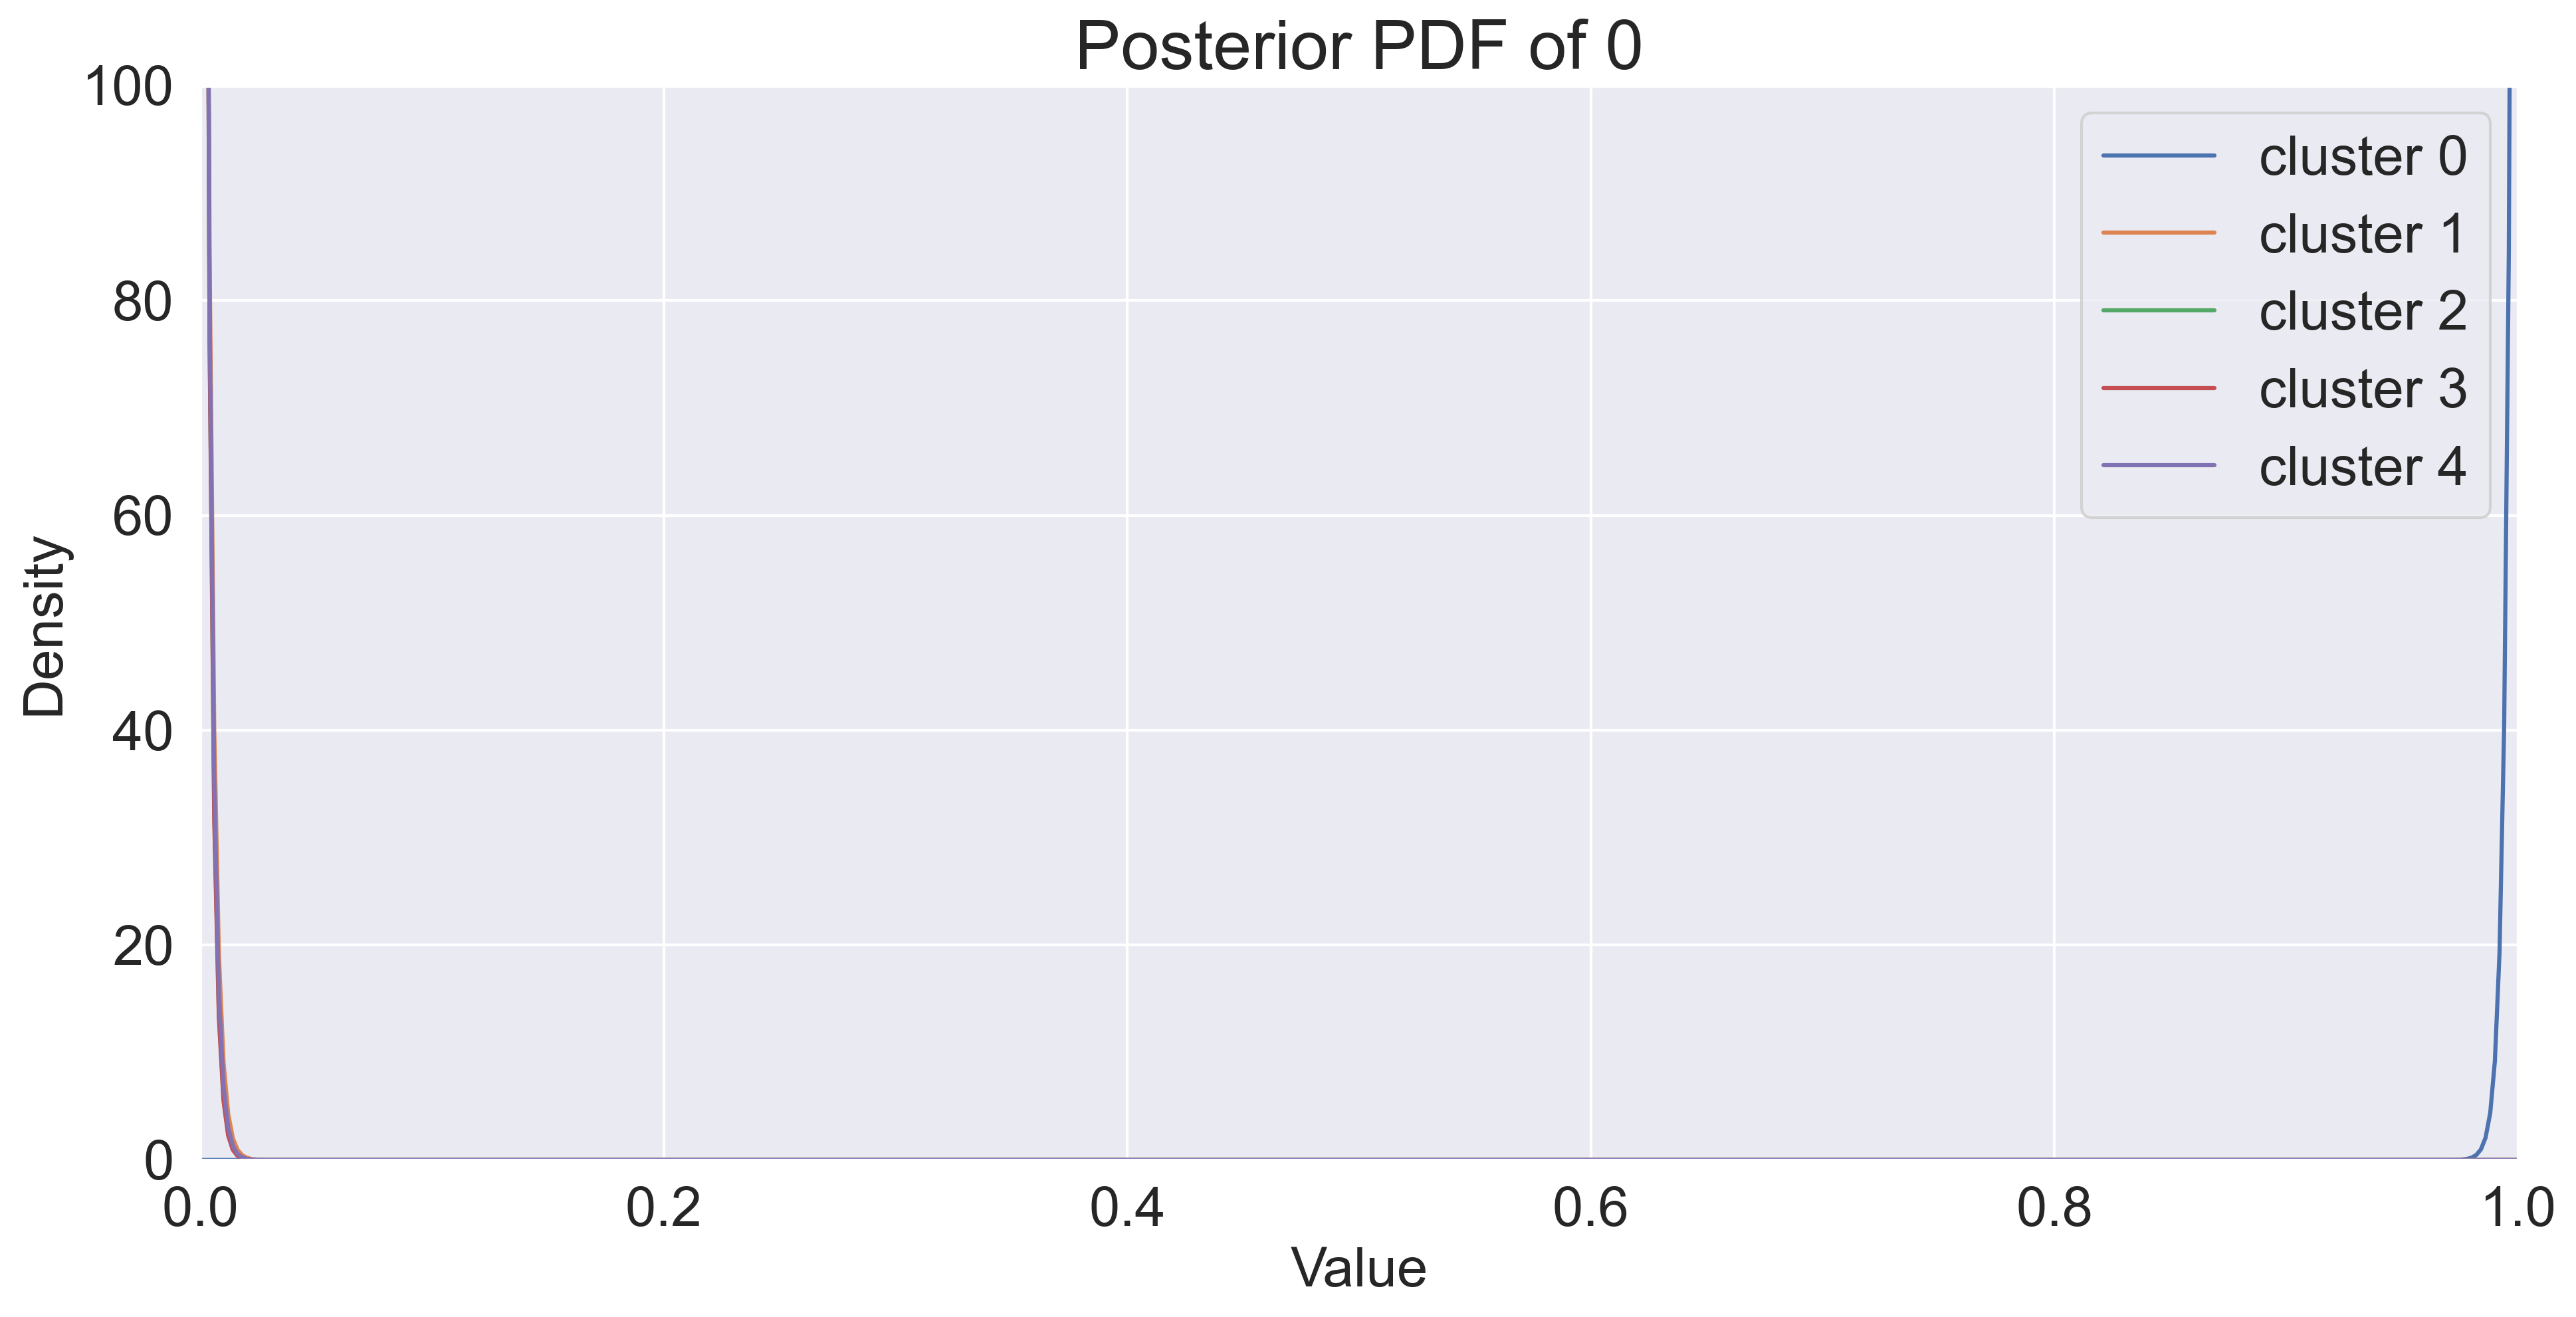

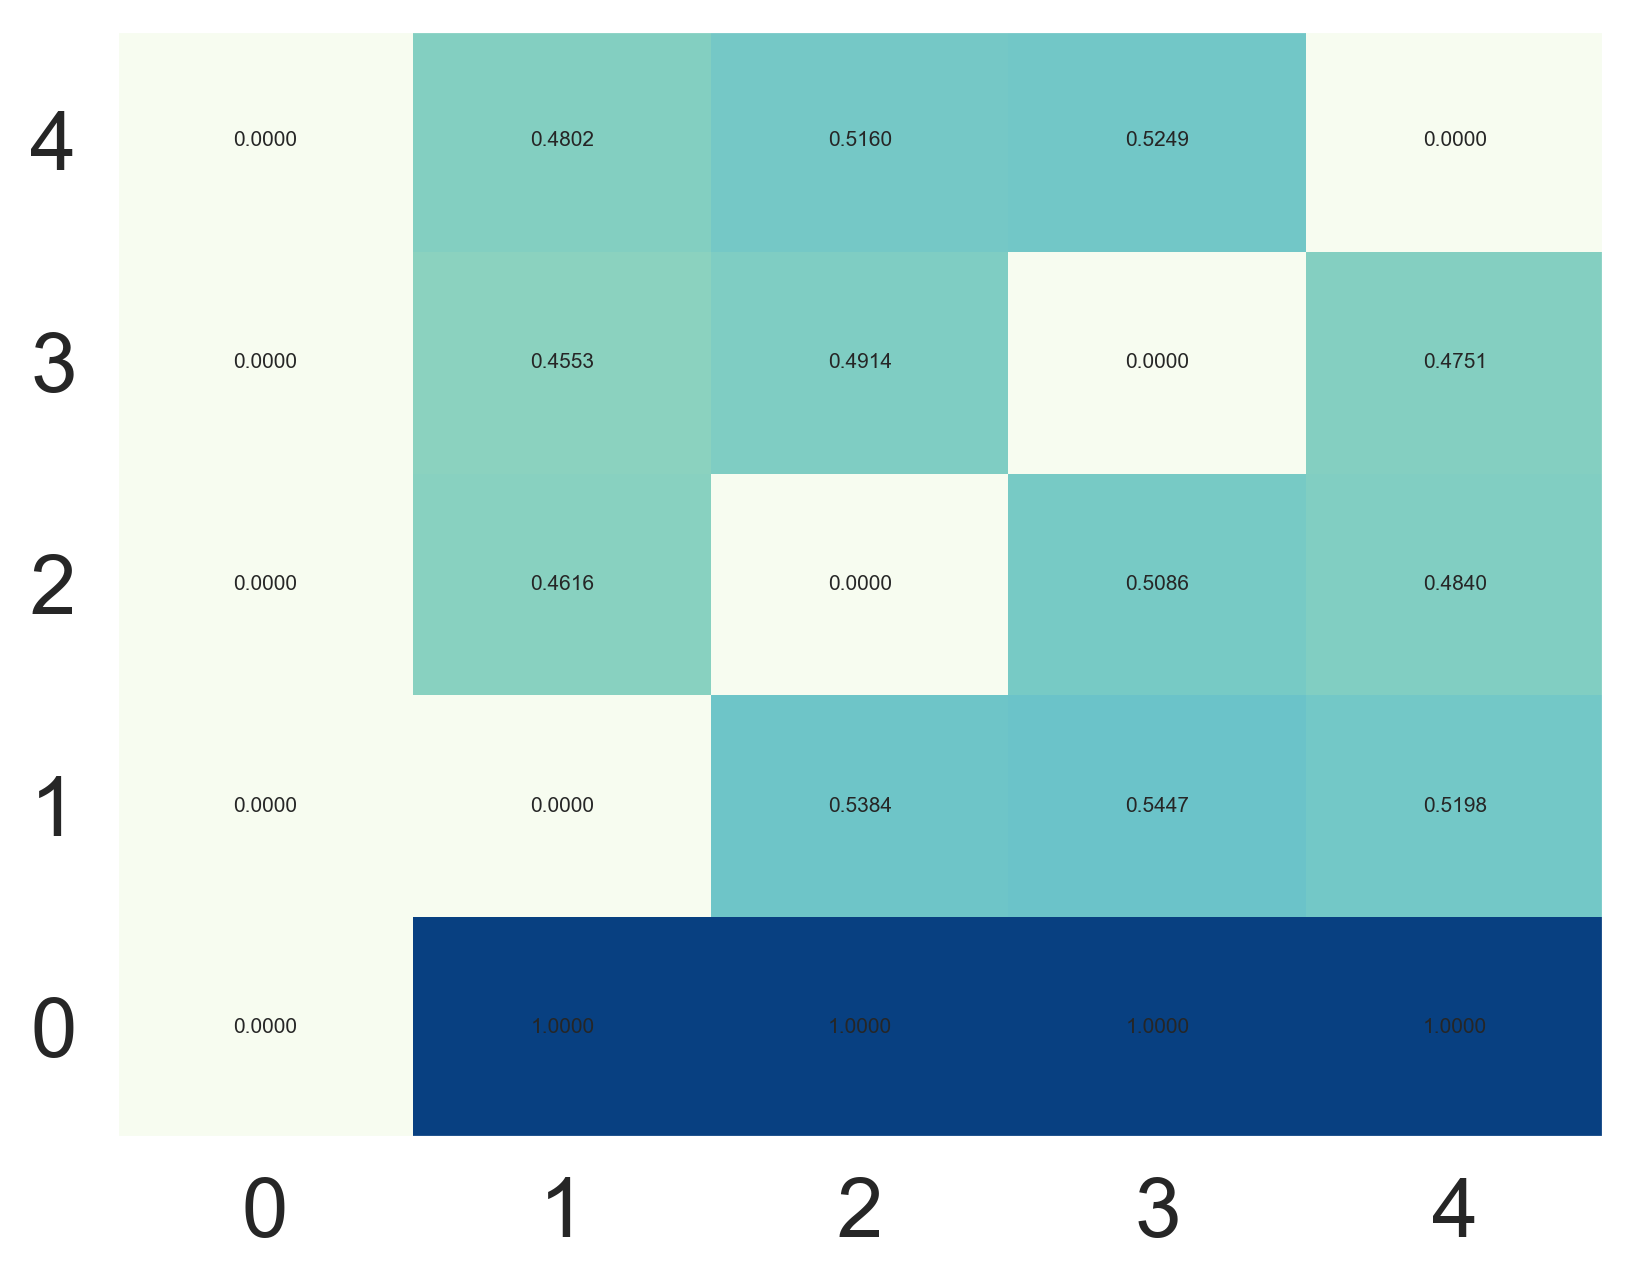

/Users/balbie/Downloads/Thesis/explain_clustering/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:670: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


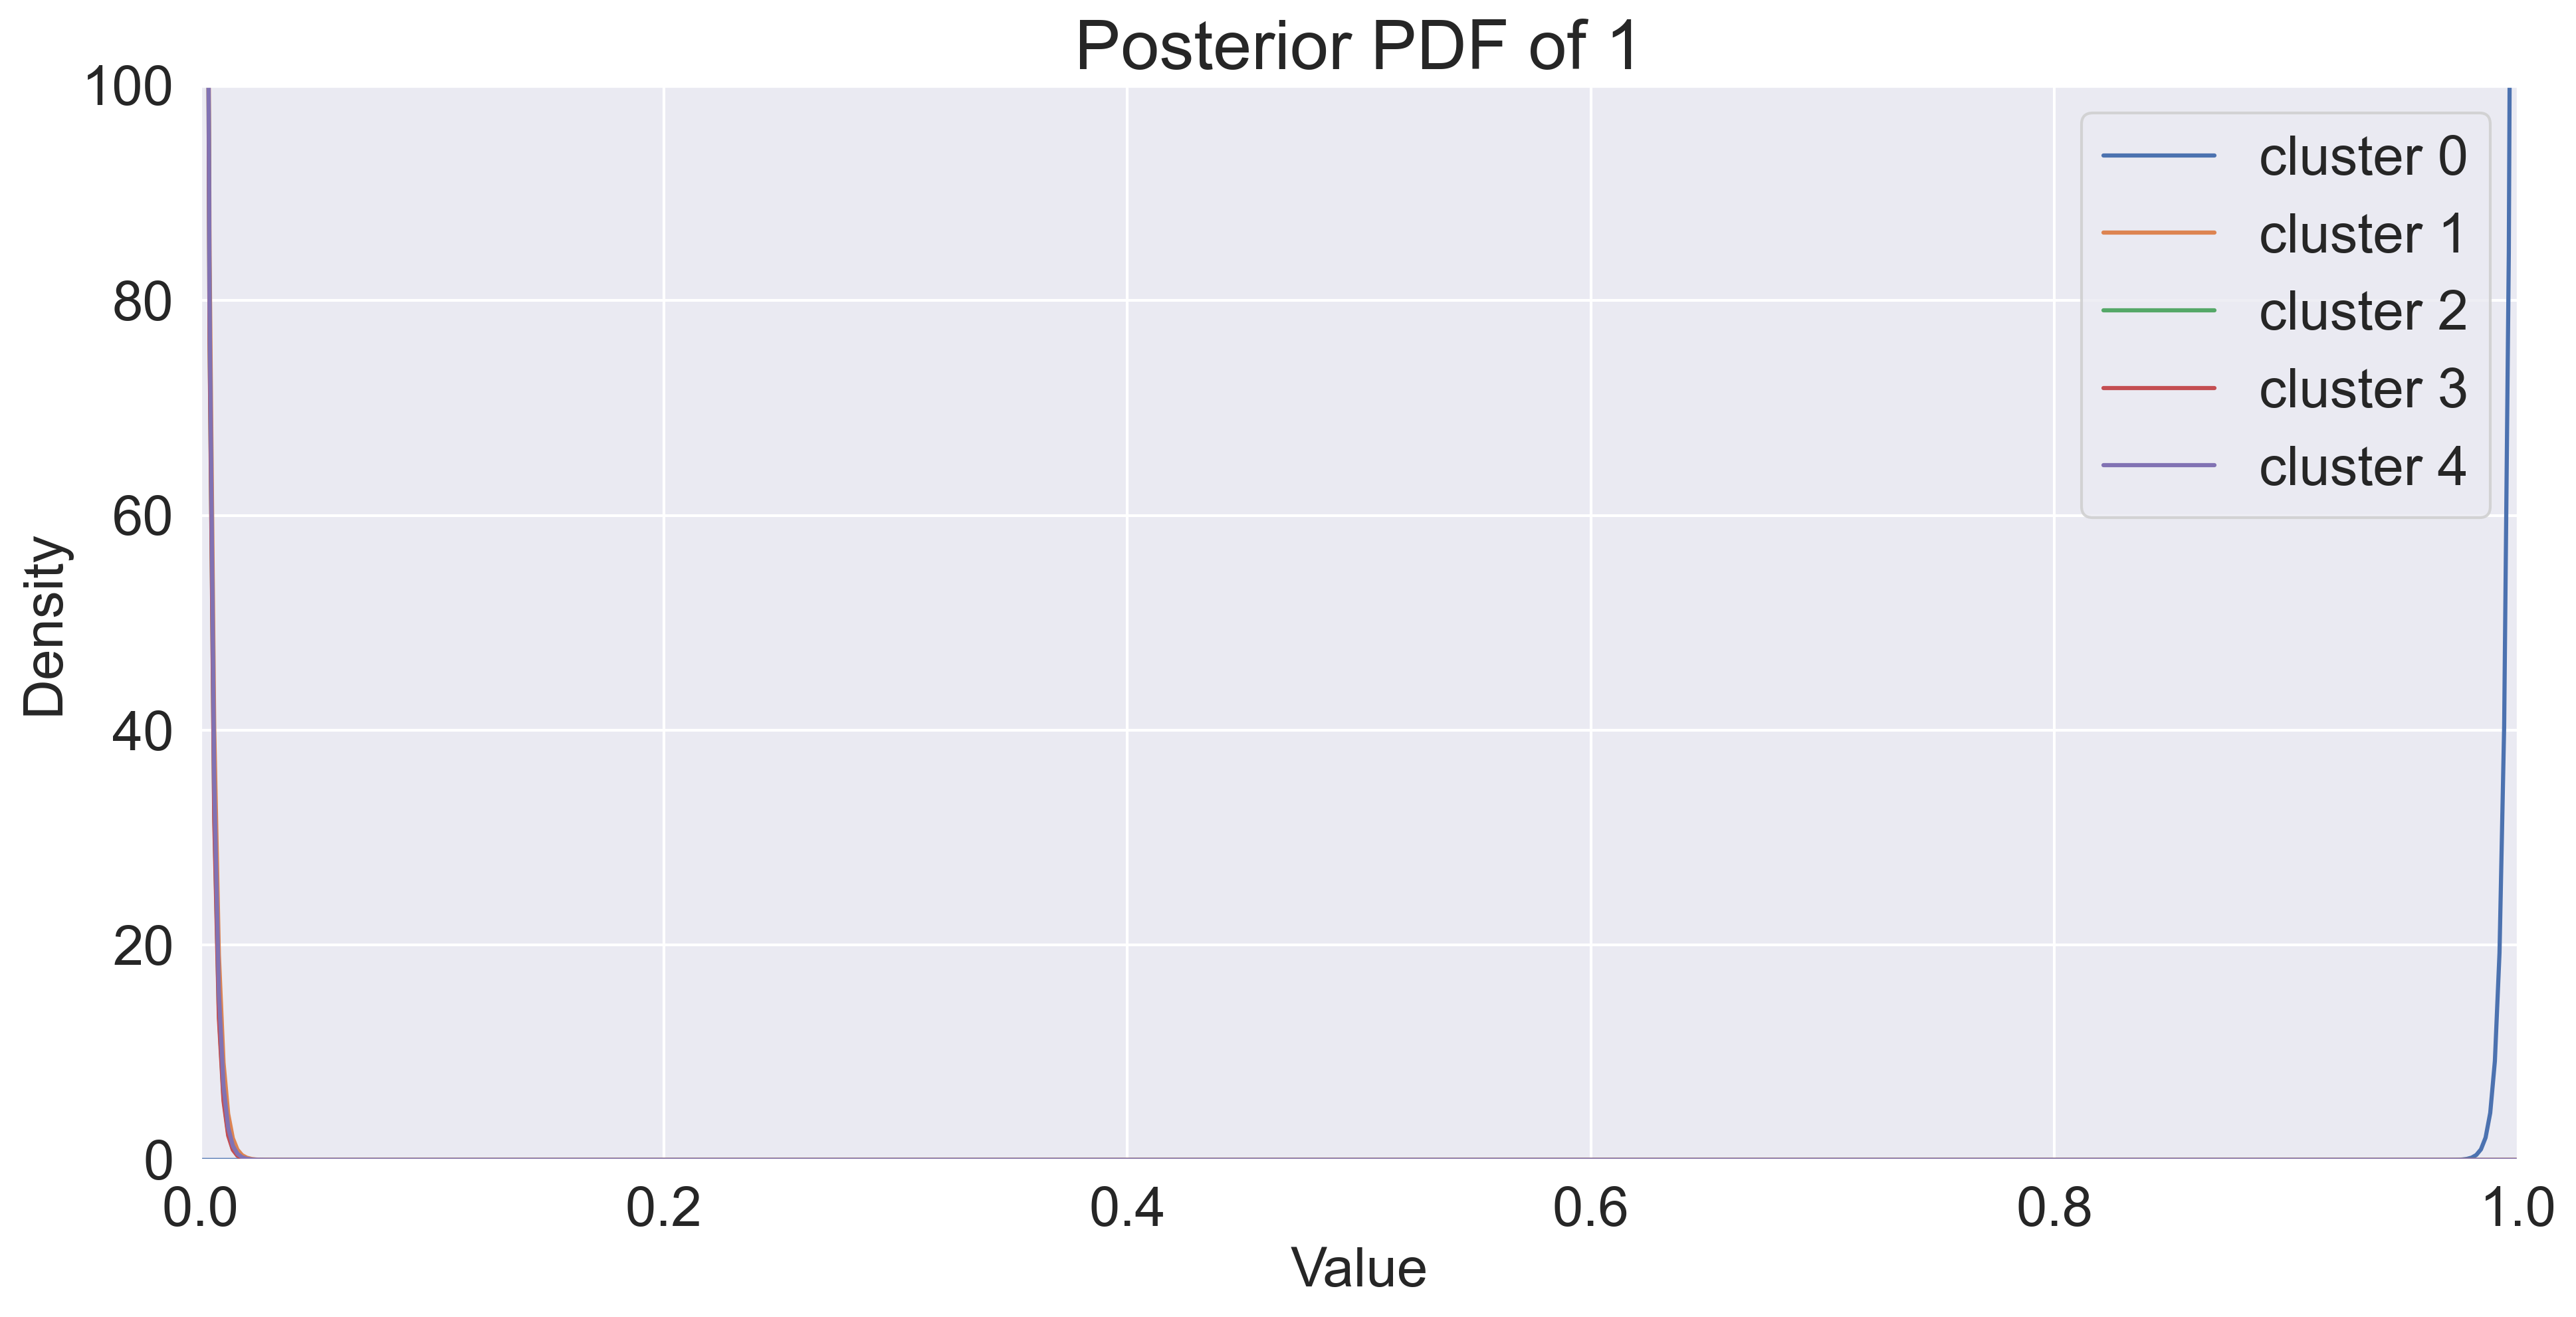

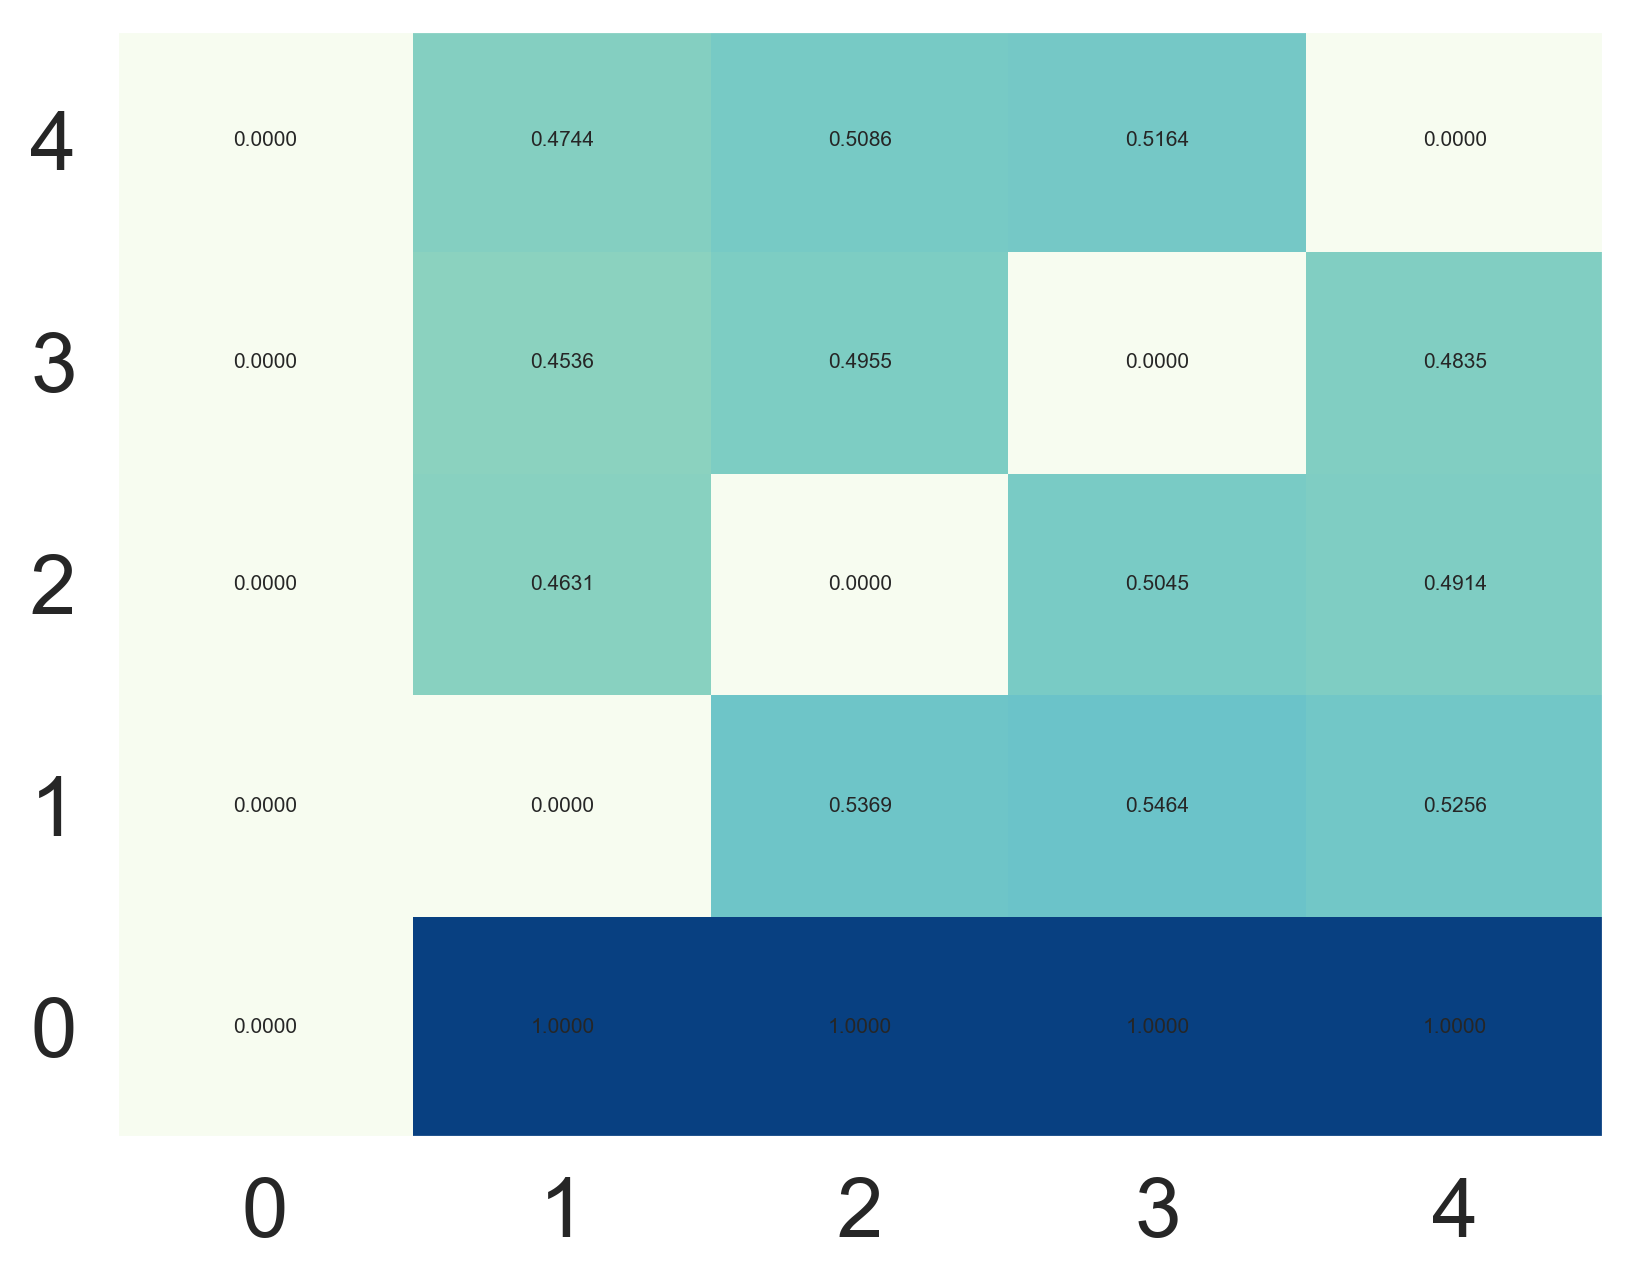

/Users/balbie/Downloads/Thesis/explain_clustering/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:670: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


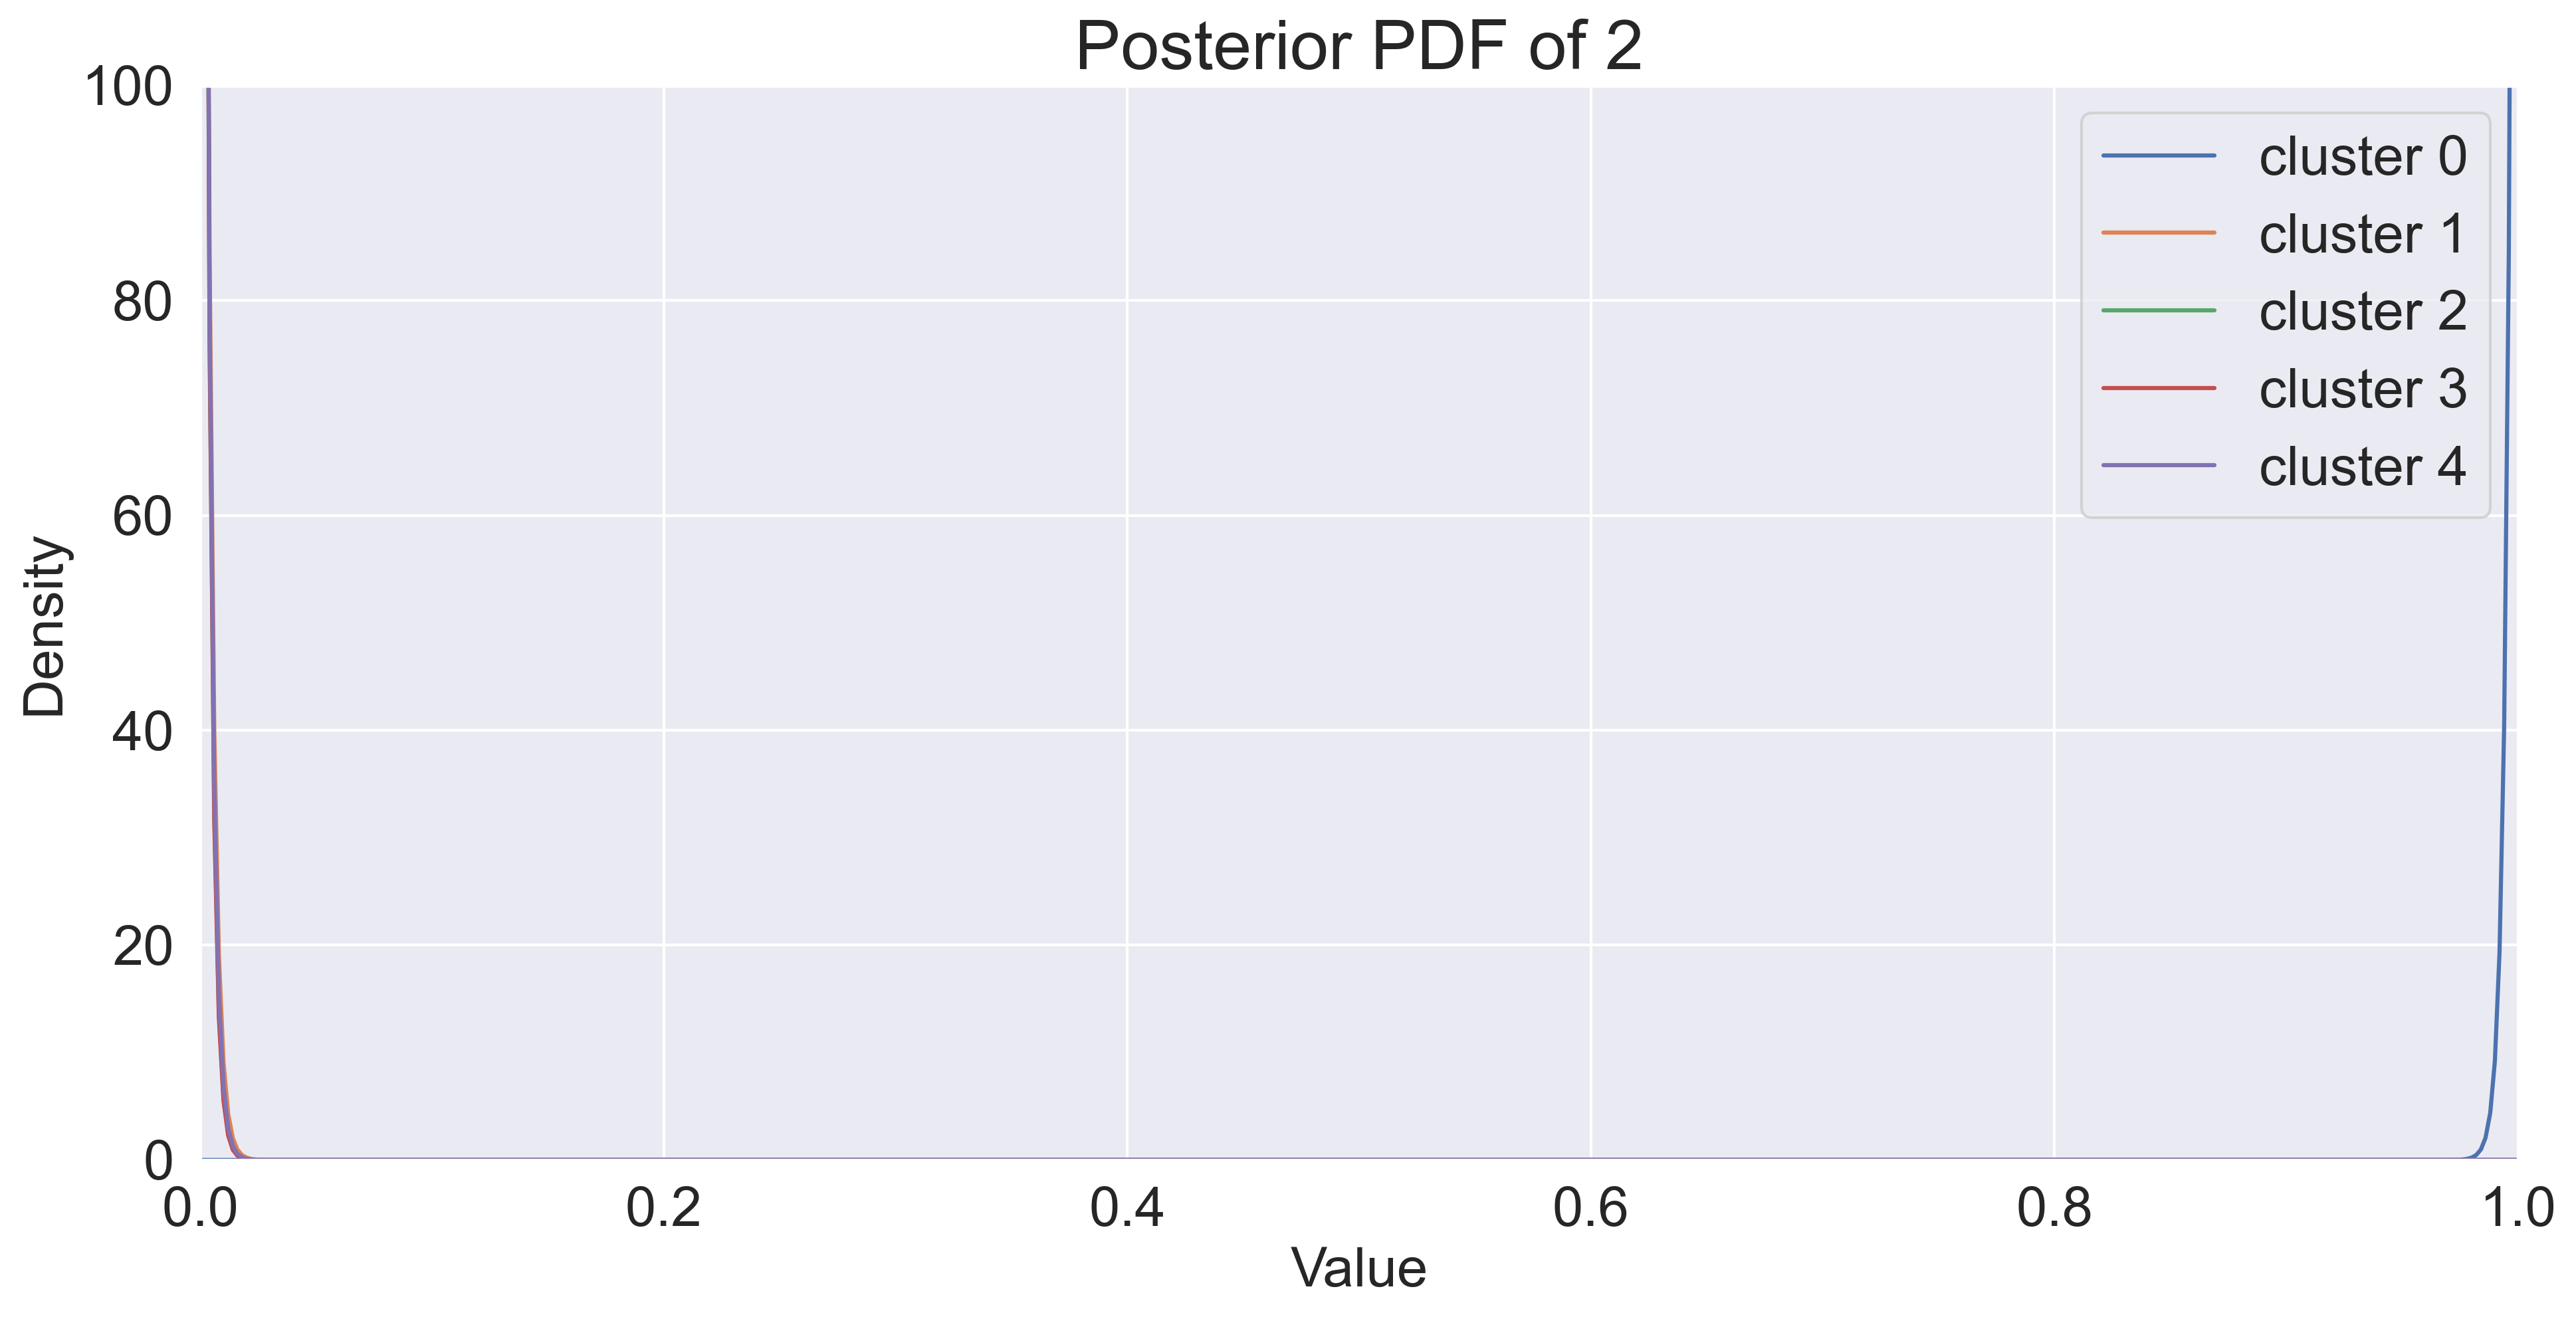

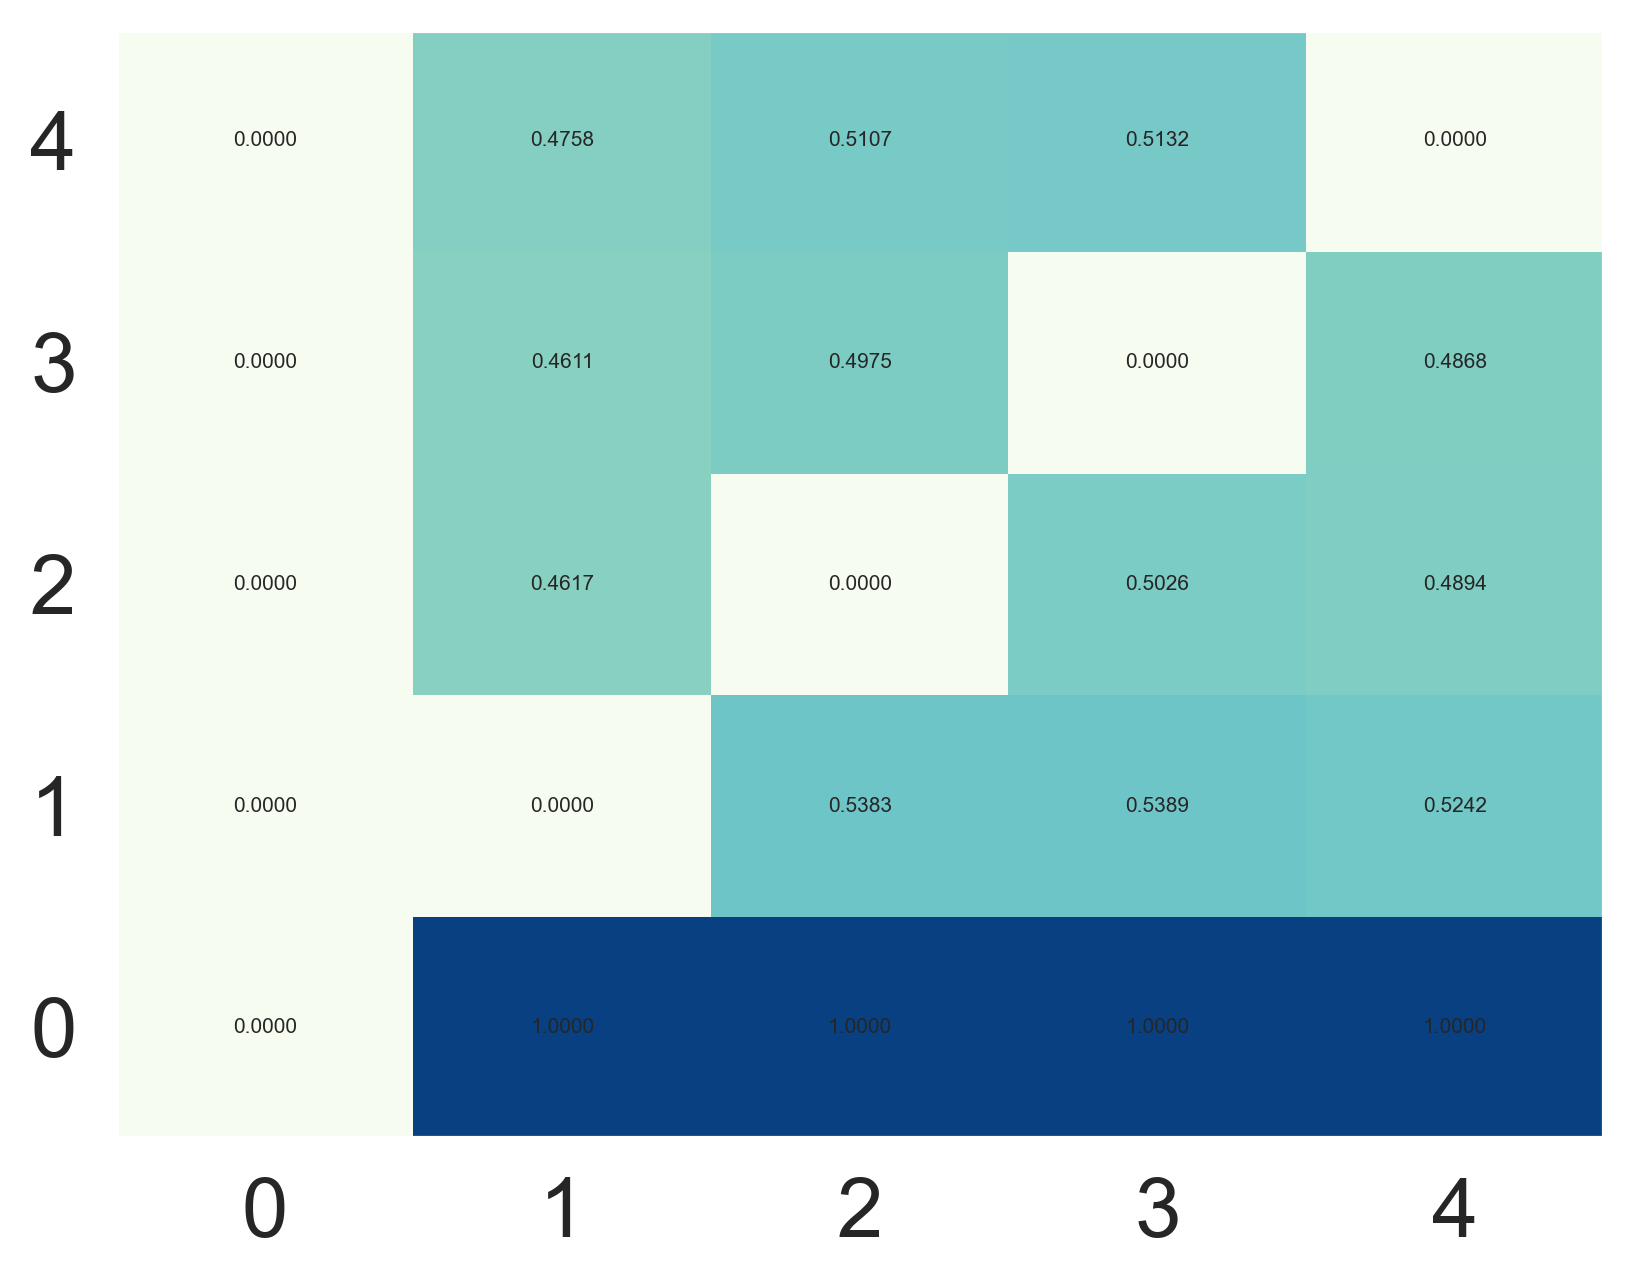

/Users/balbie/Downloads/Thesis/explain_clustering/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:670: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


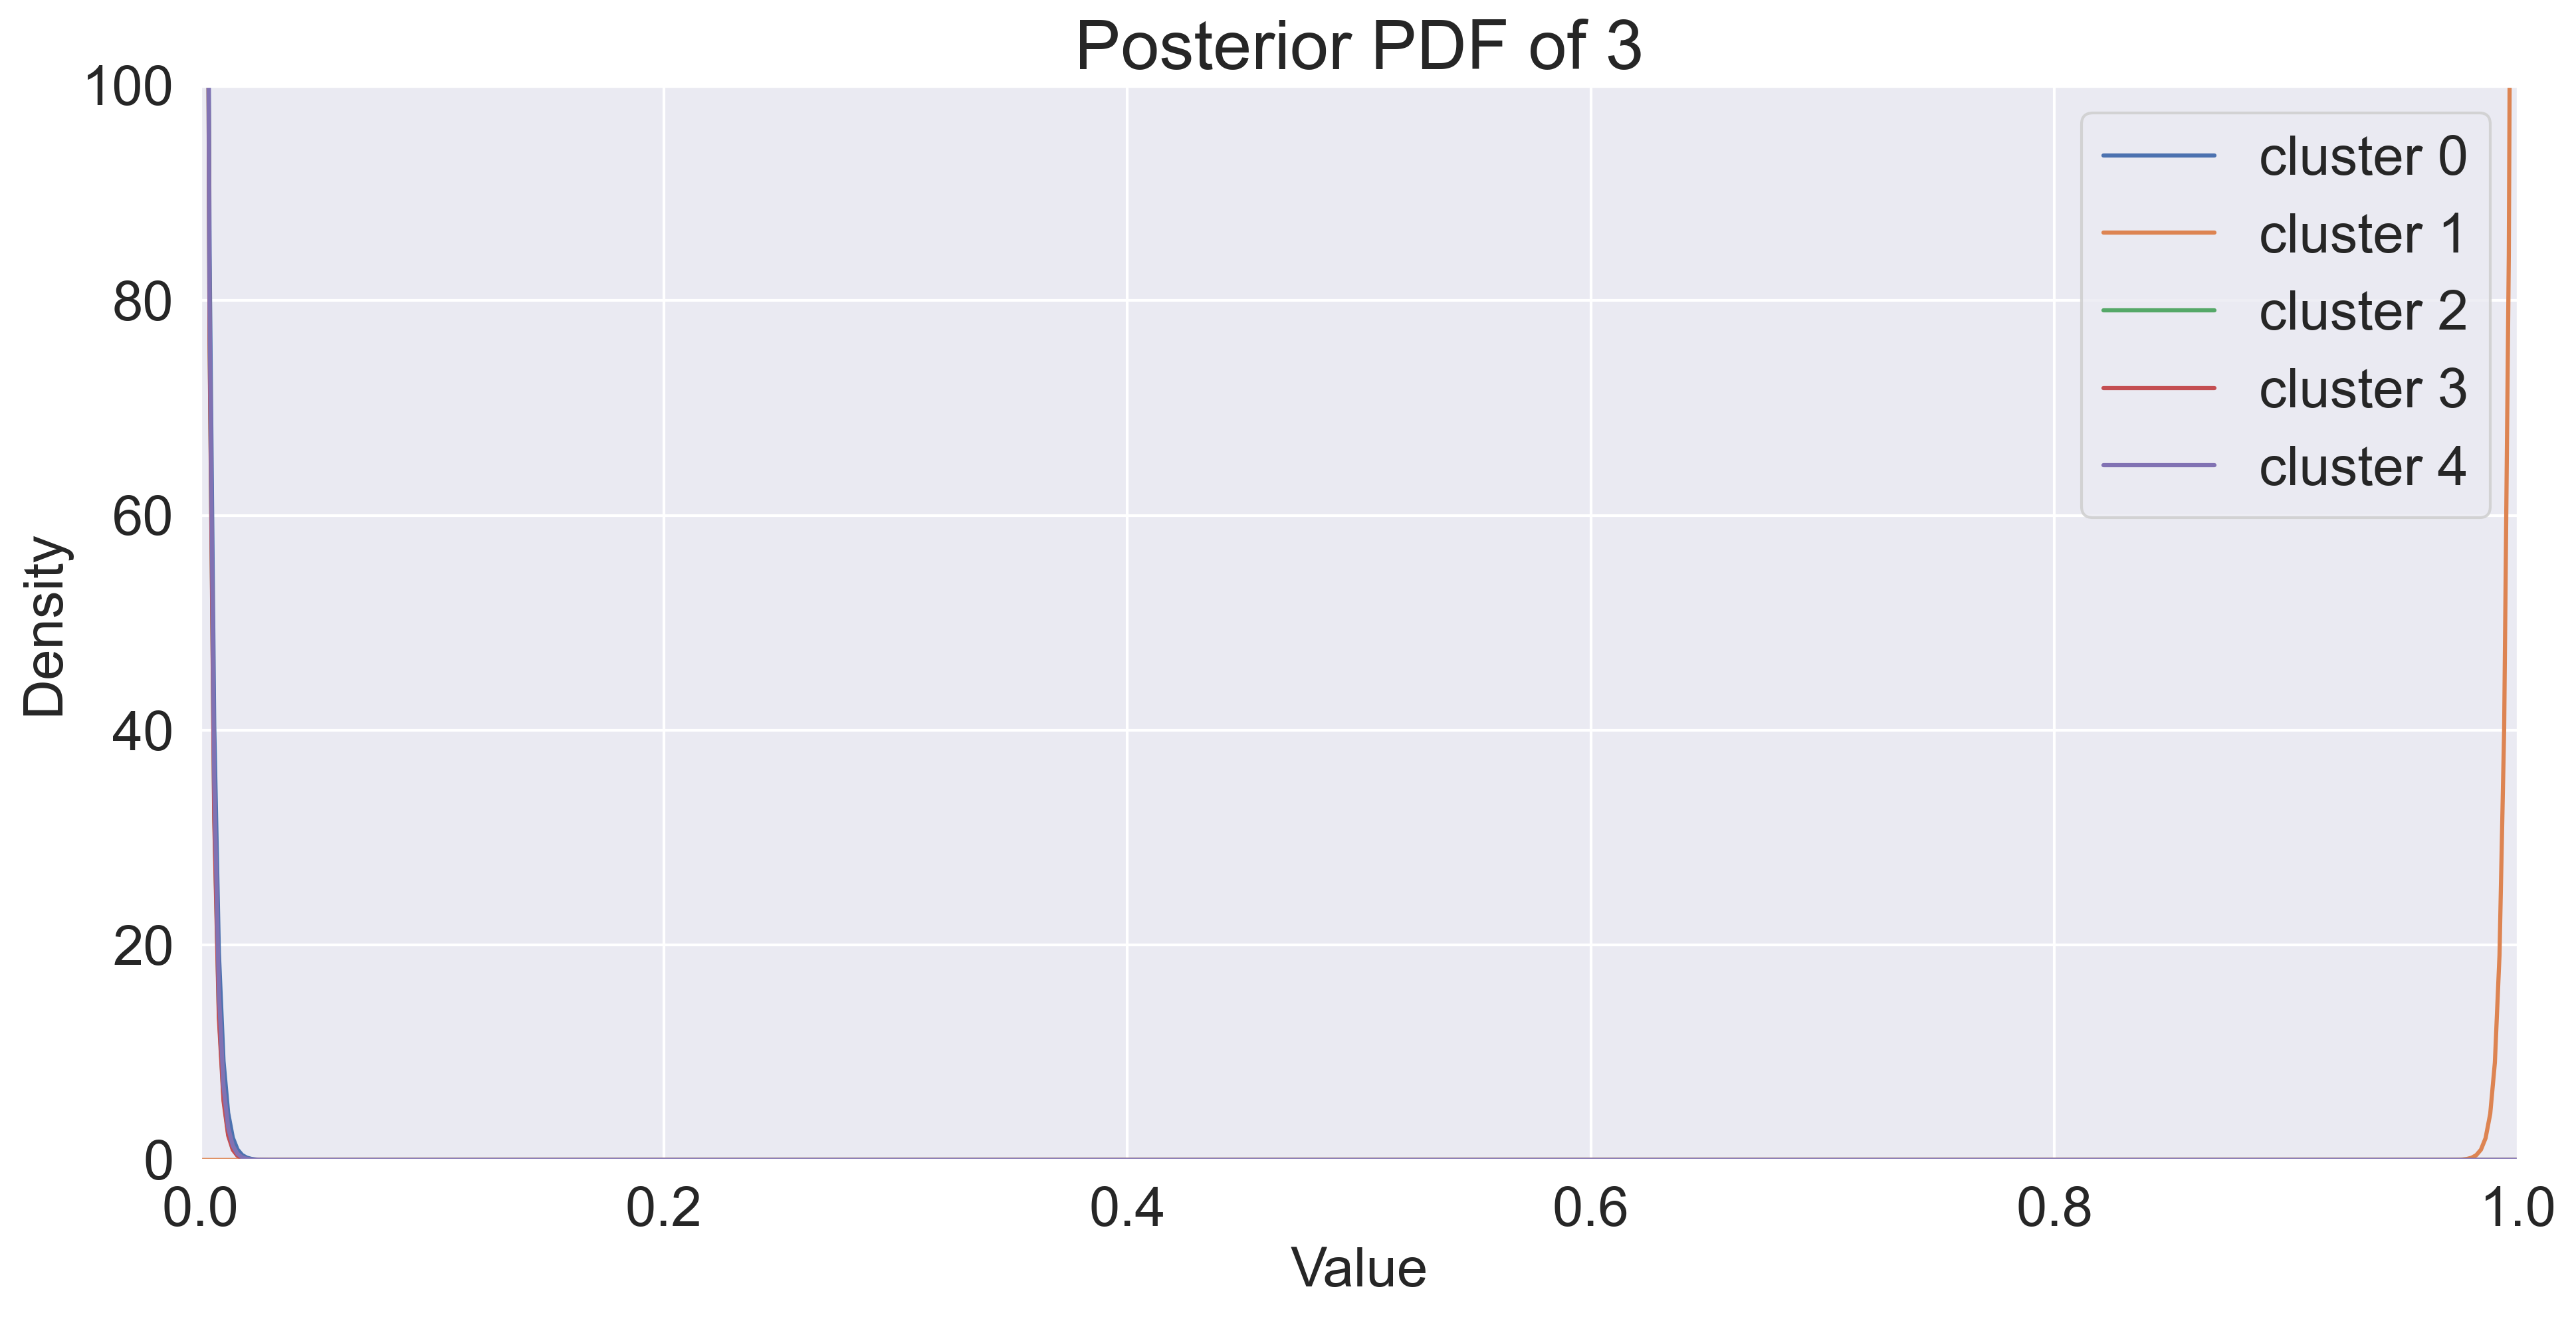

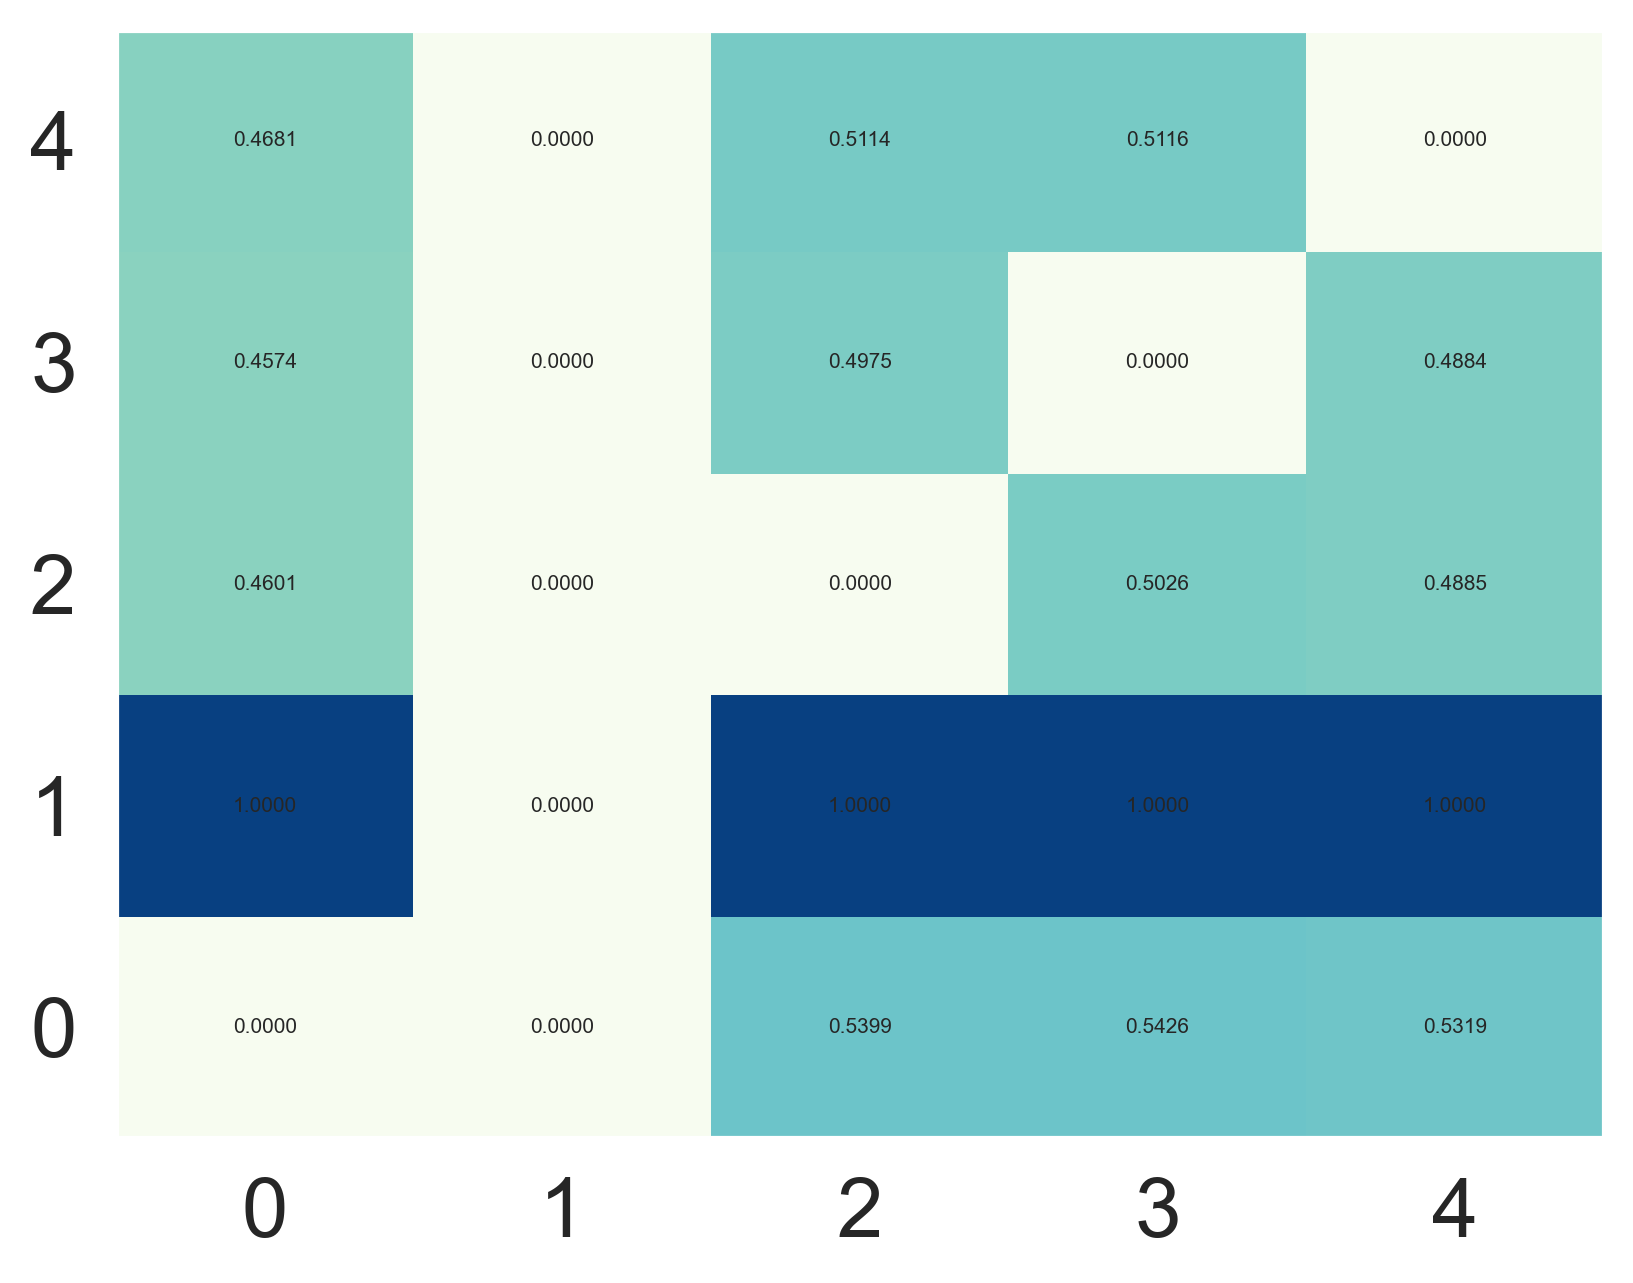

/Users/balbie/Downloads/Thesis/explain_clustering/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:670: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


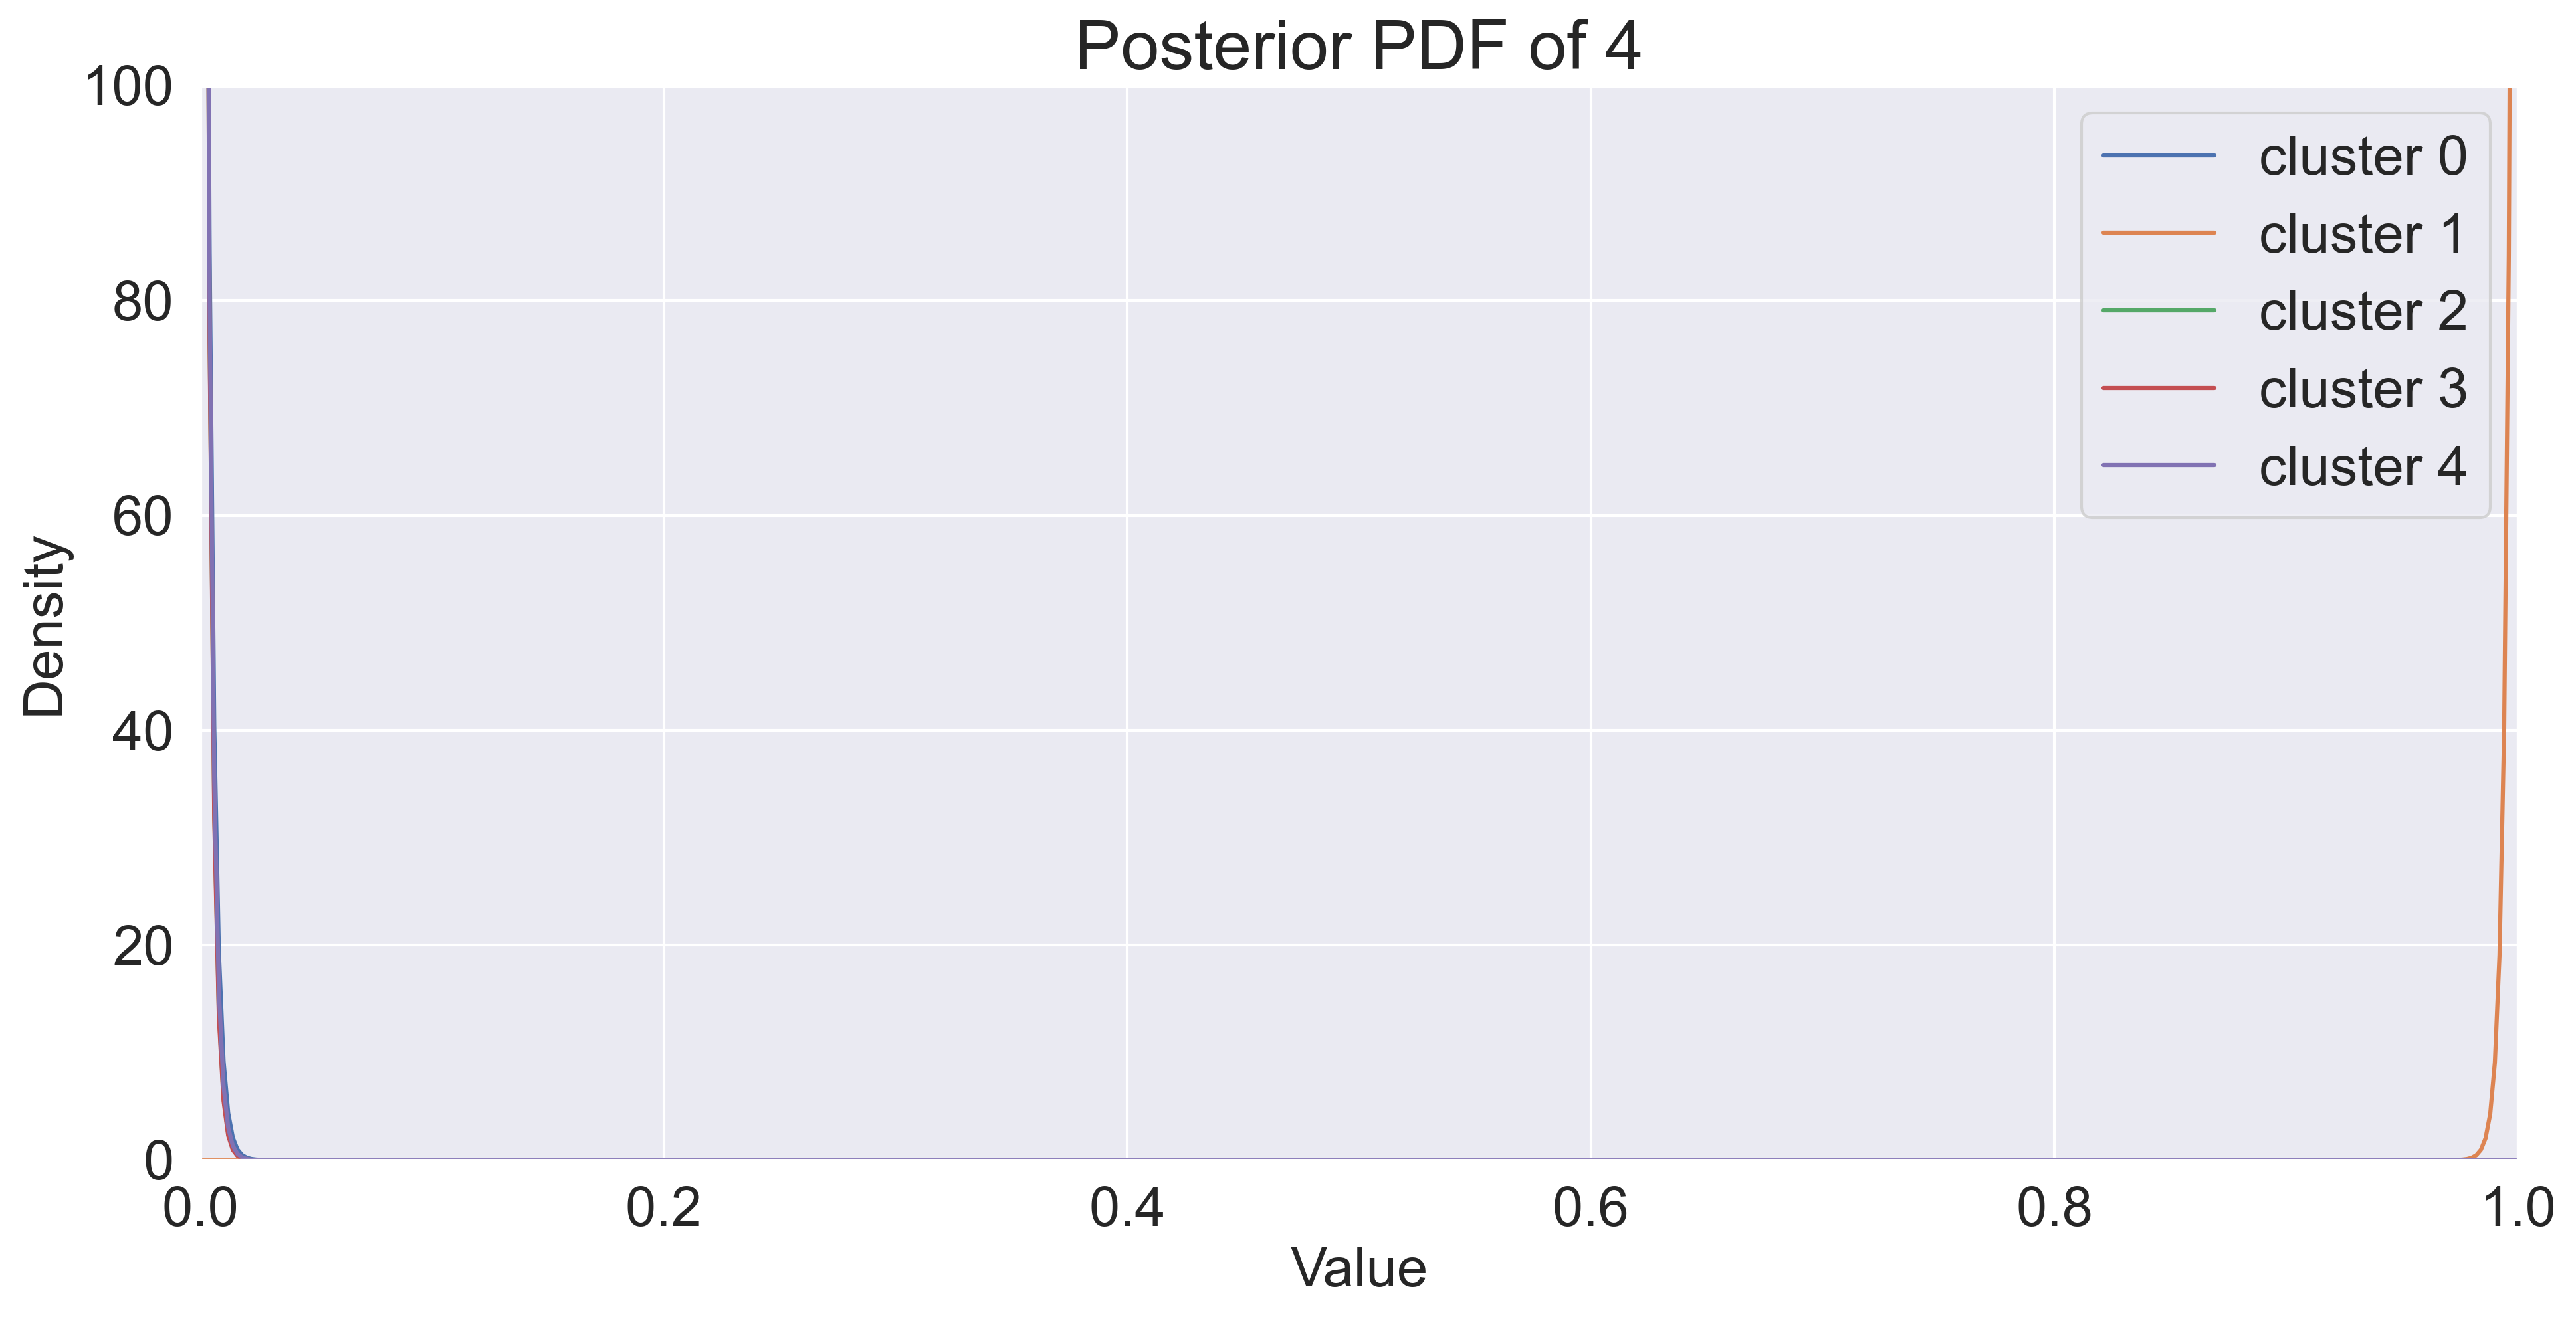

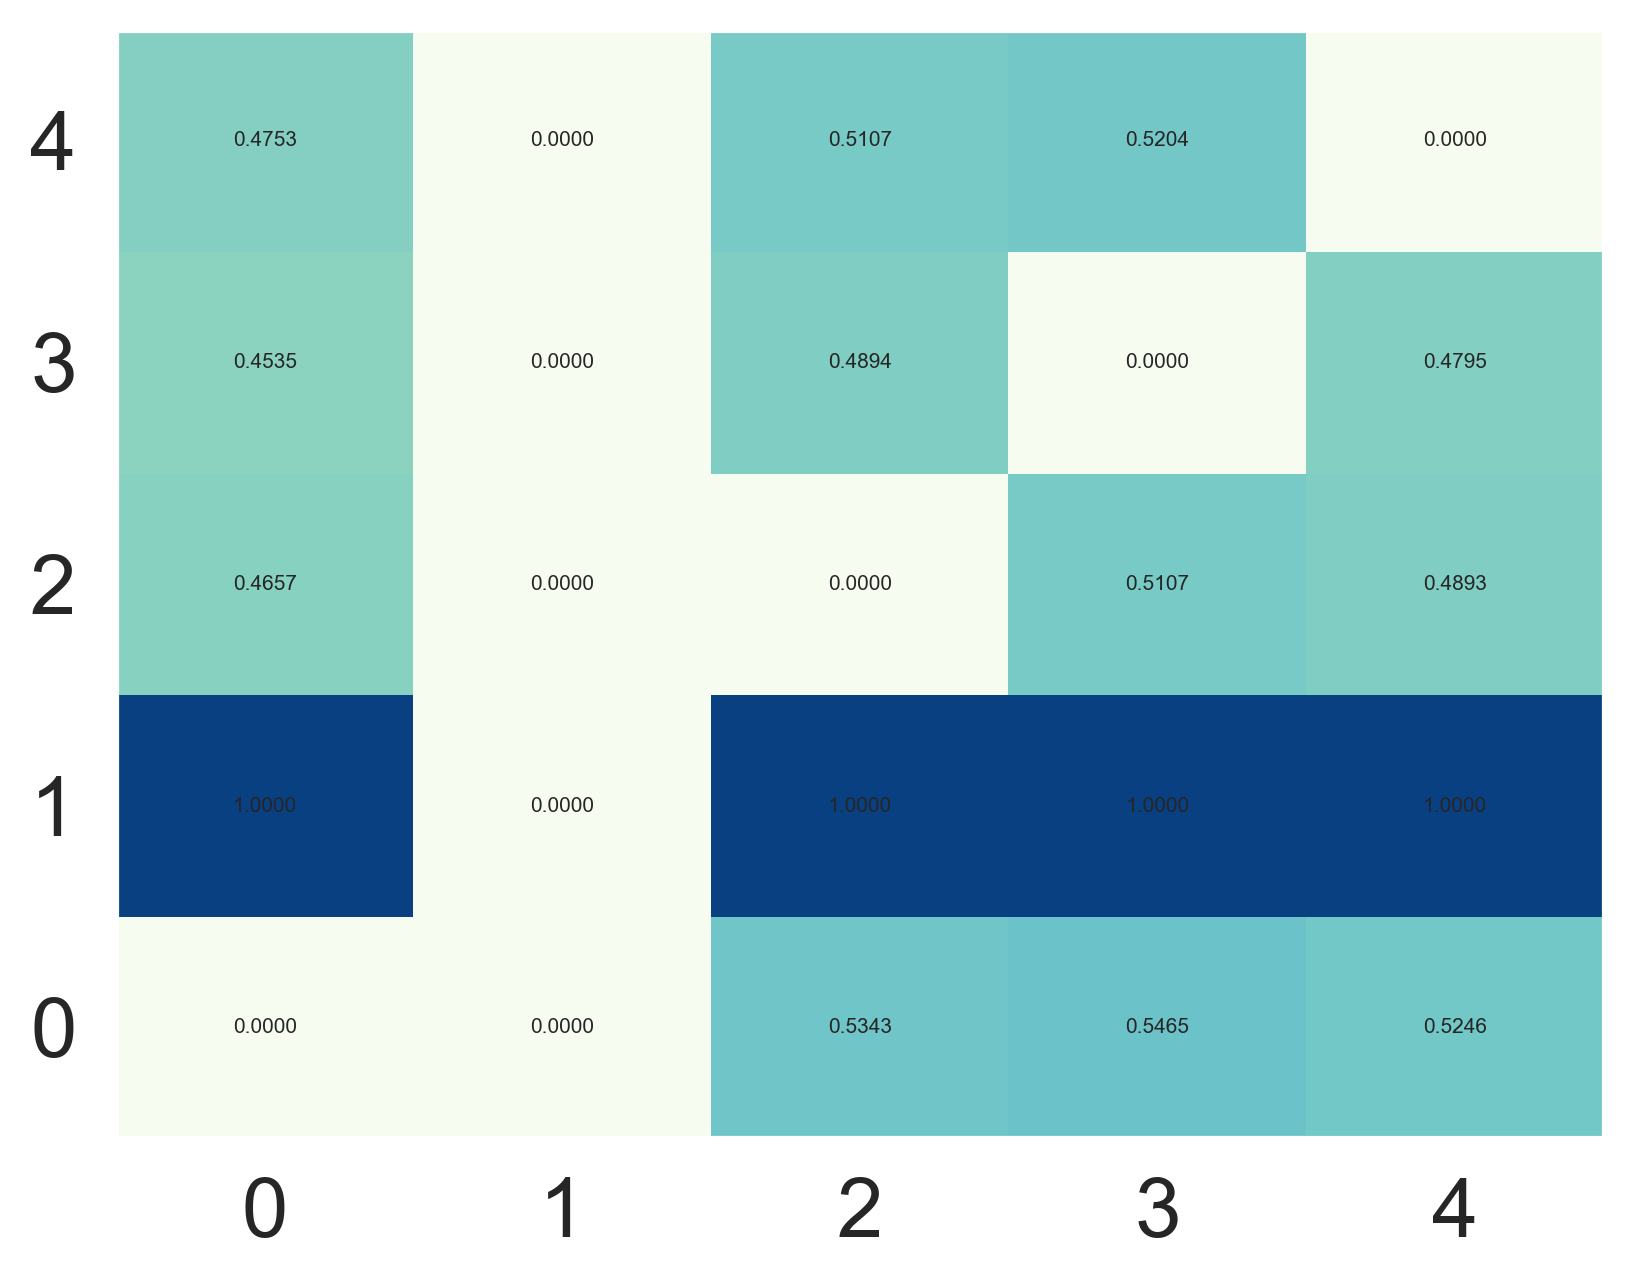

/Users/balbie/Downloads/Thesis/explain_clustering/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:670: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


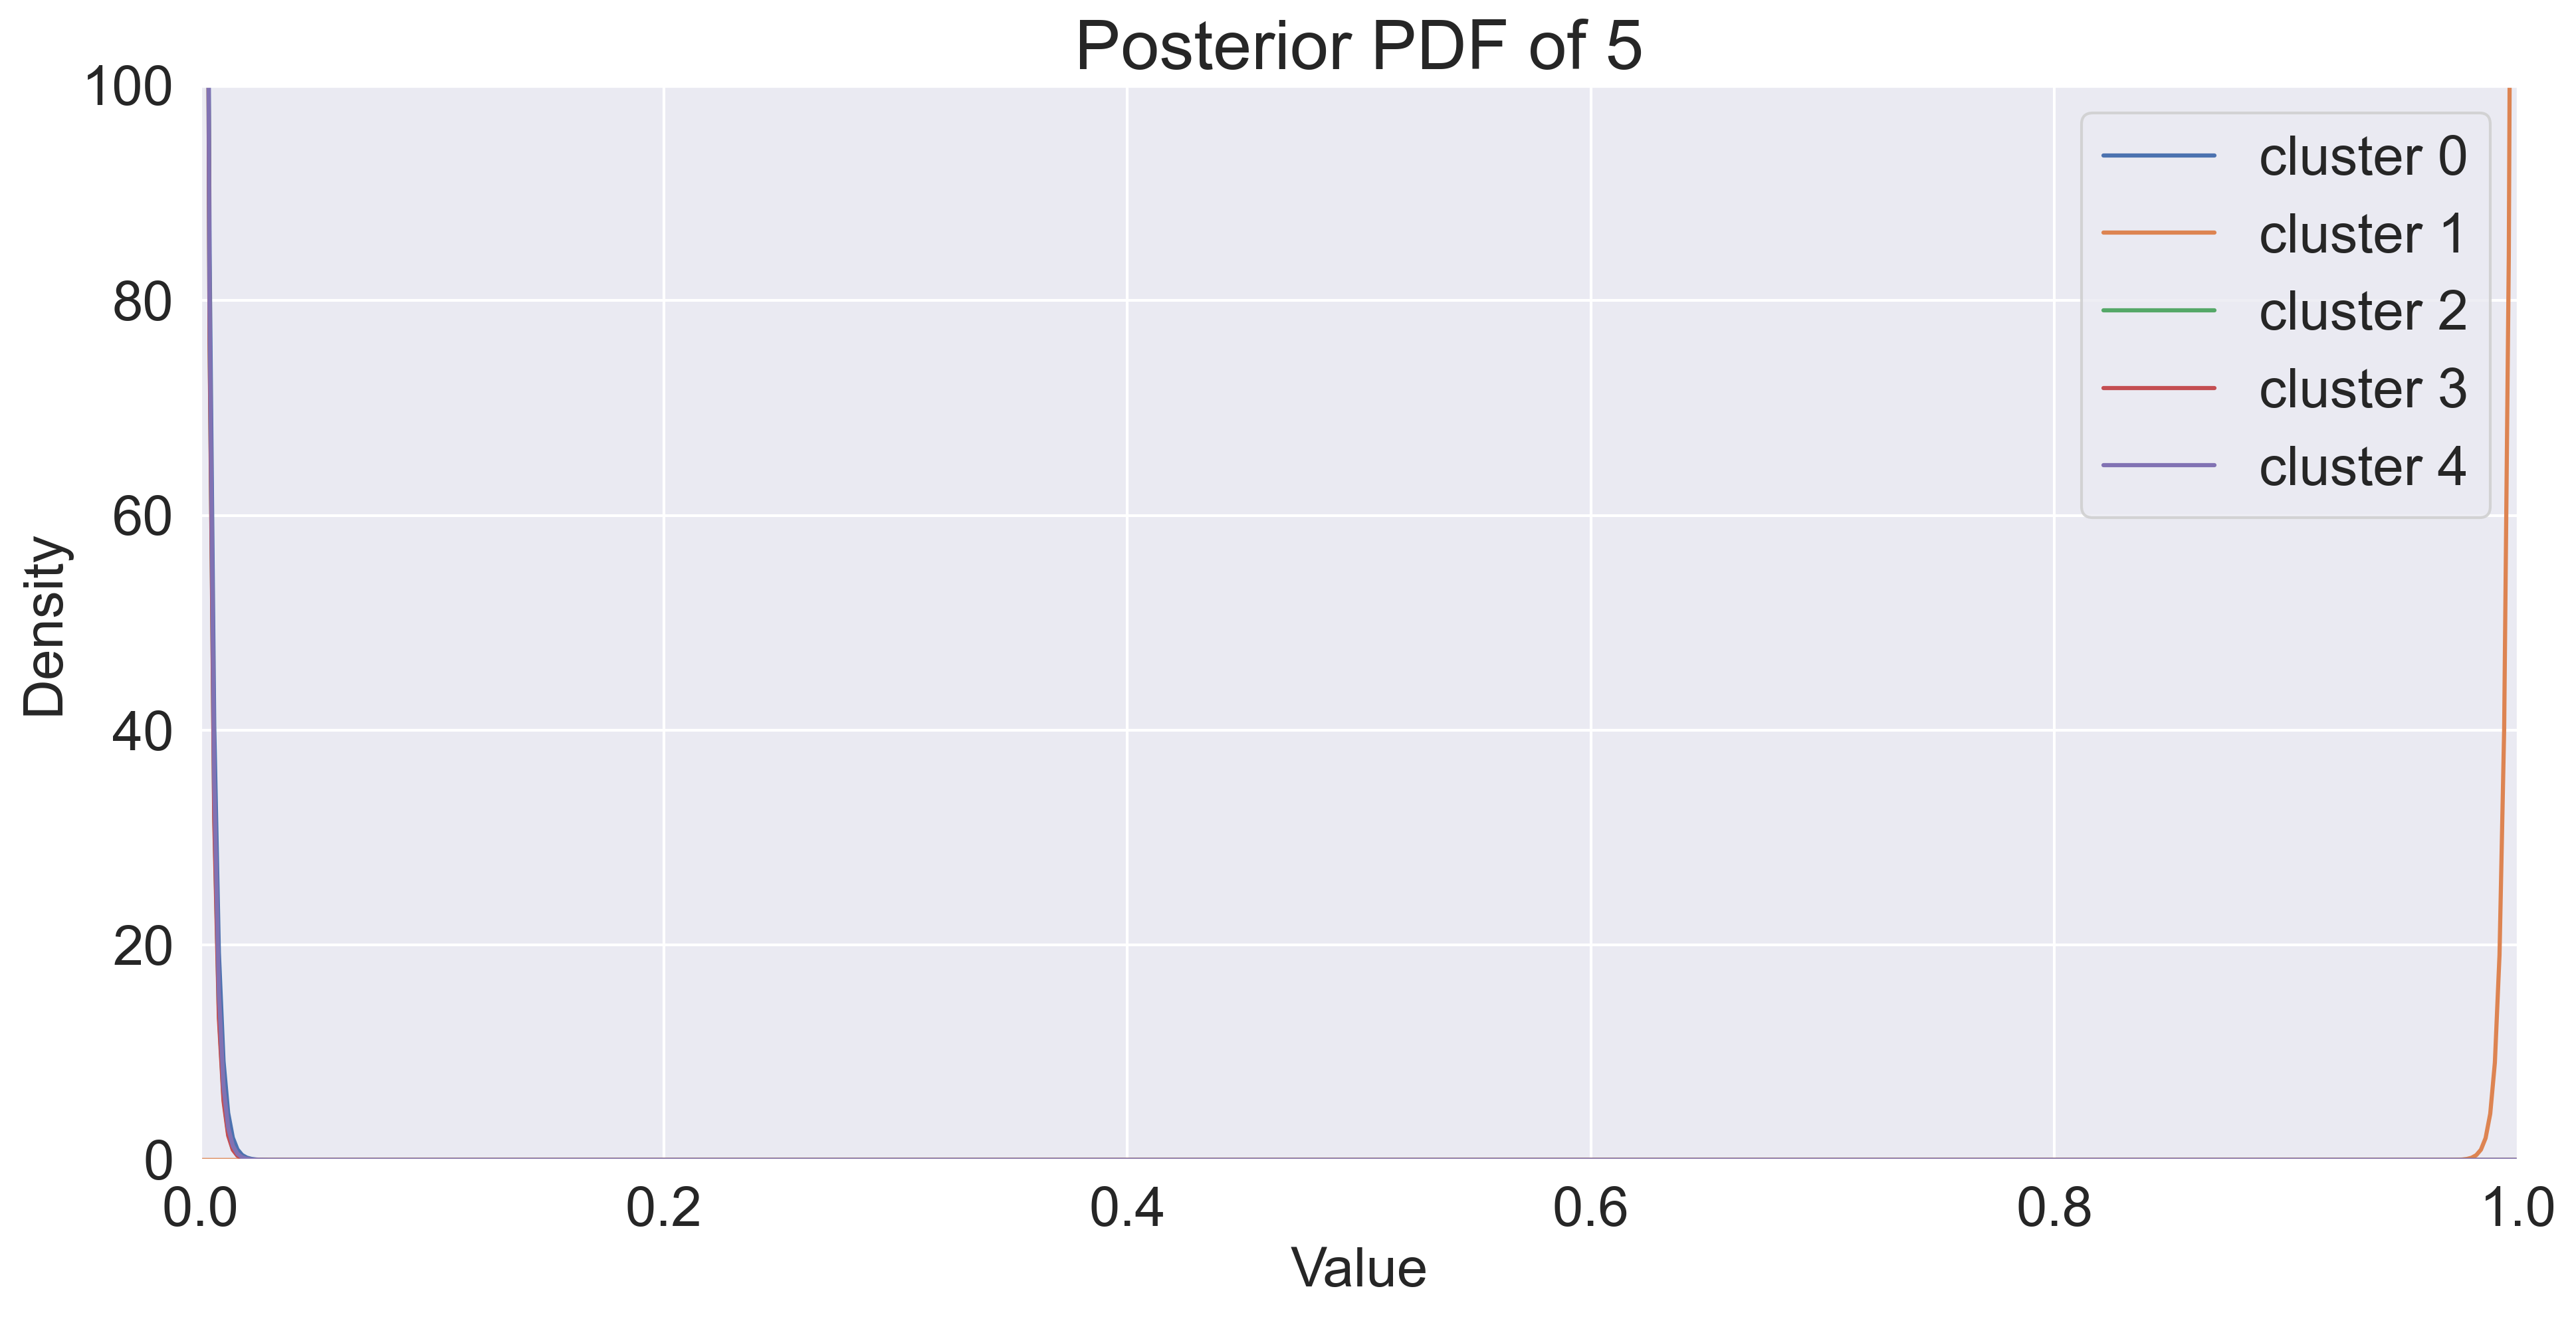

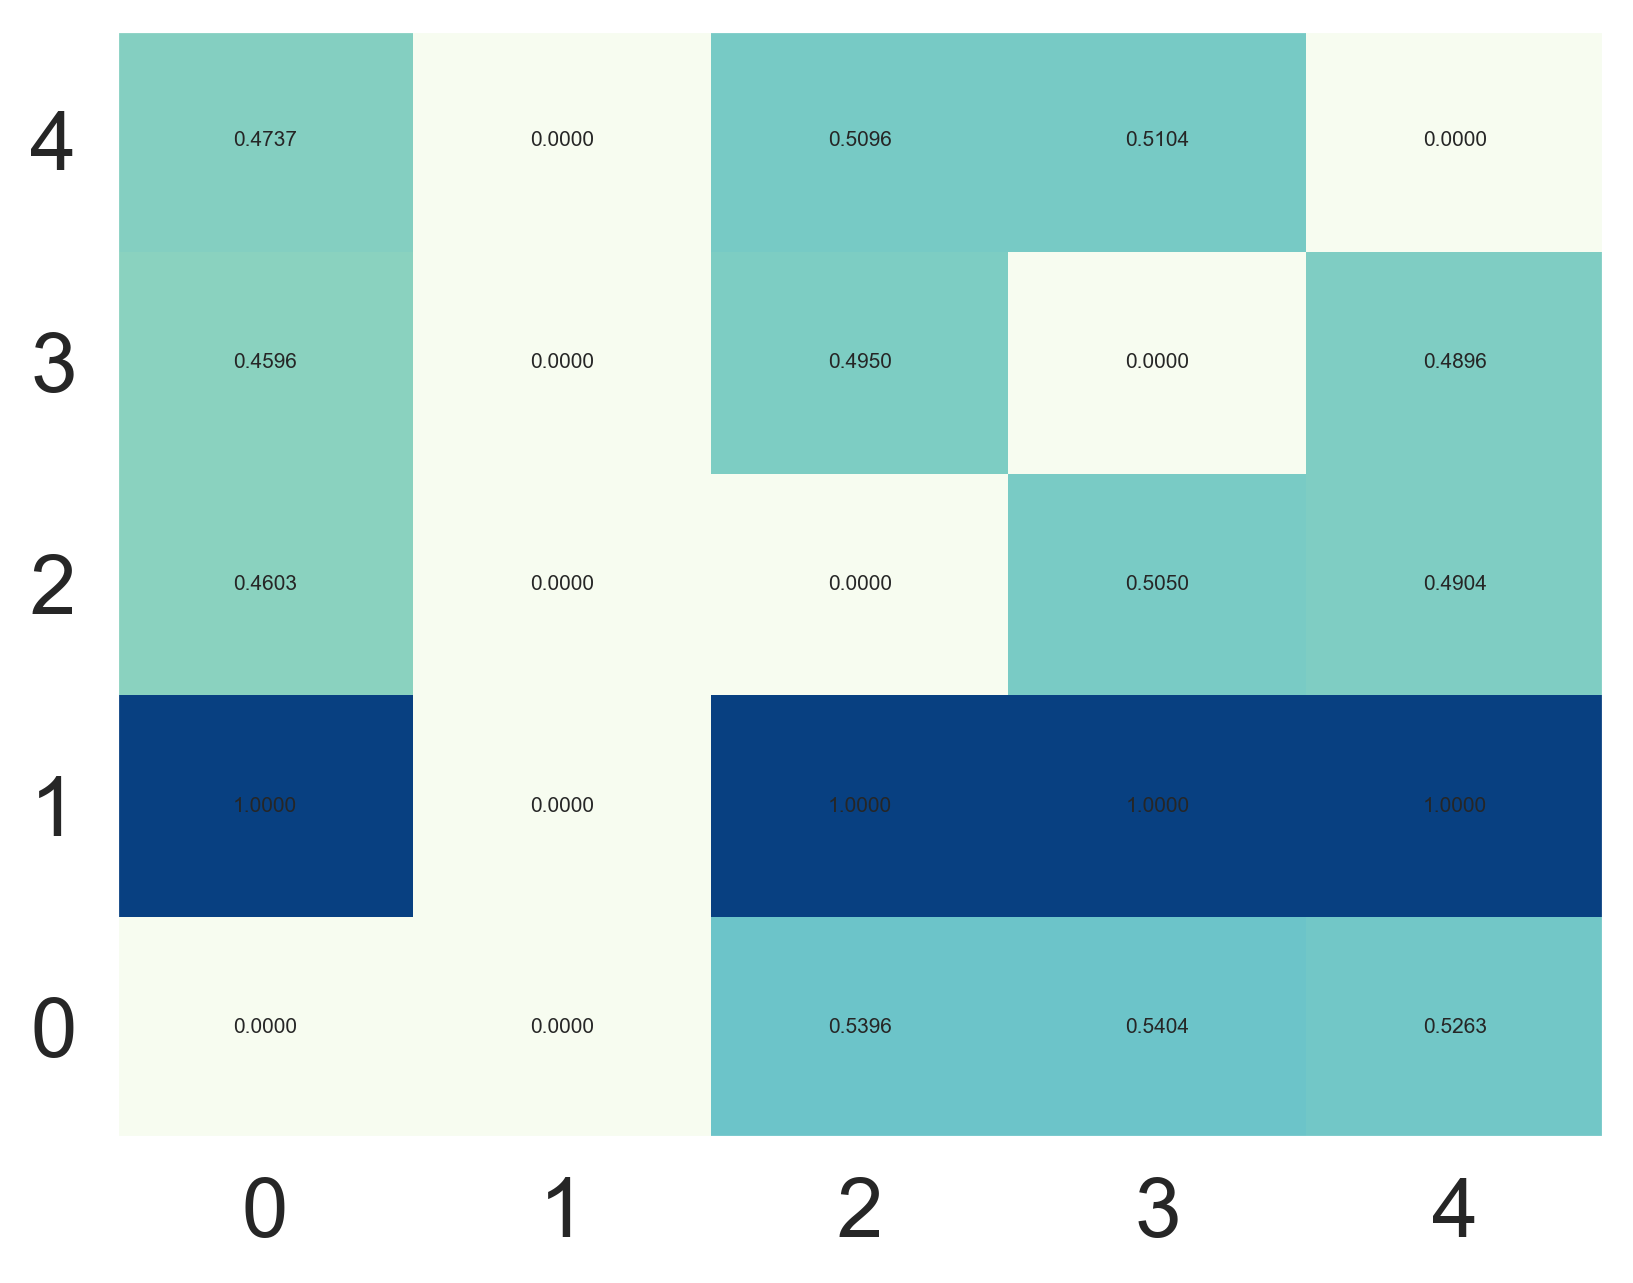

/Users/balbie/Downloads/Thesis/explain_clustering/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:670: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


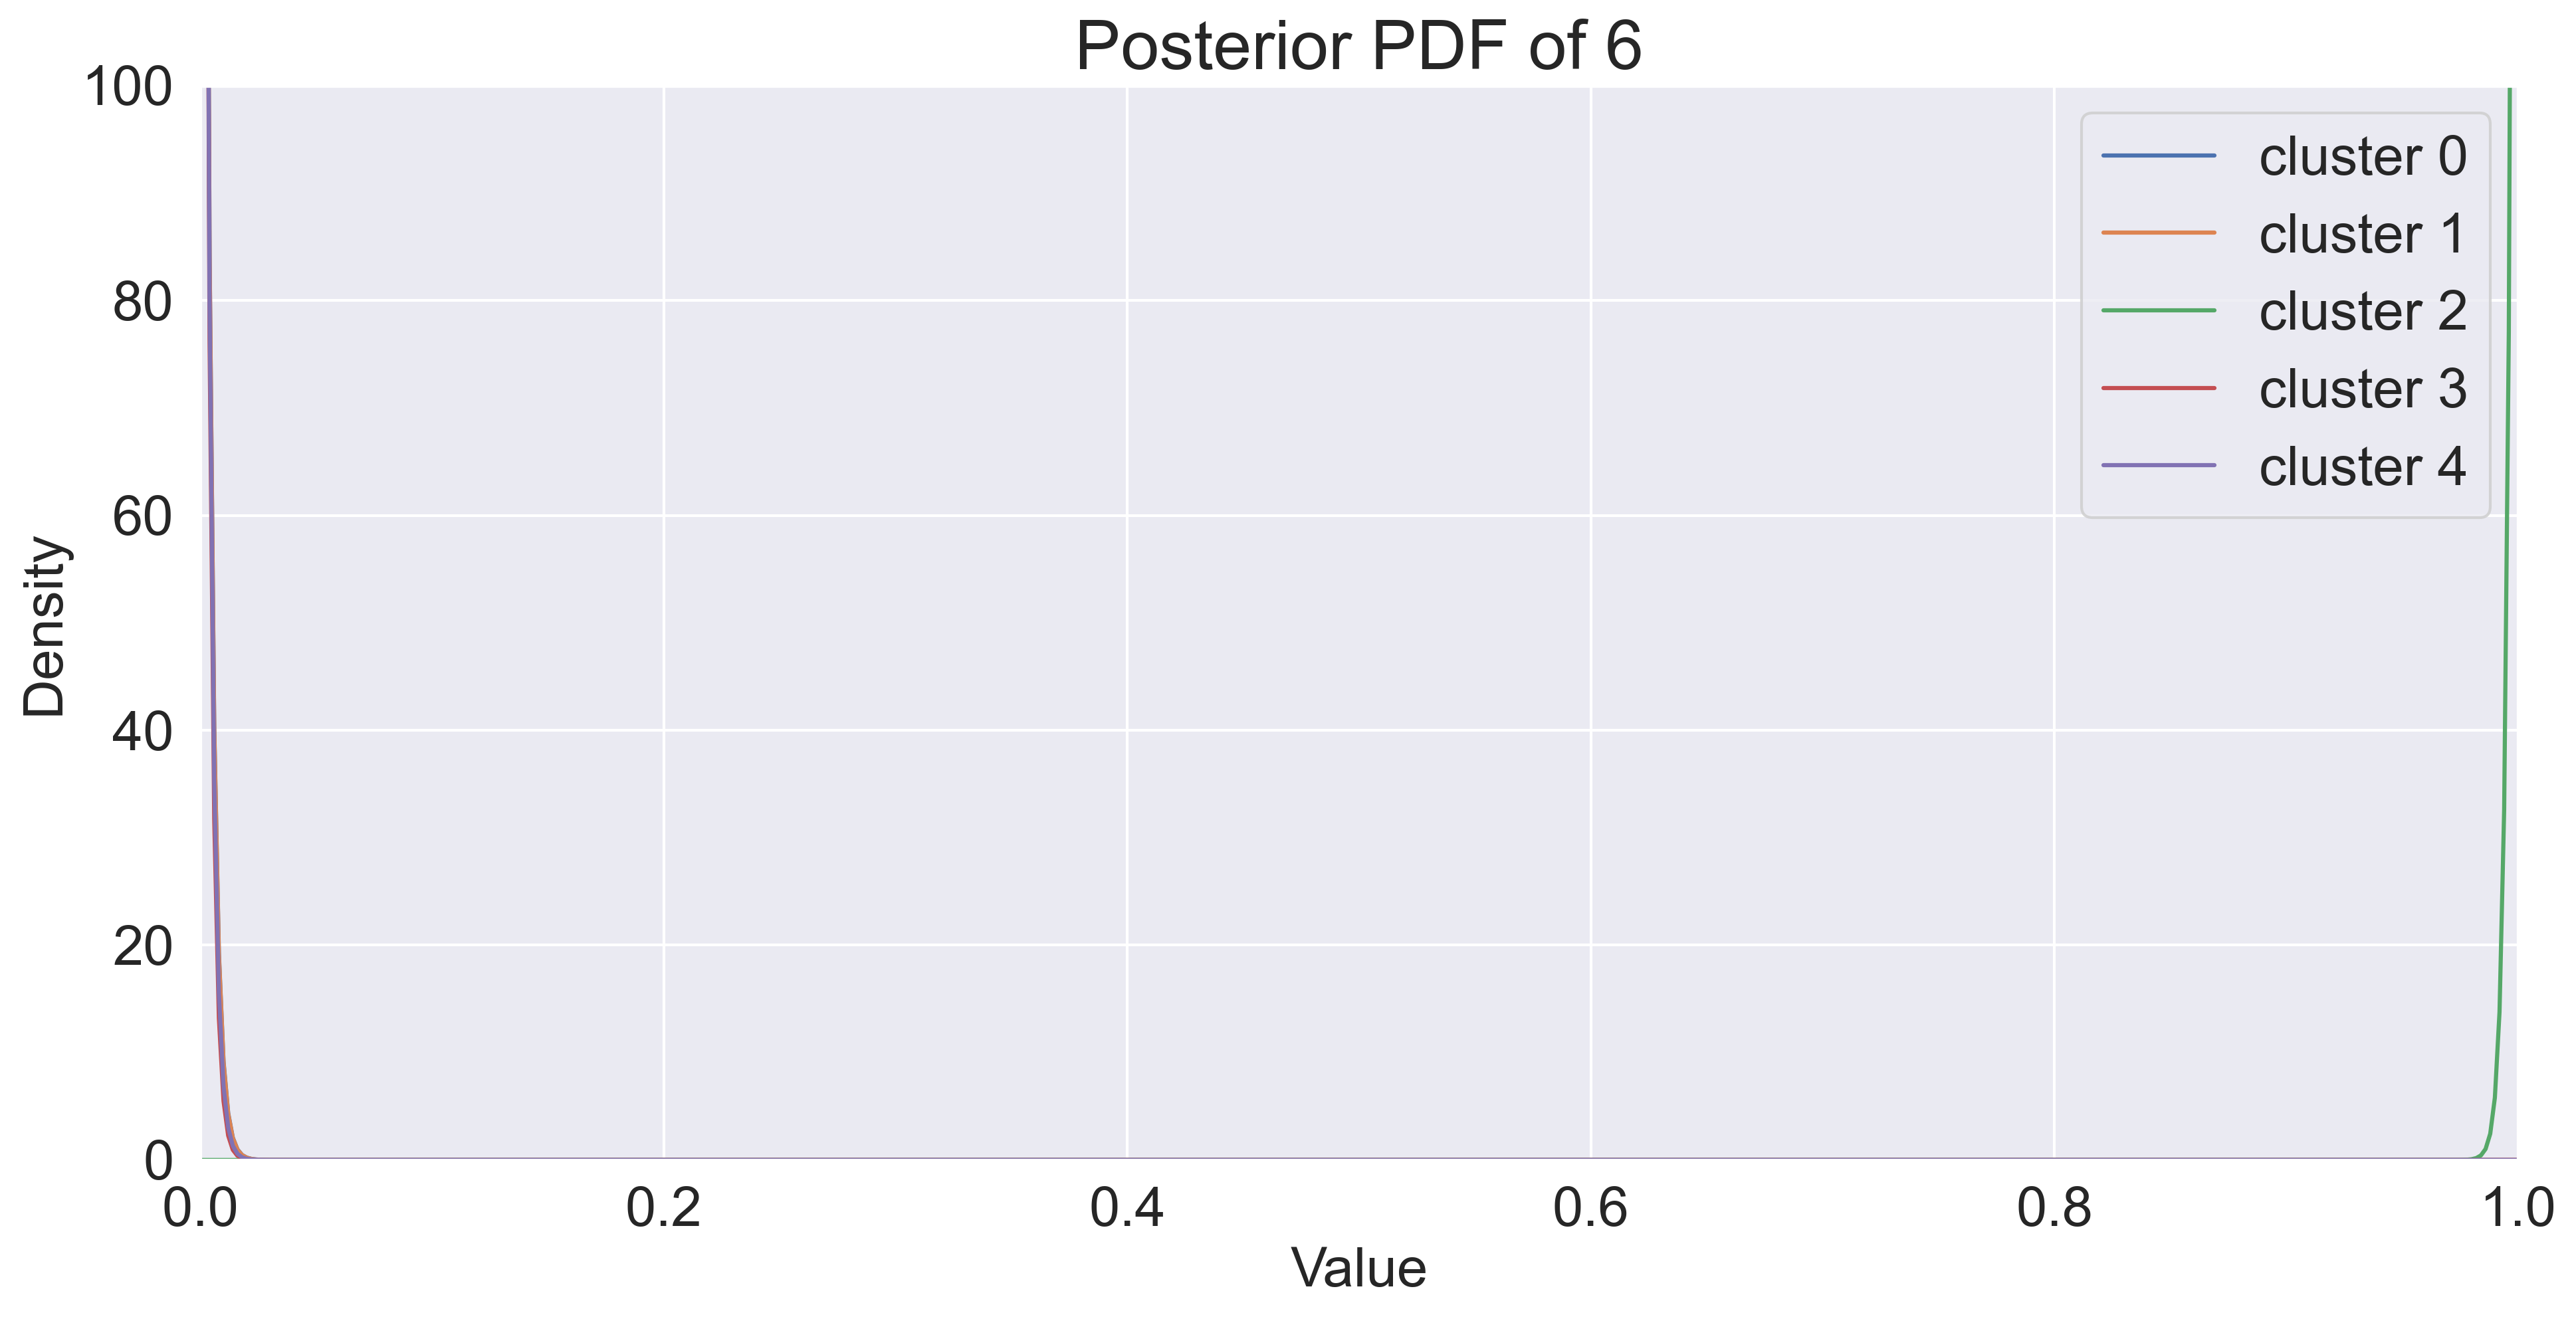

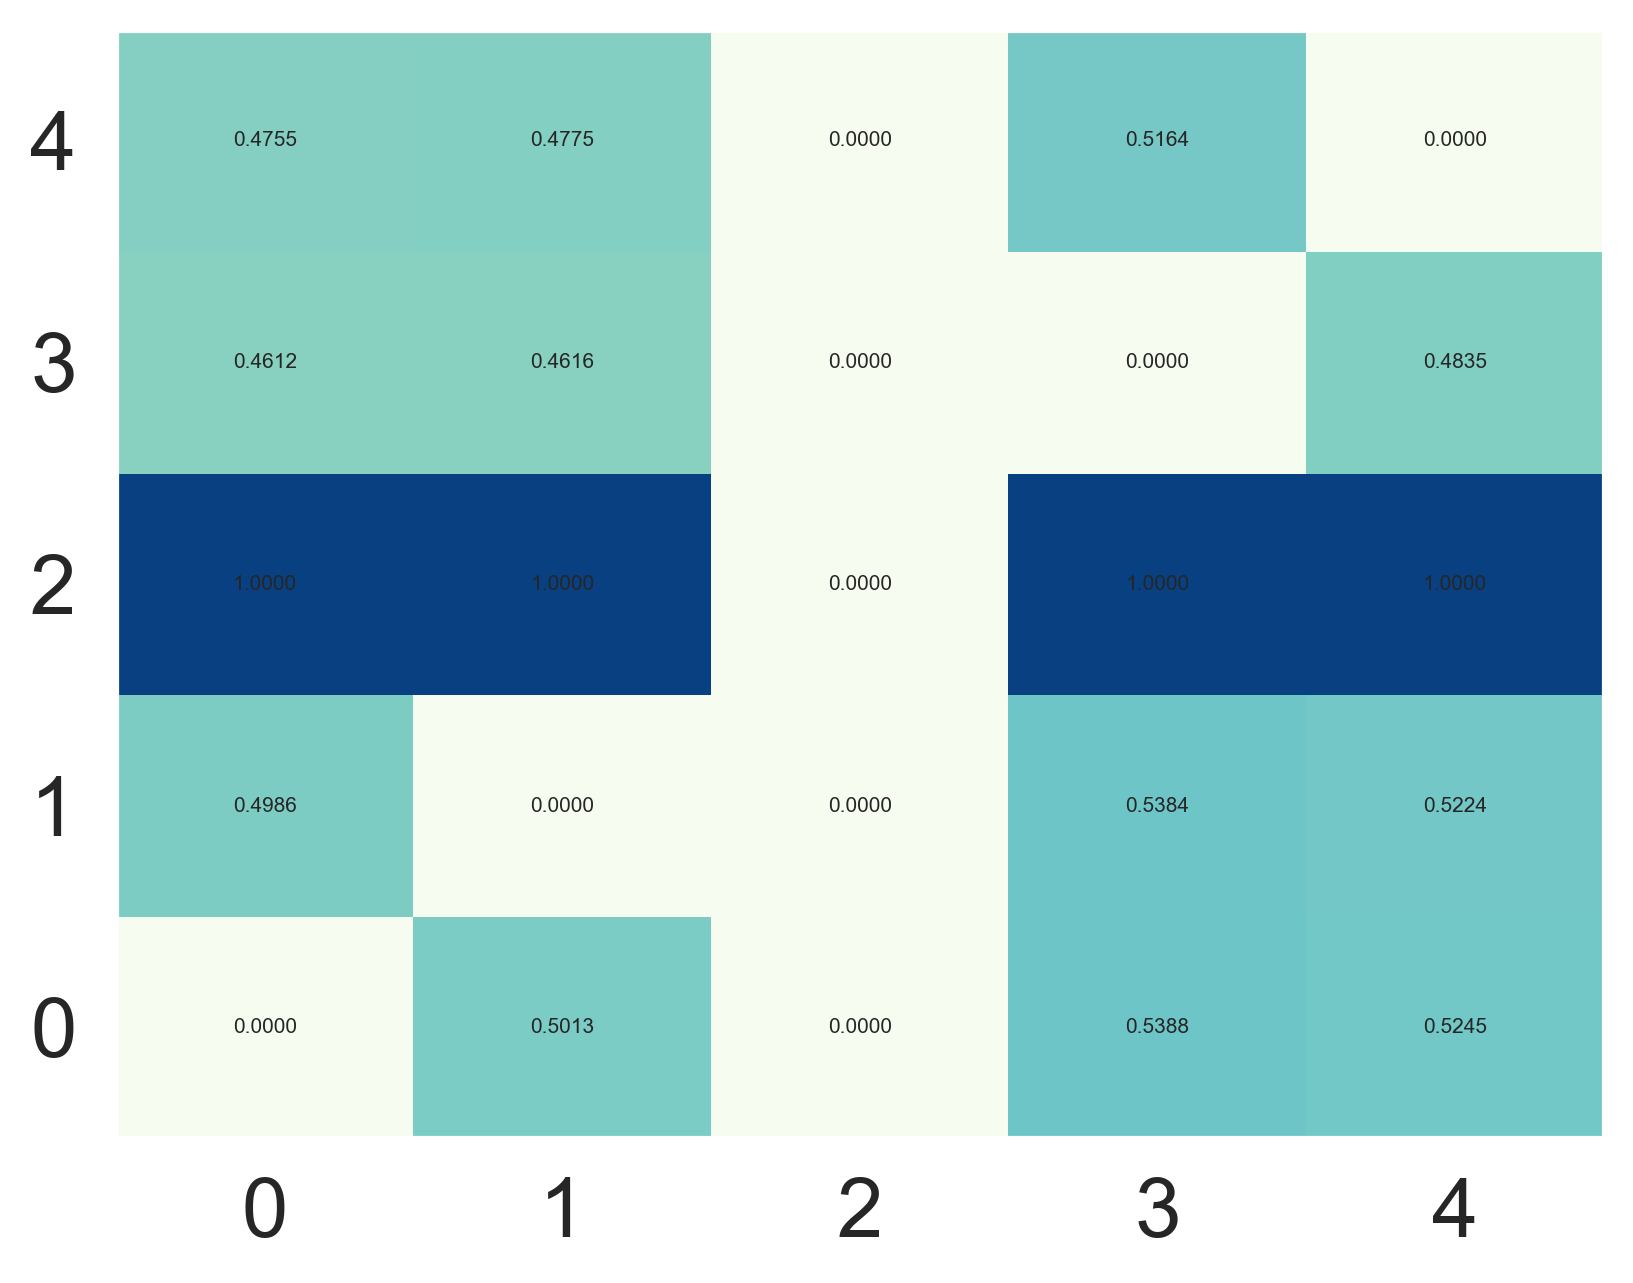

/Users/balbie/Downloads/Thesis/explain_clustering/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:670: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


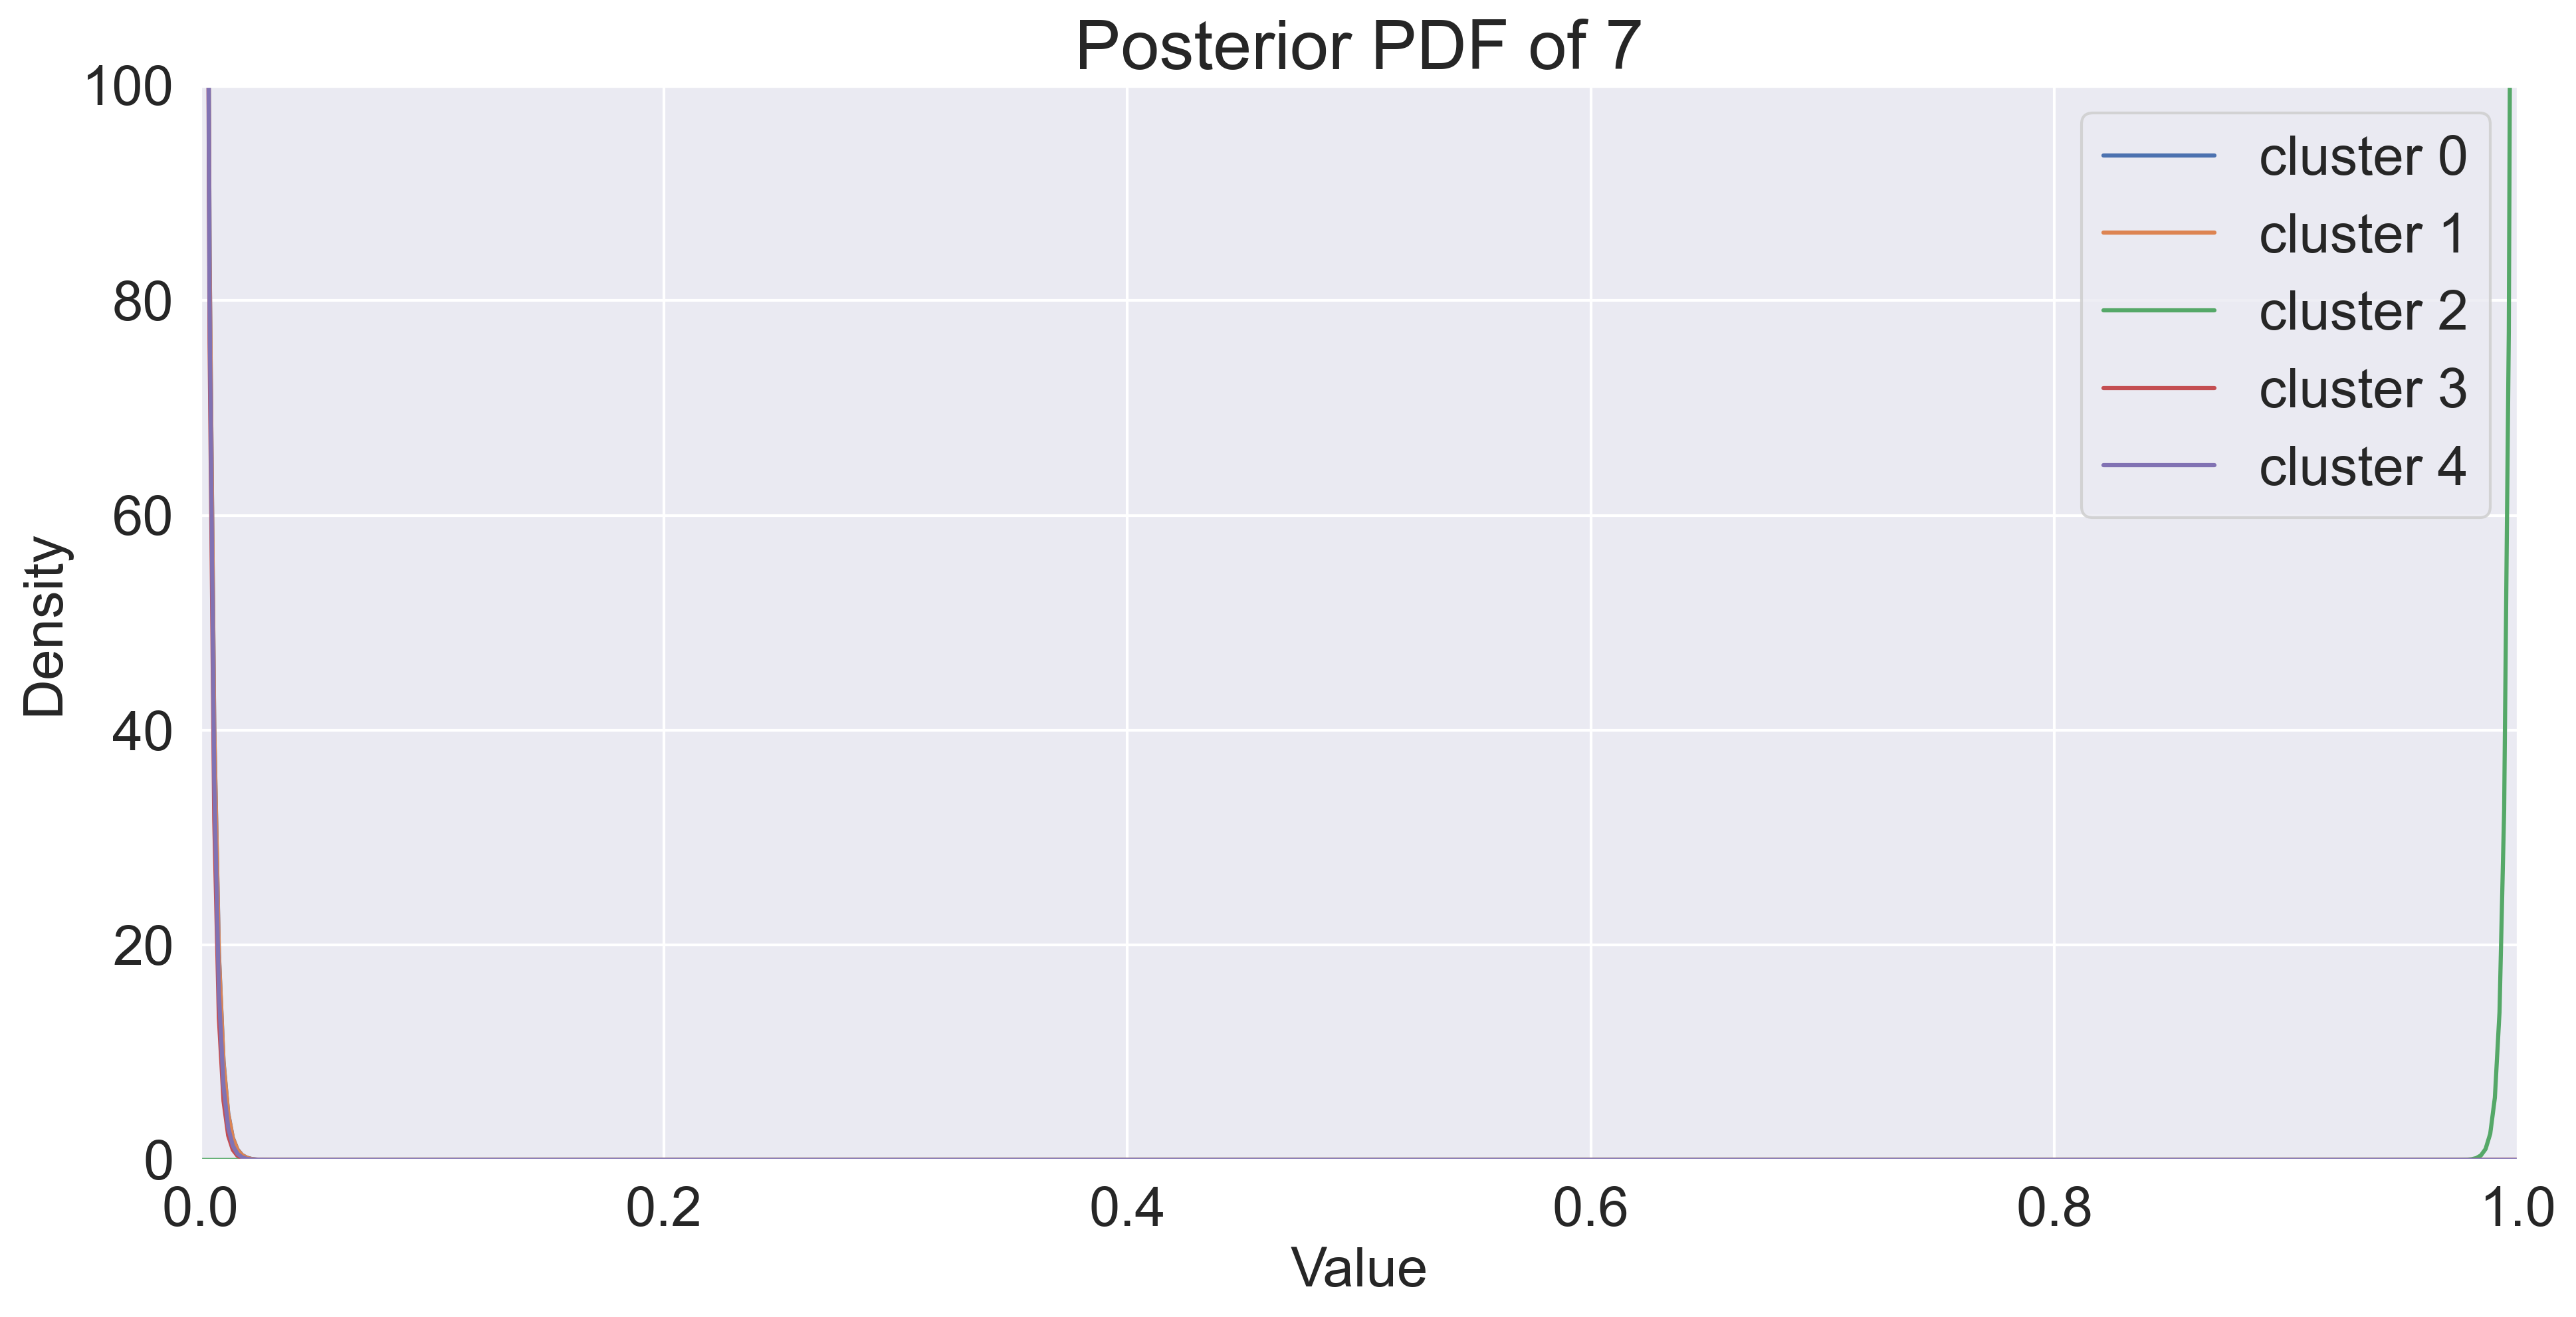

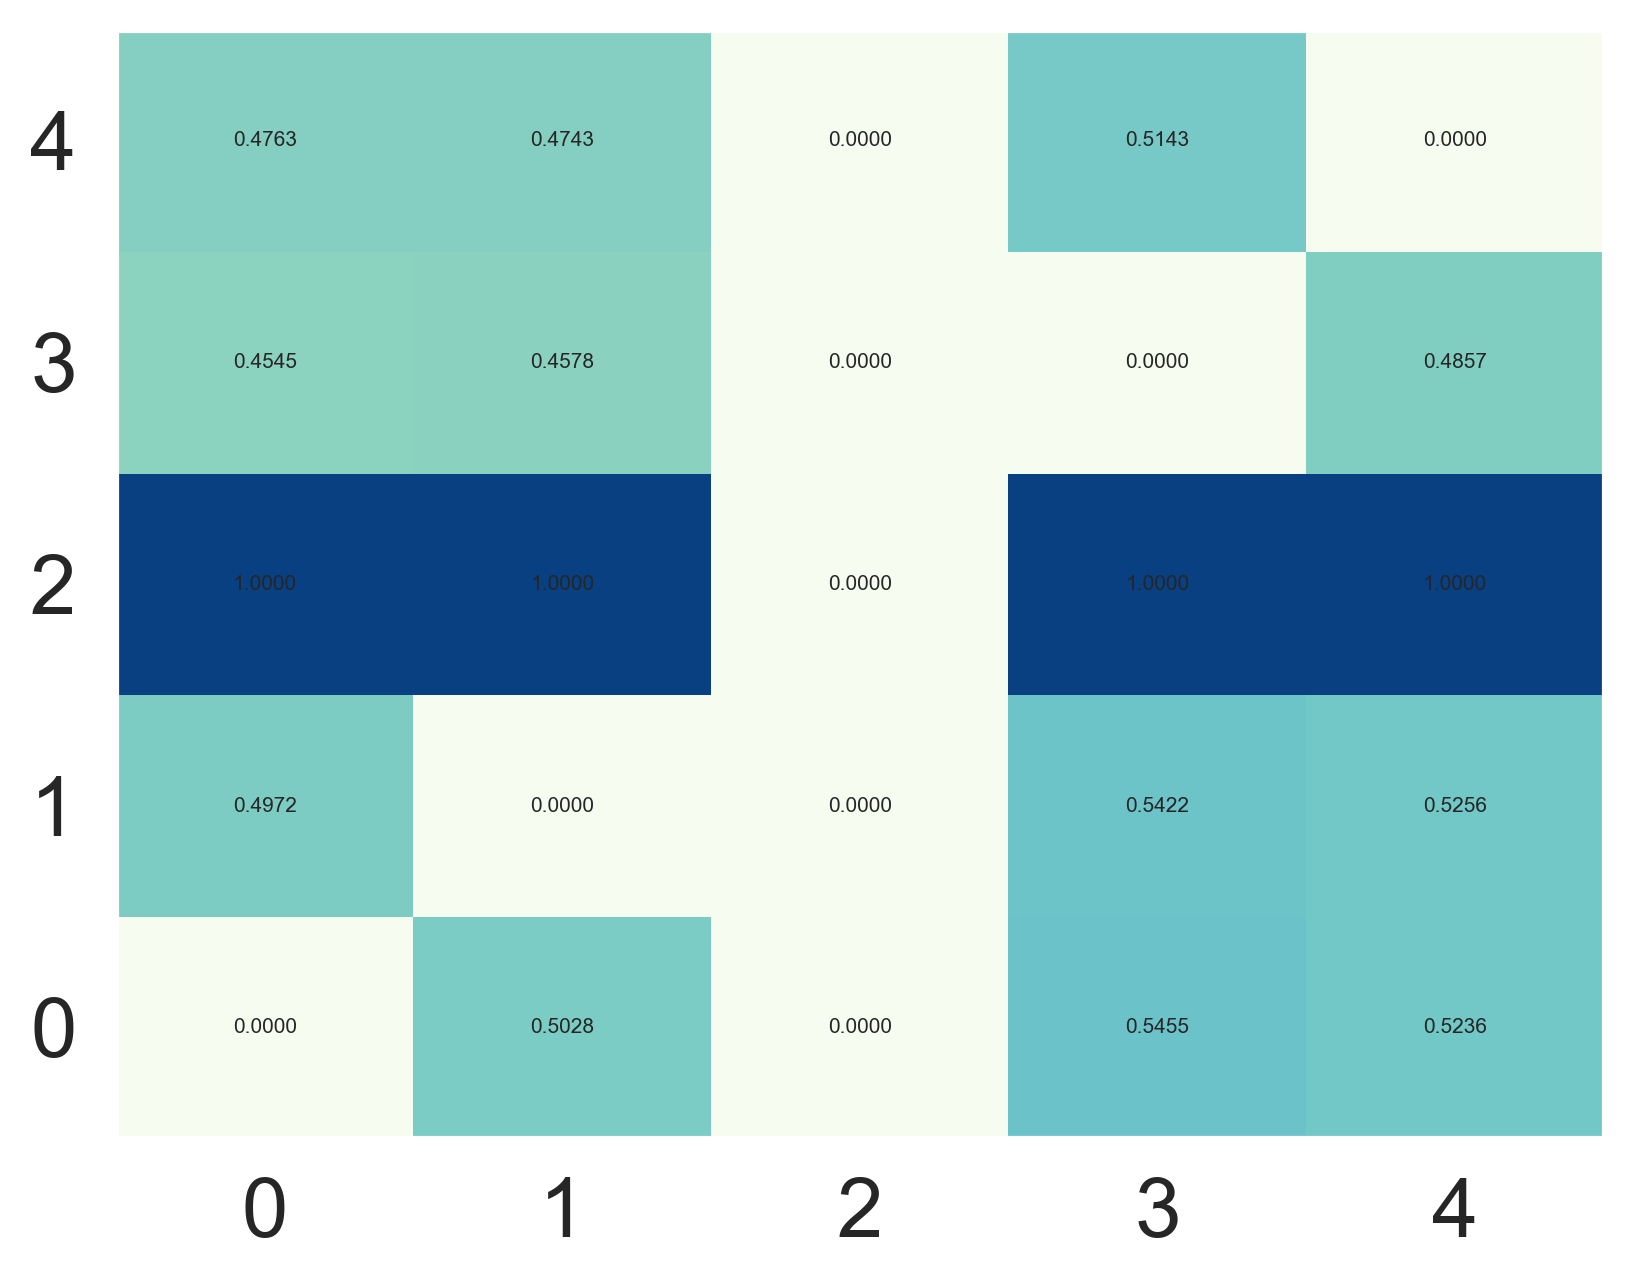

/Users/balbie/Downloads/Thesis/explain_clustering/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:670: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


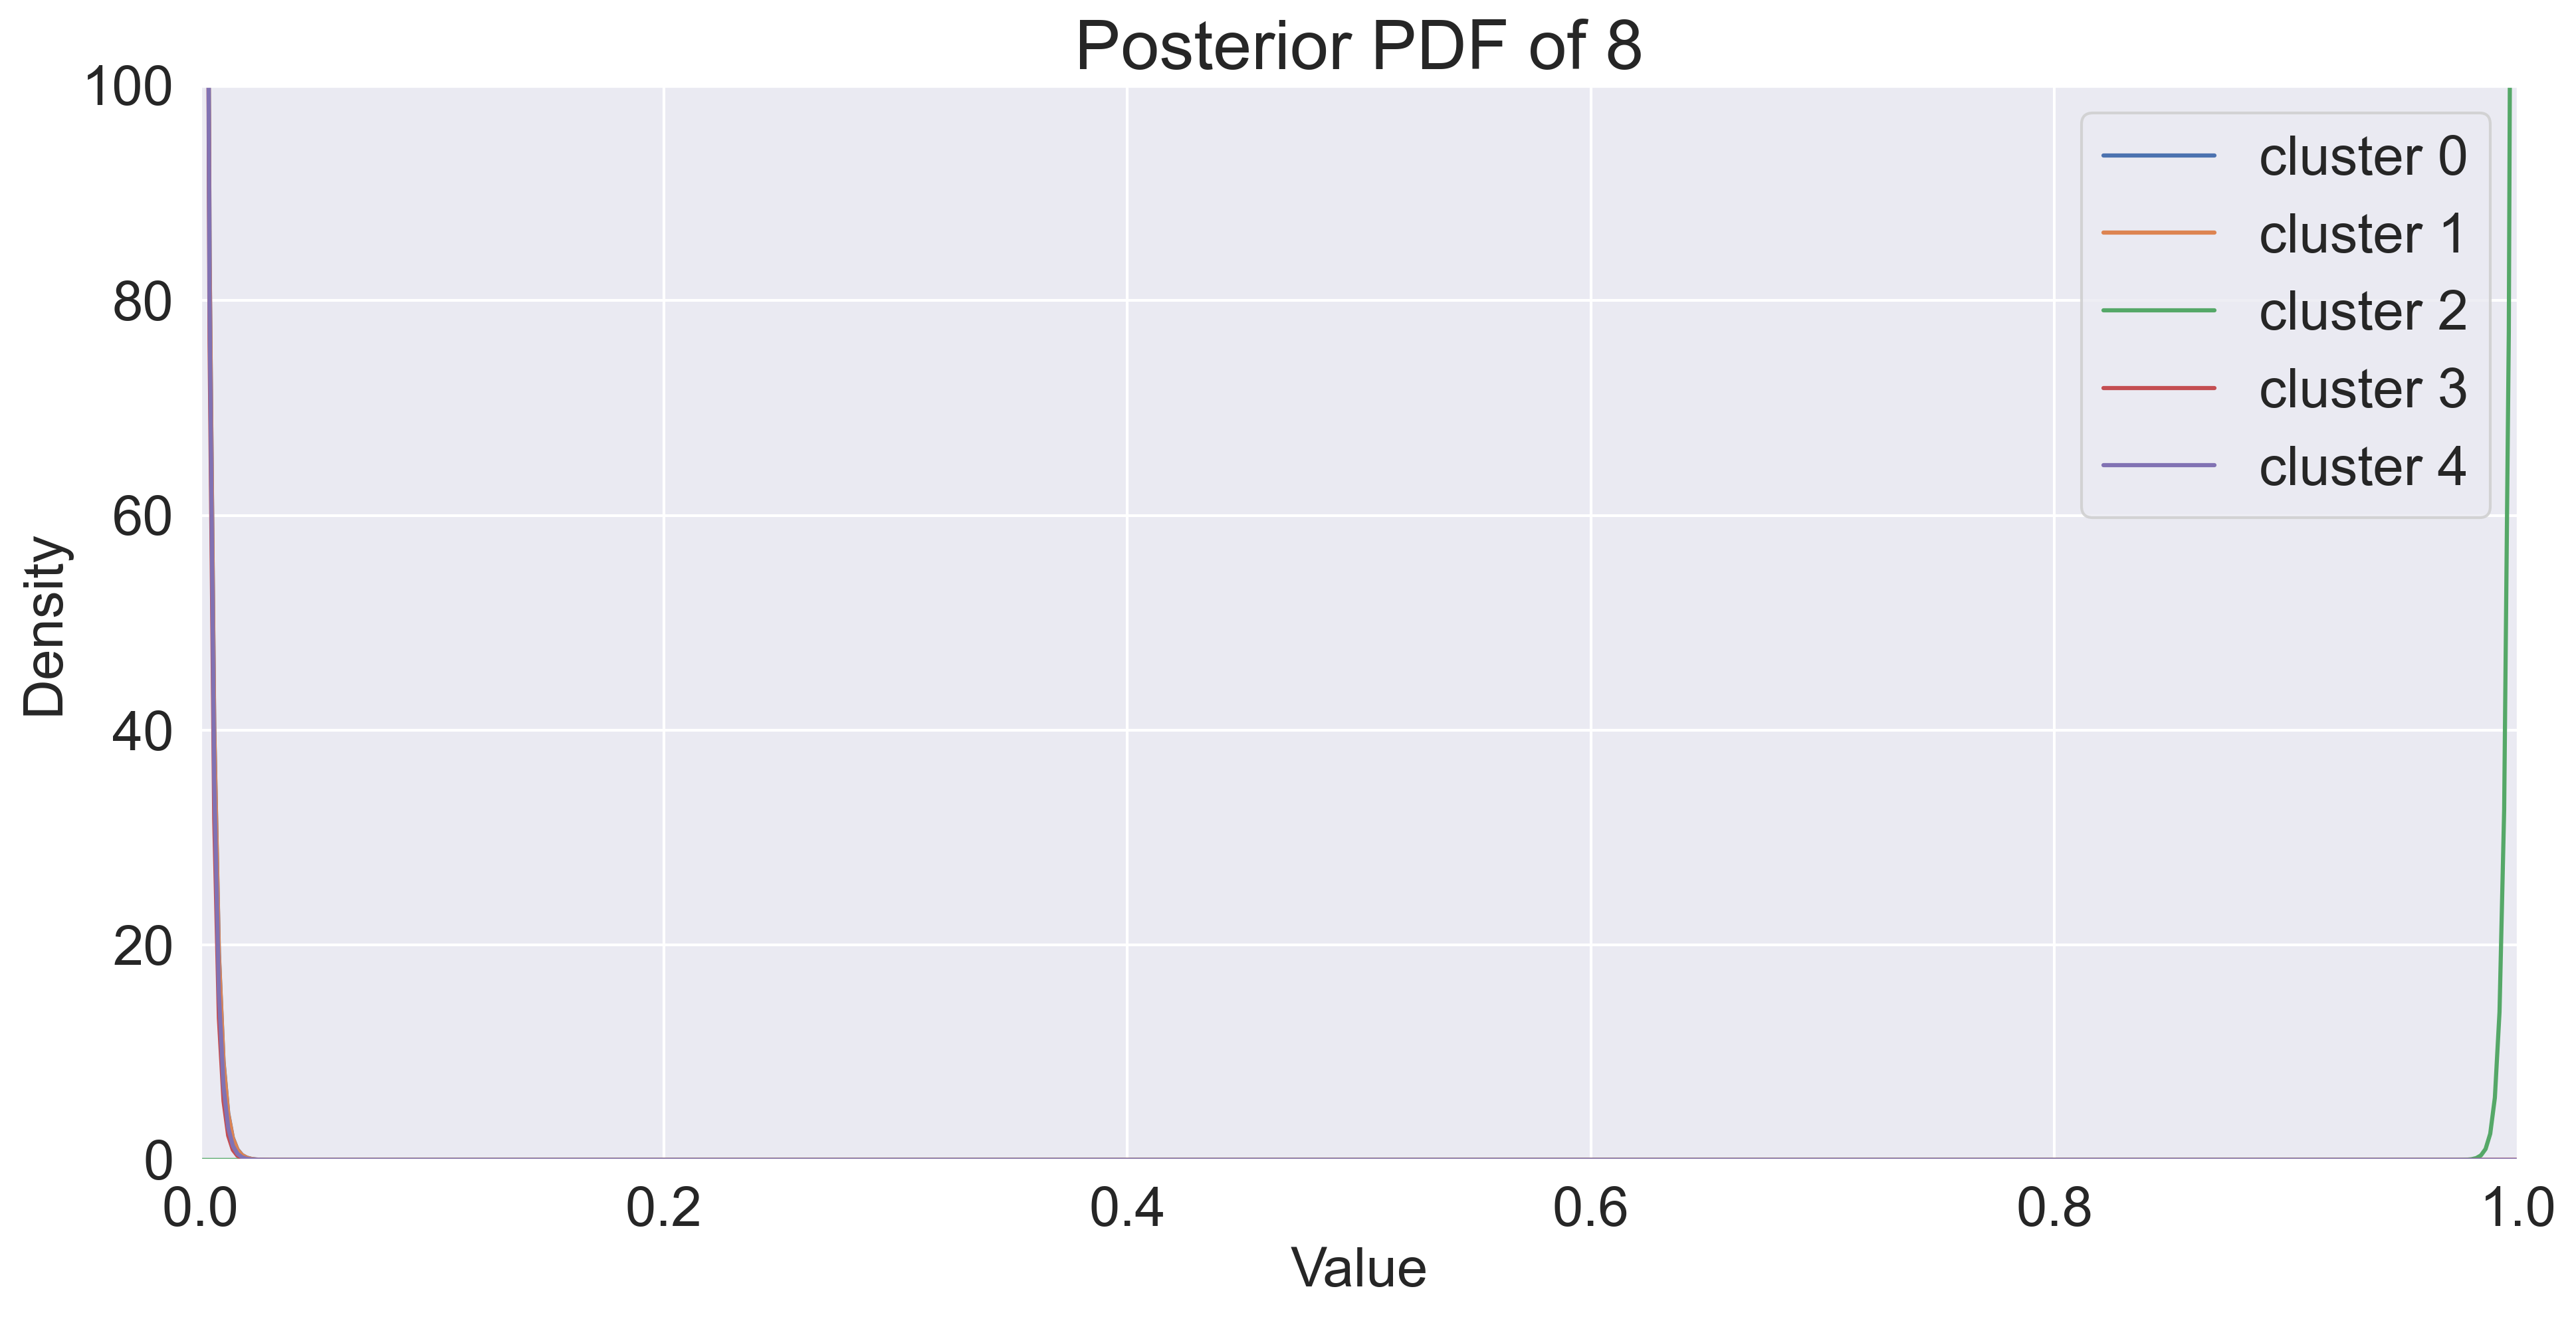

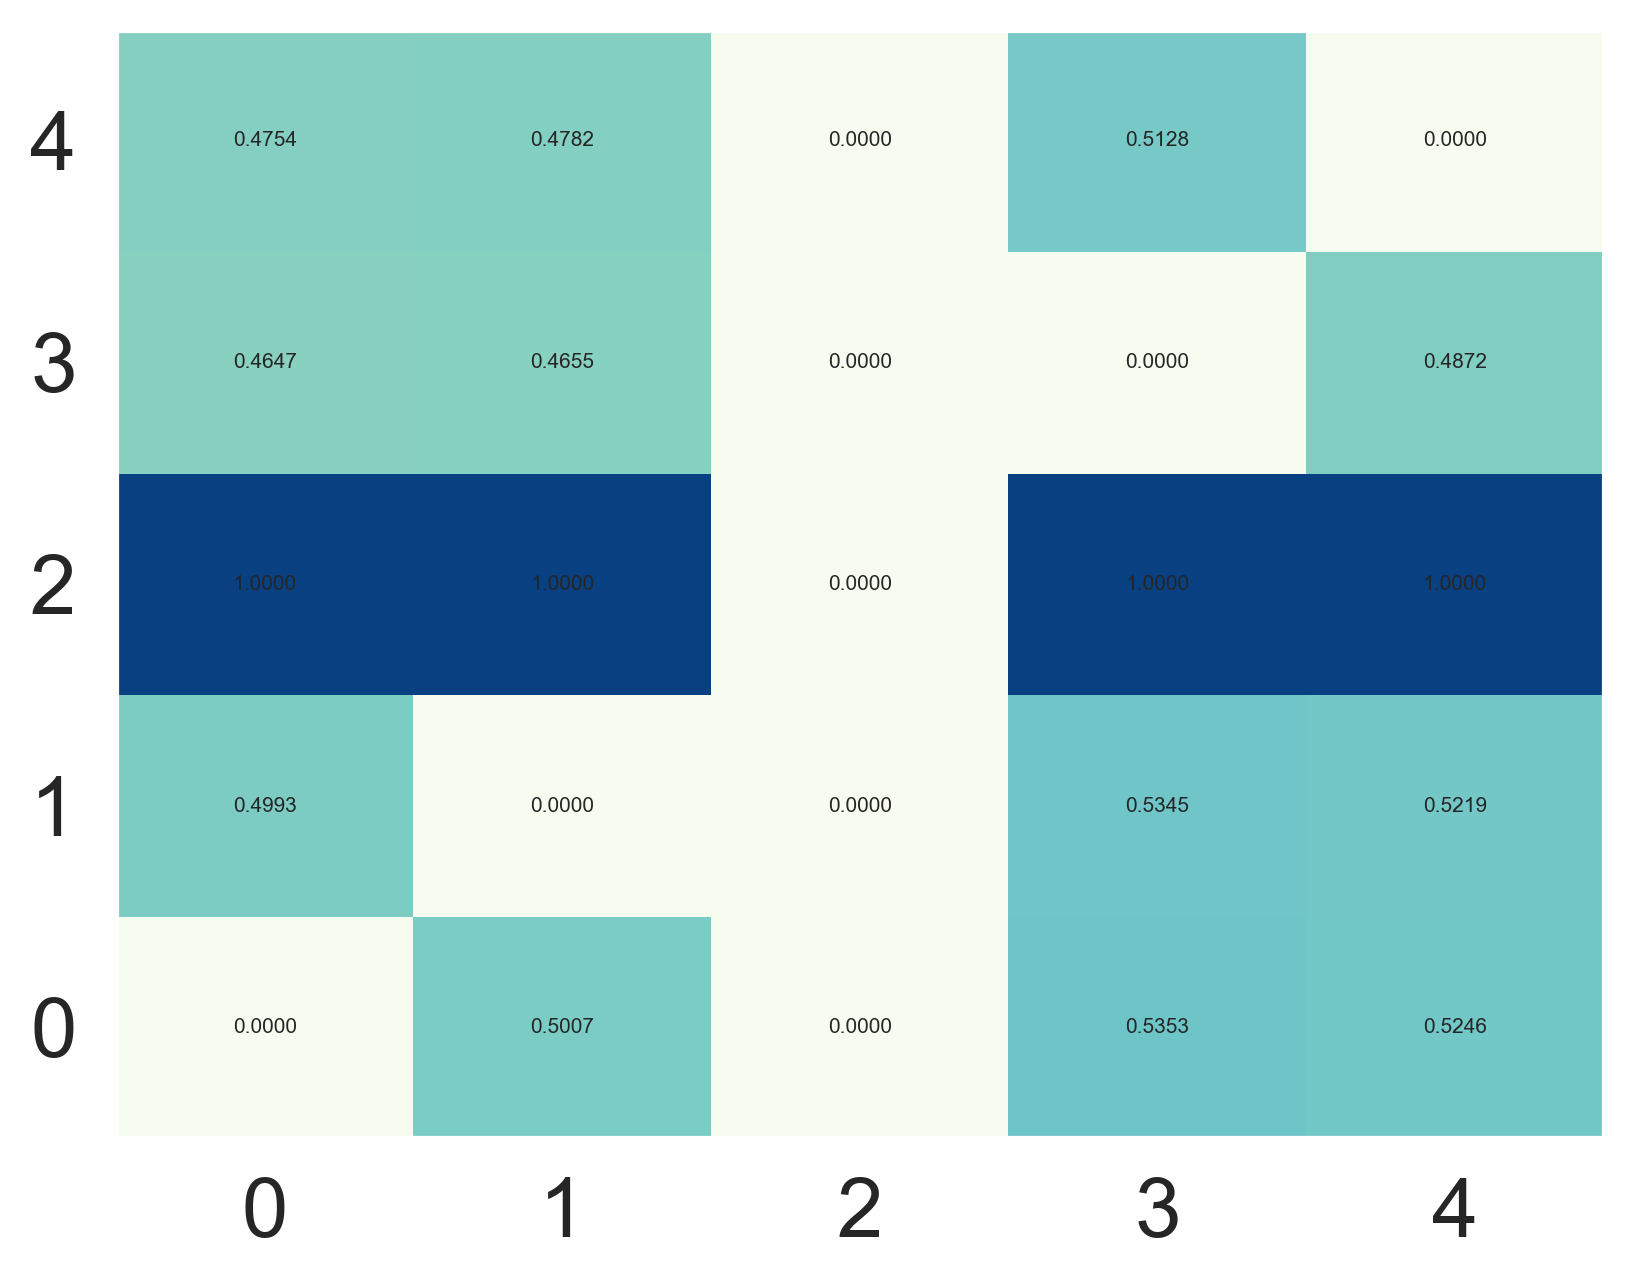

/Users/balbie/Downloads/Thesis/explain_clustering/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:670: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


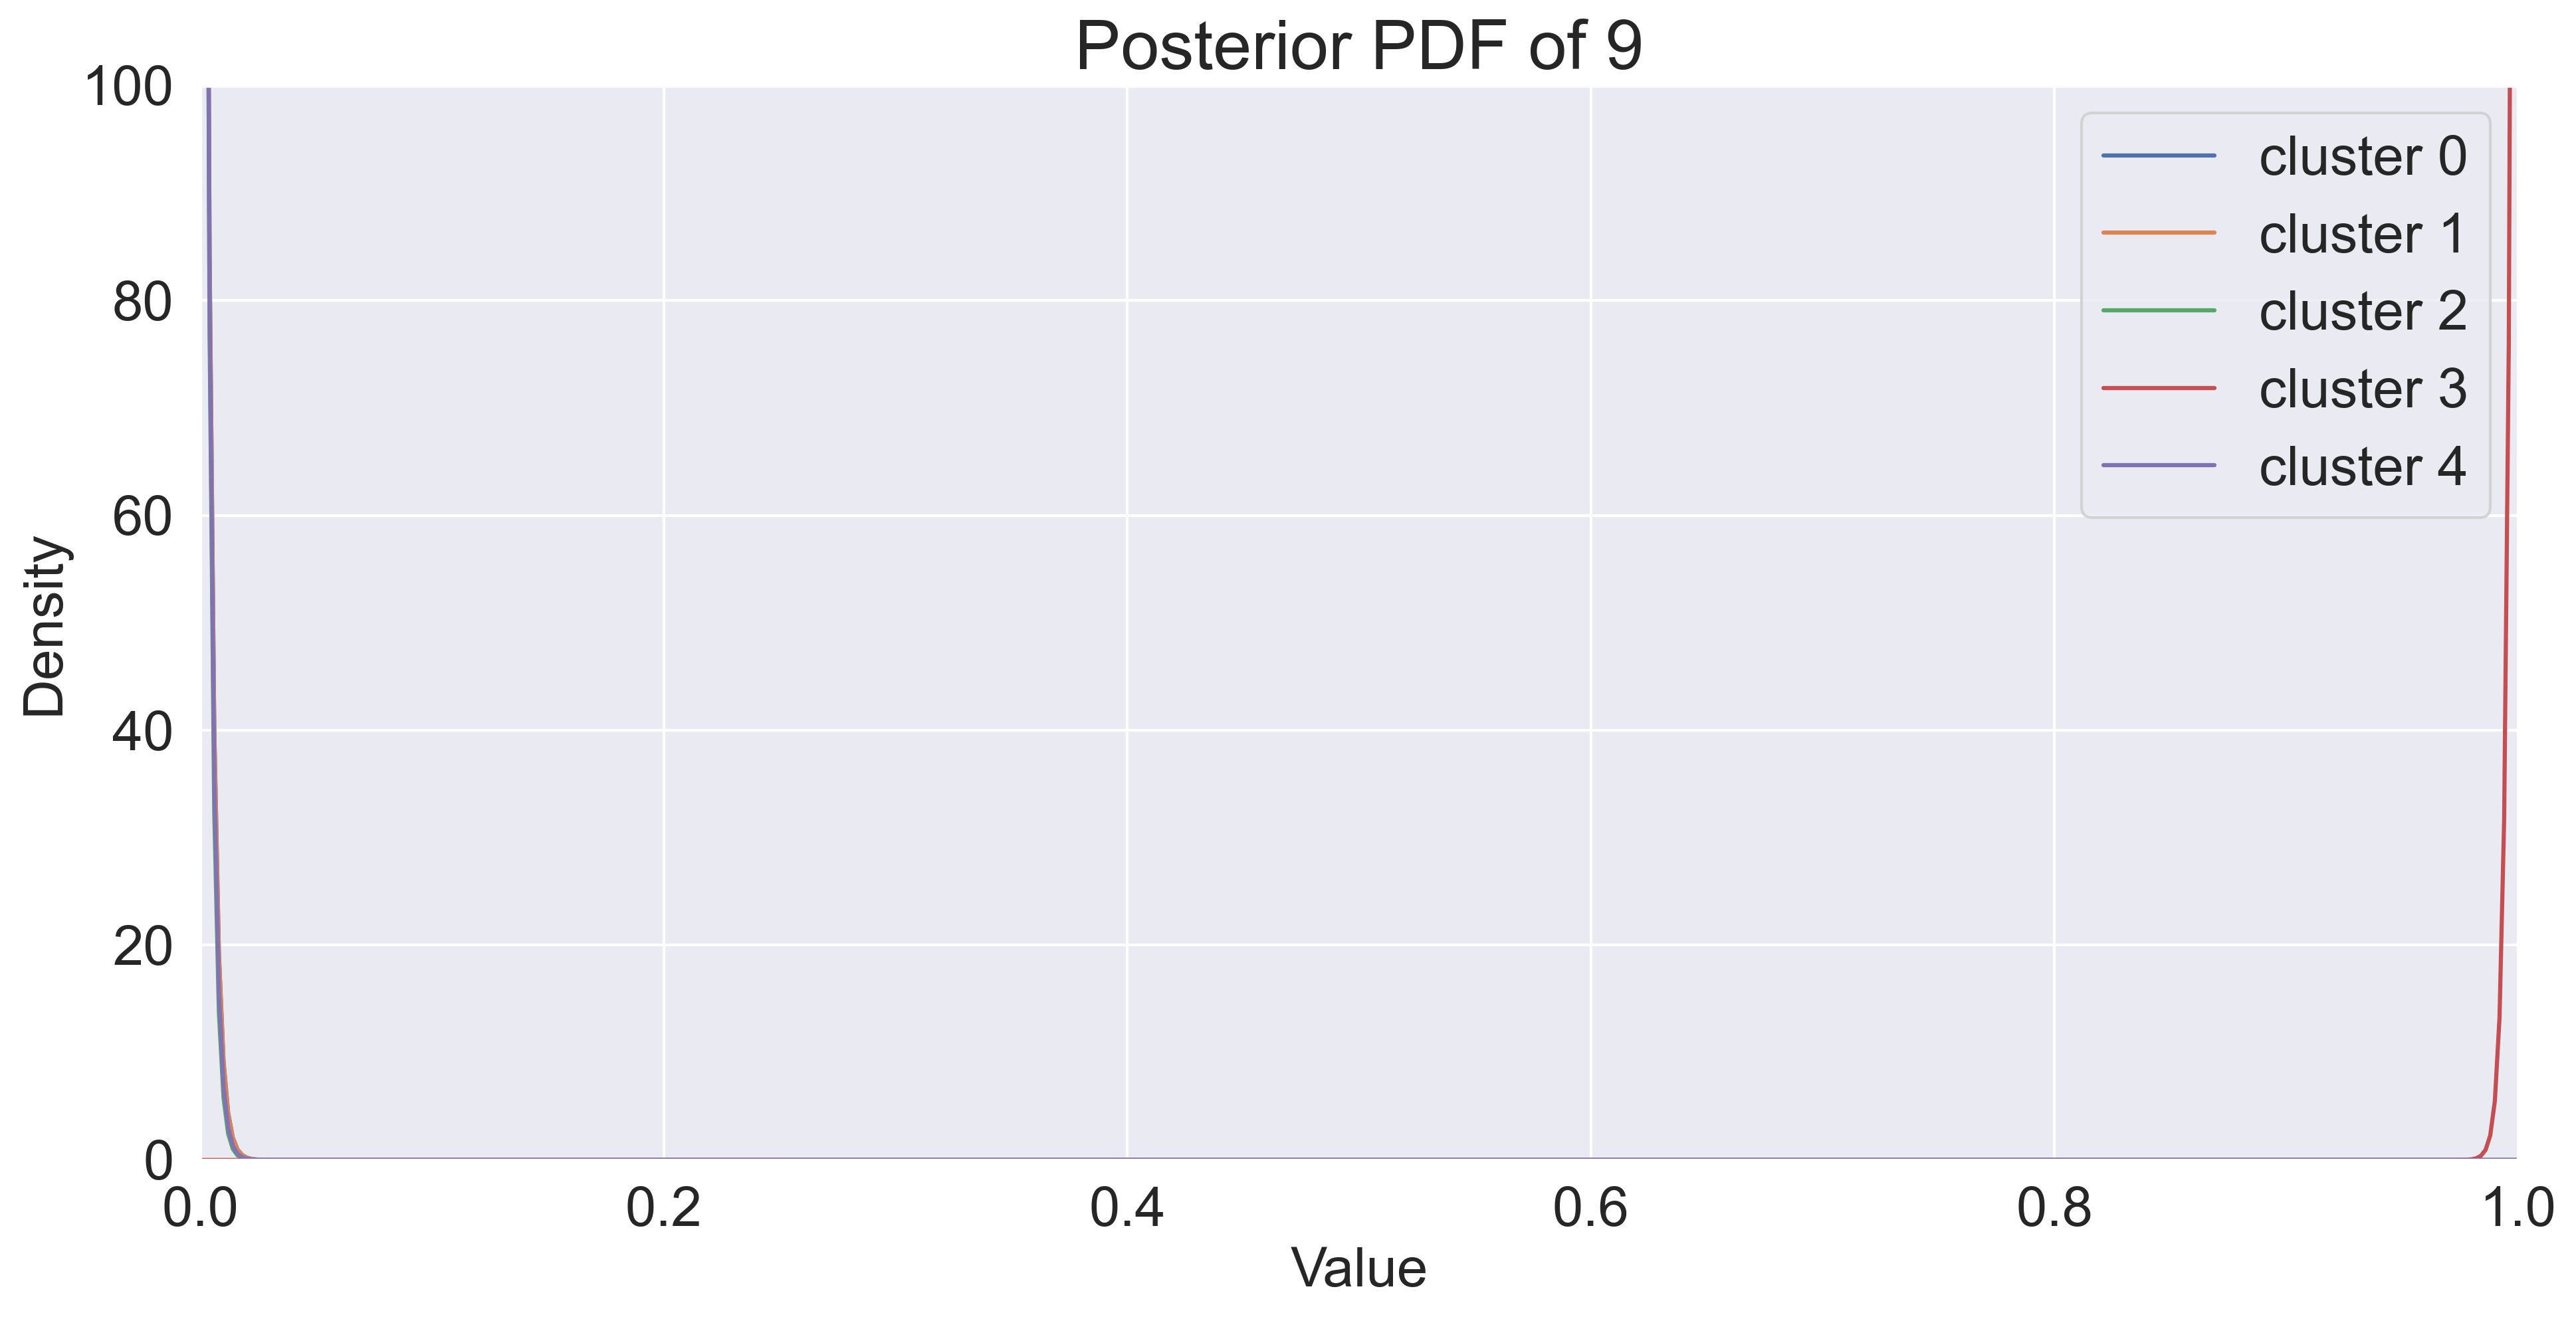

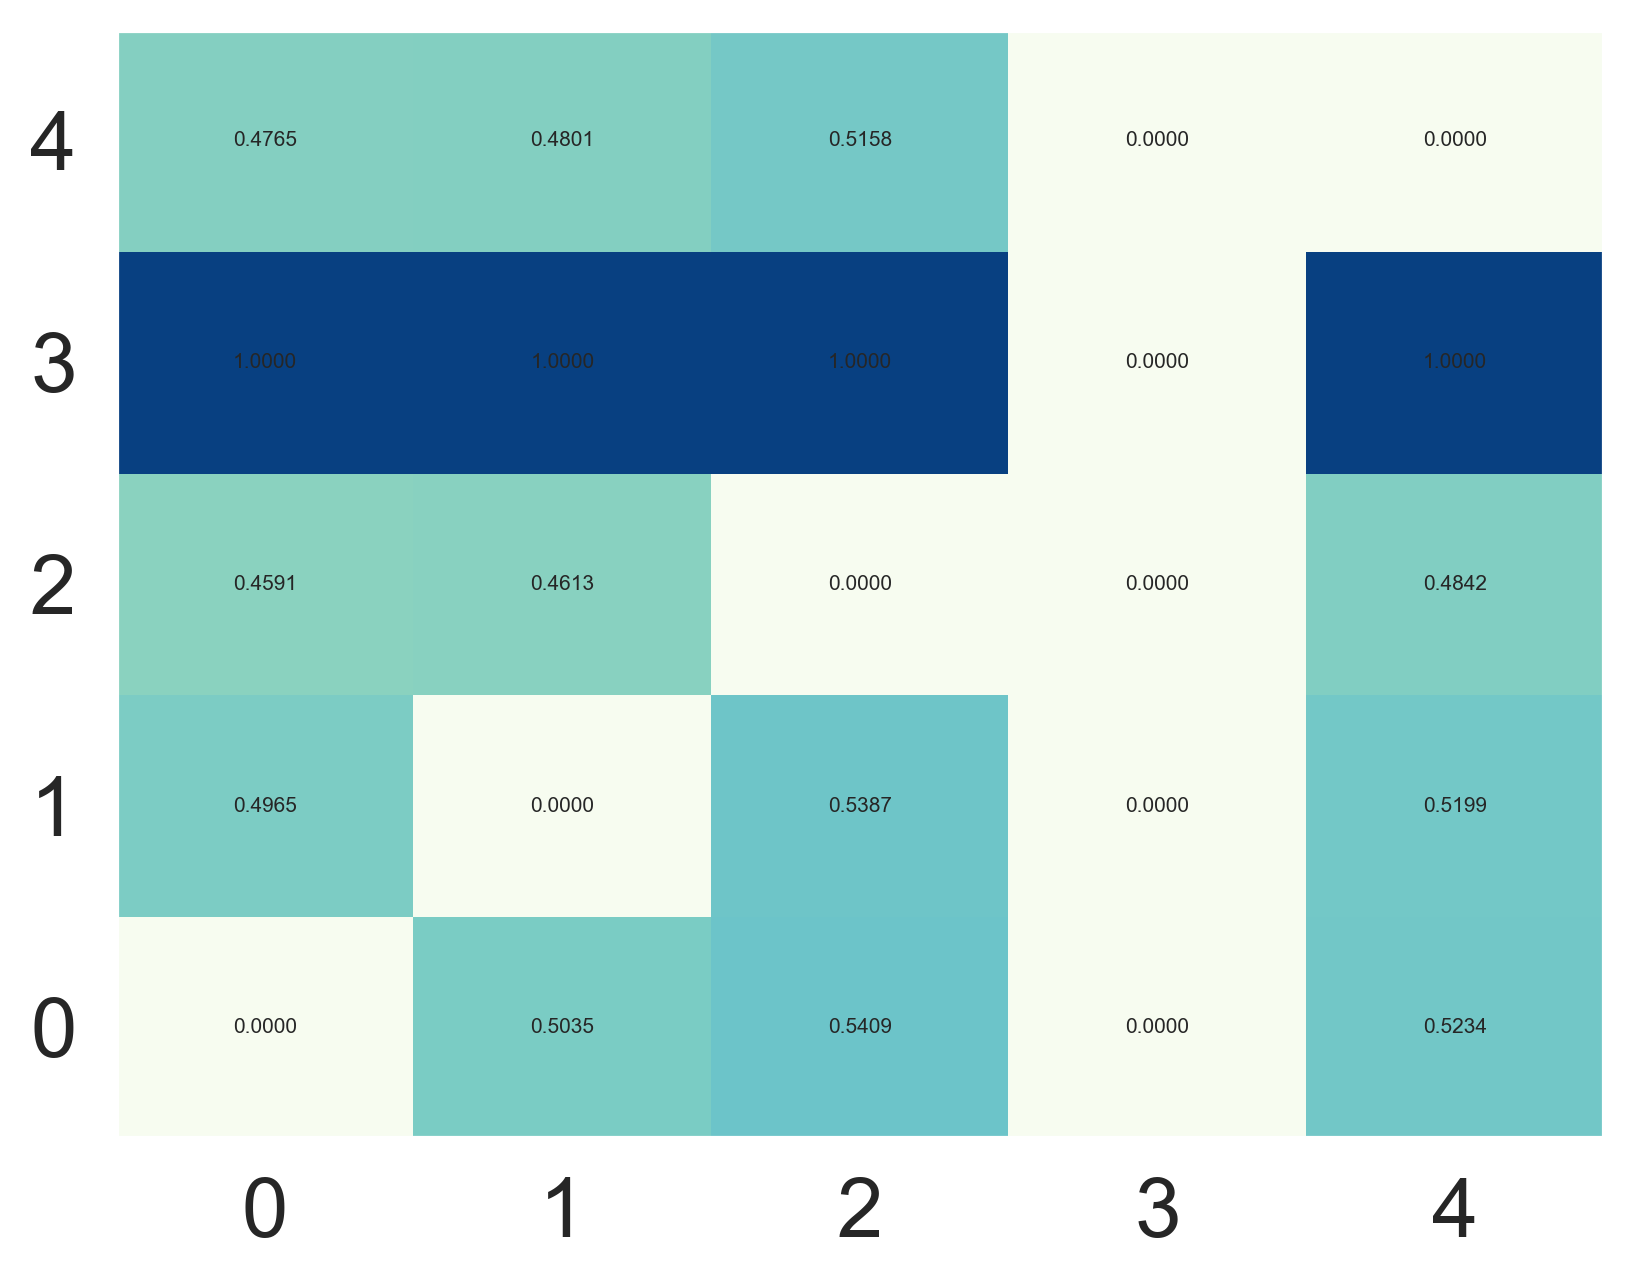

/Users/balbie/Downloads/Thesis/explain_clustering/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:670: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


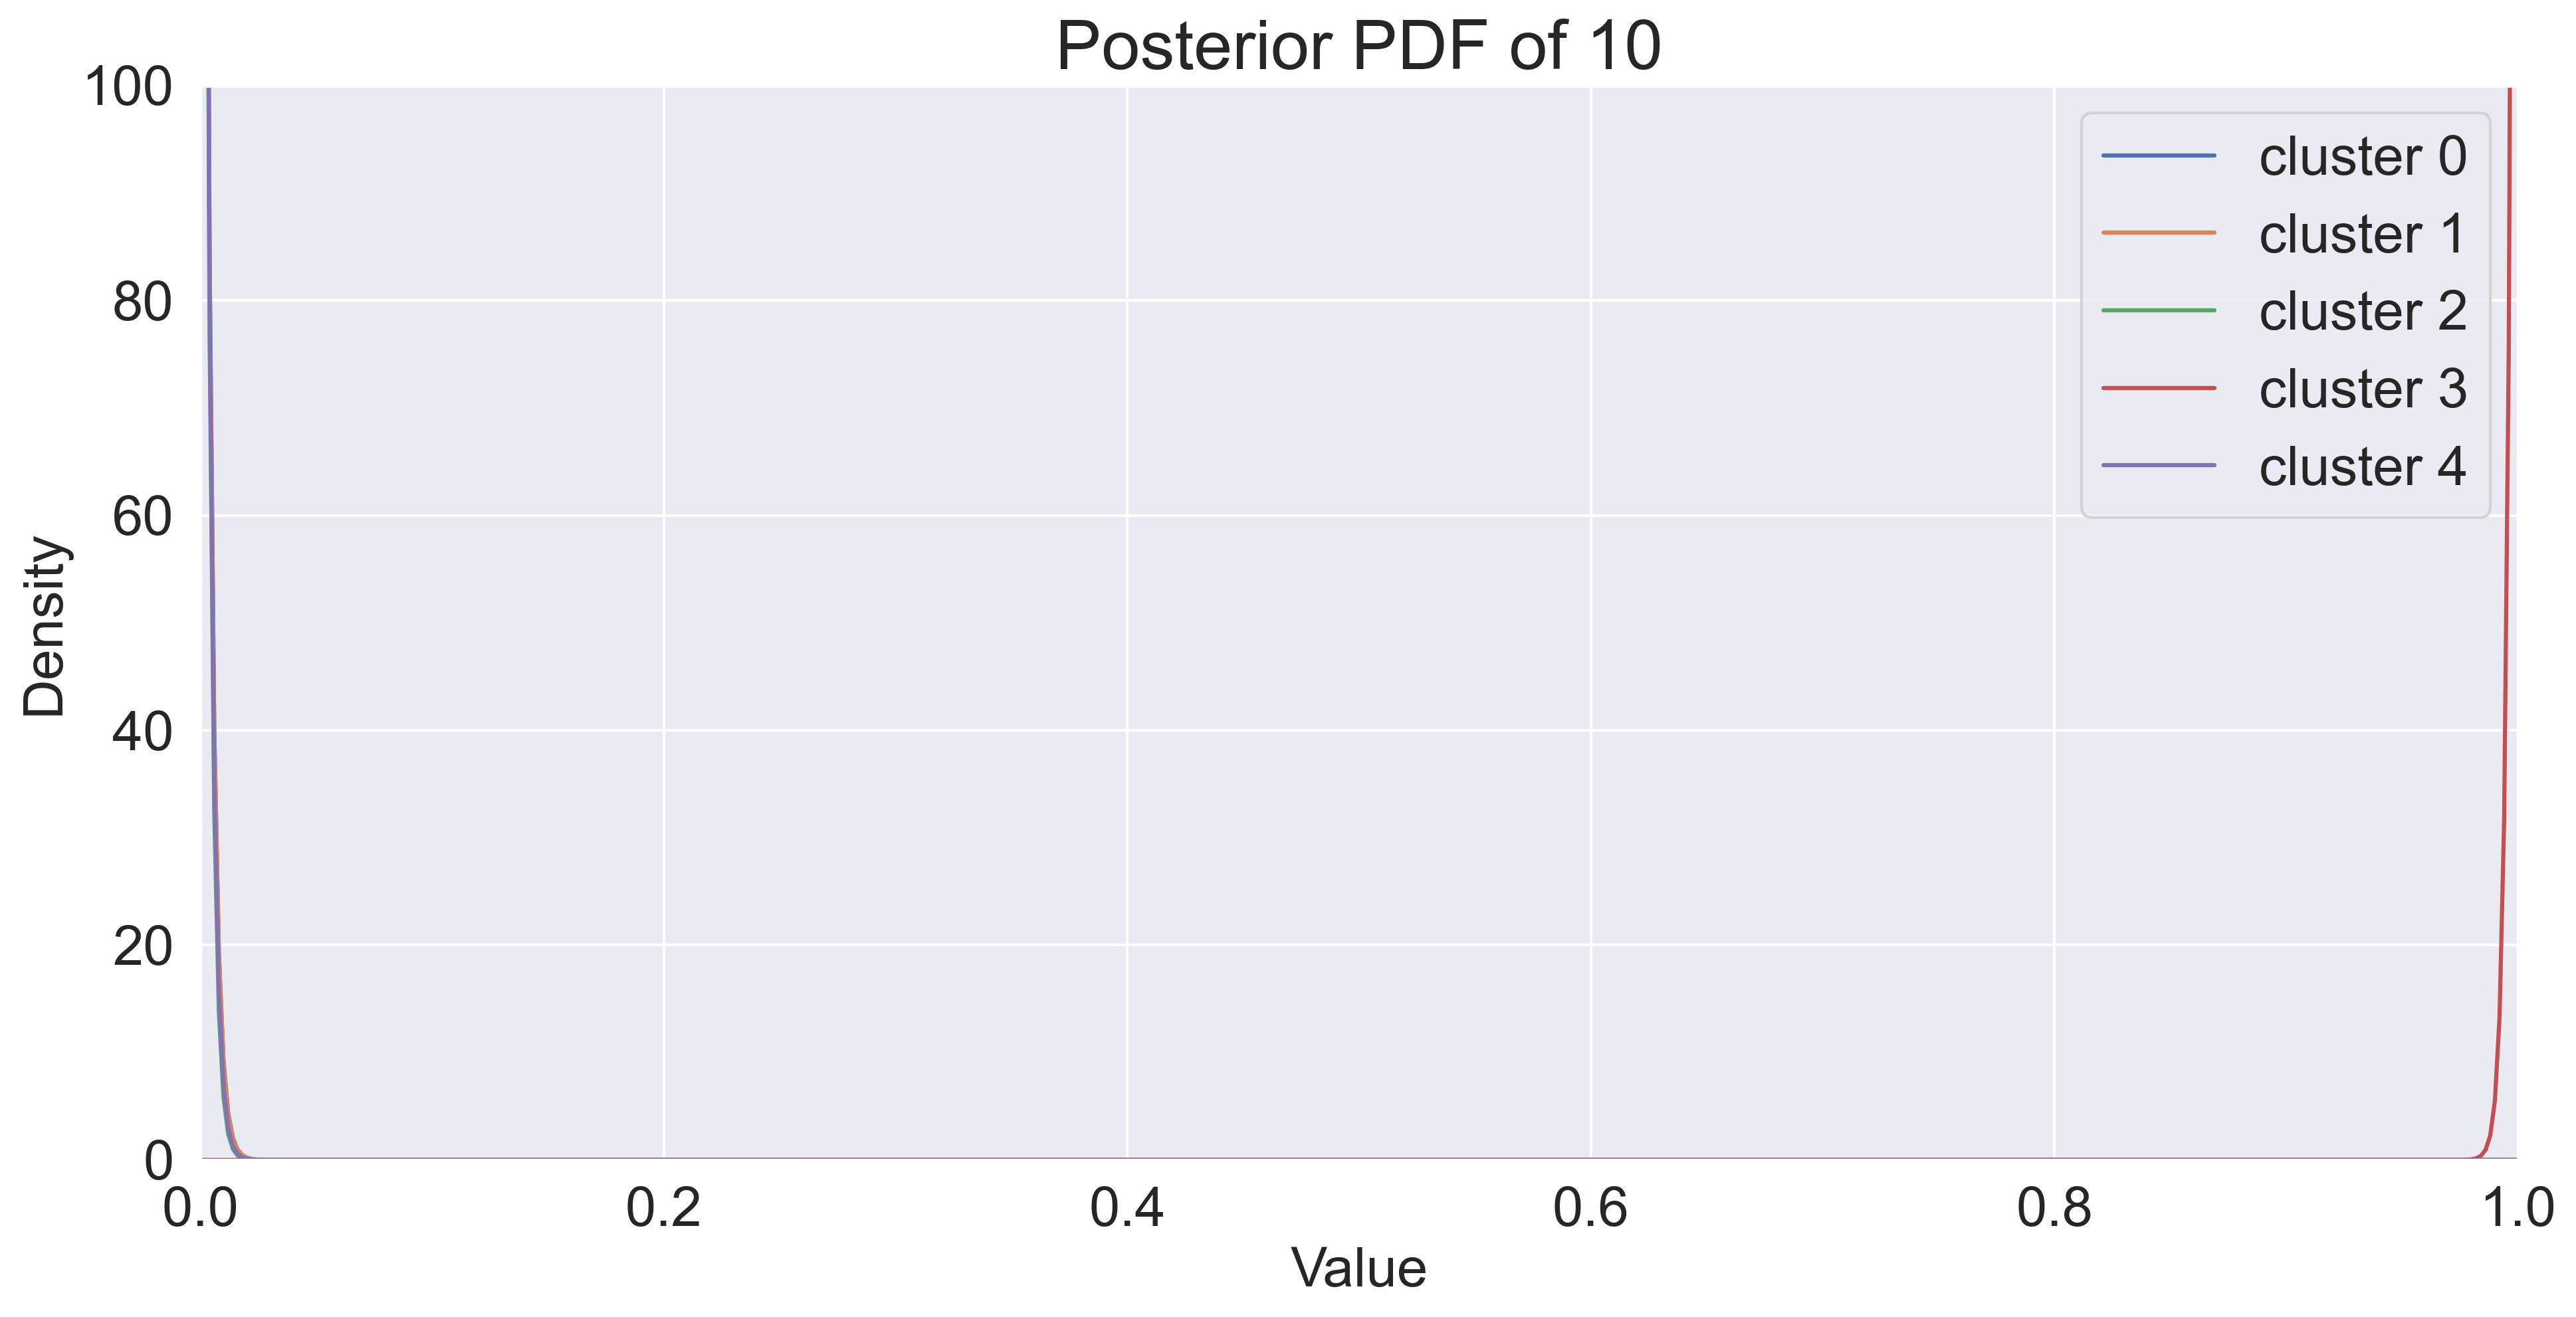

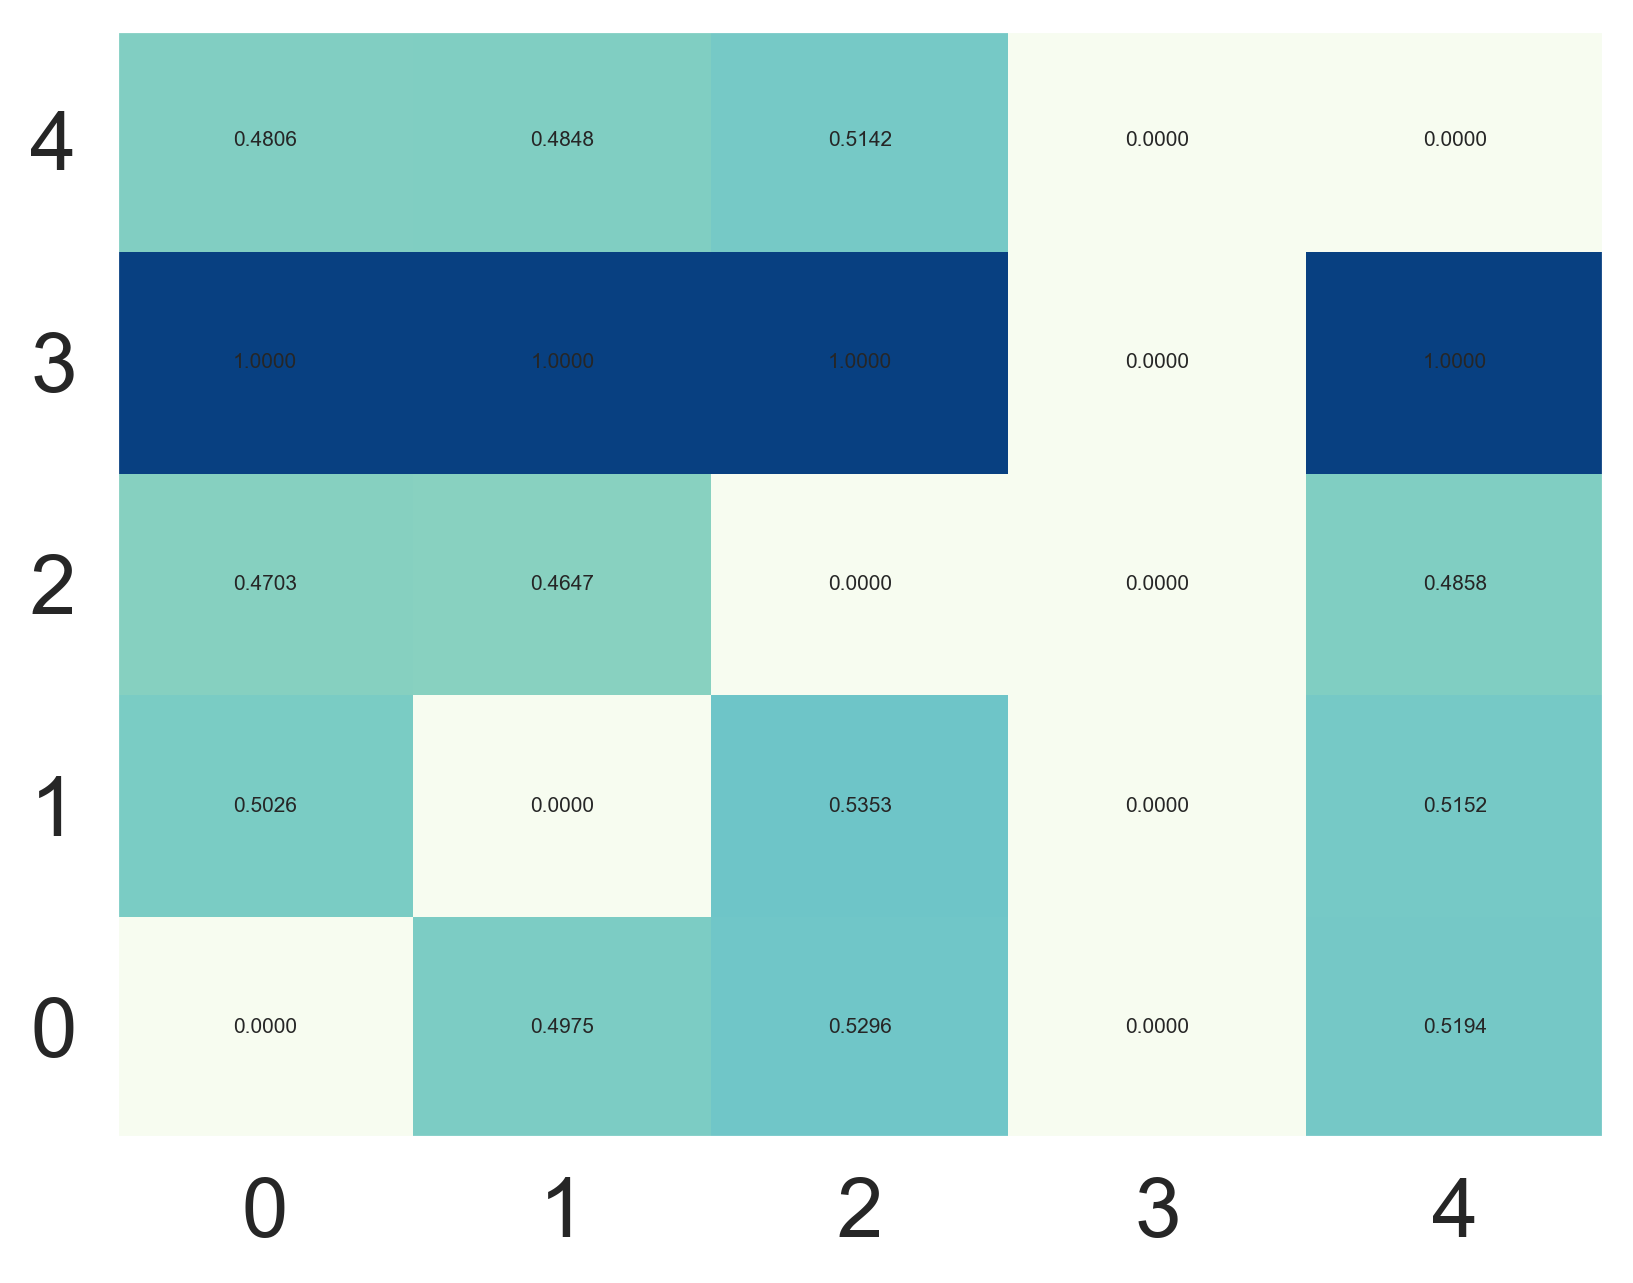

/Users/balbie/Downloads/Thesis/explain_clustering/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:670: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


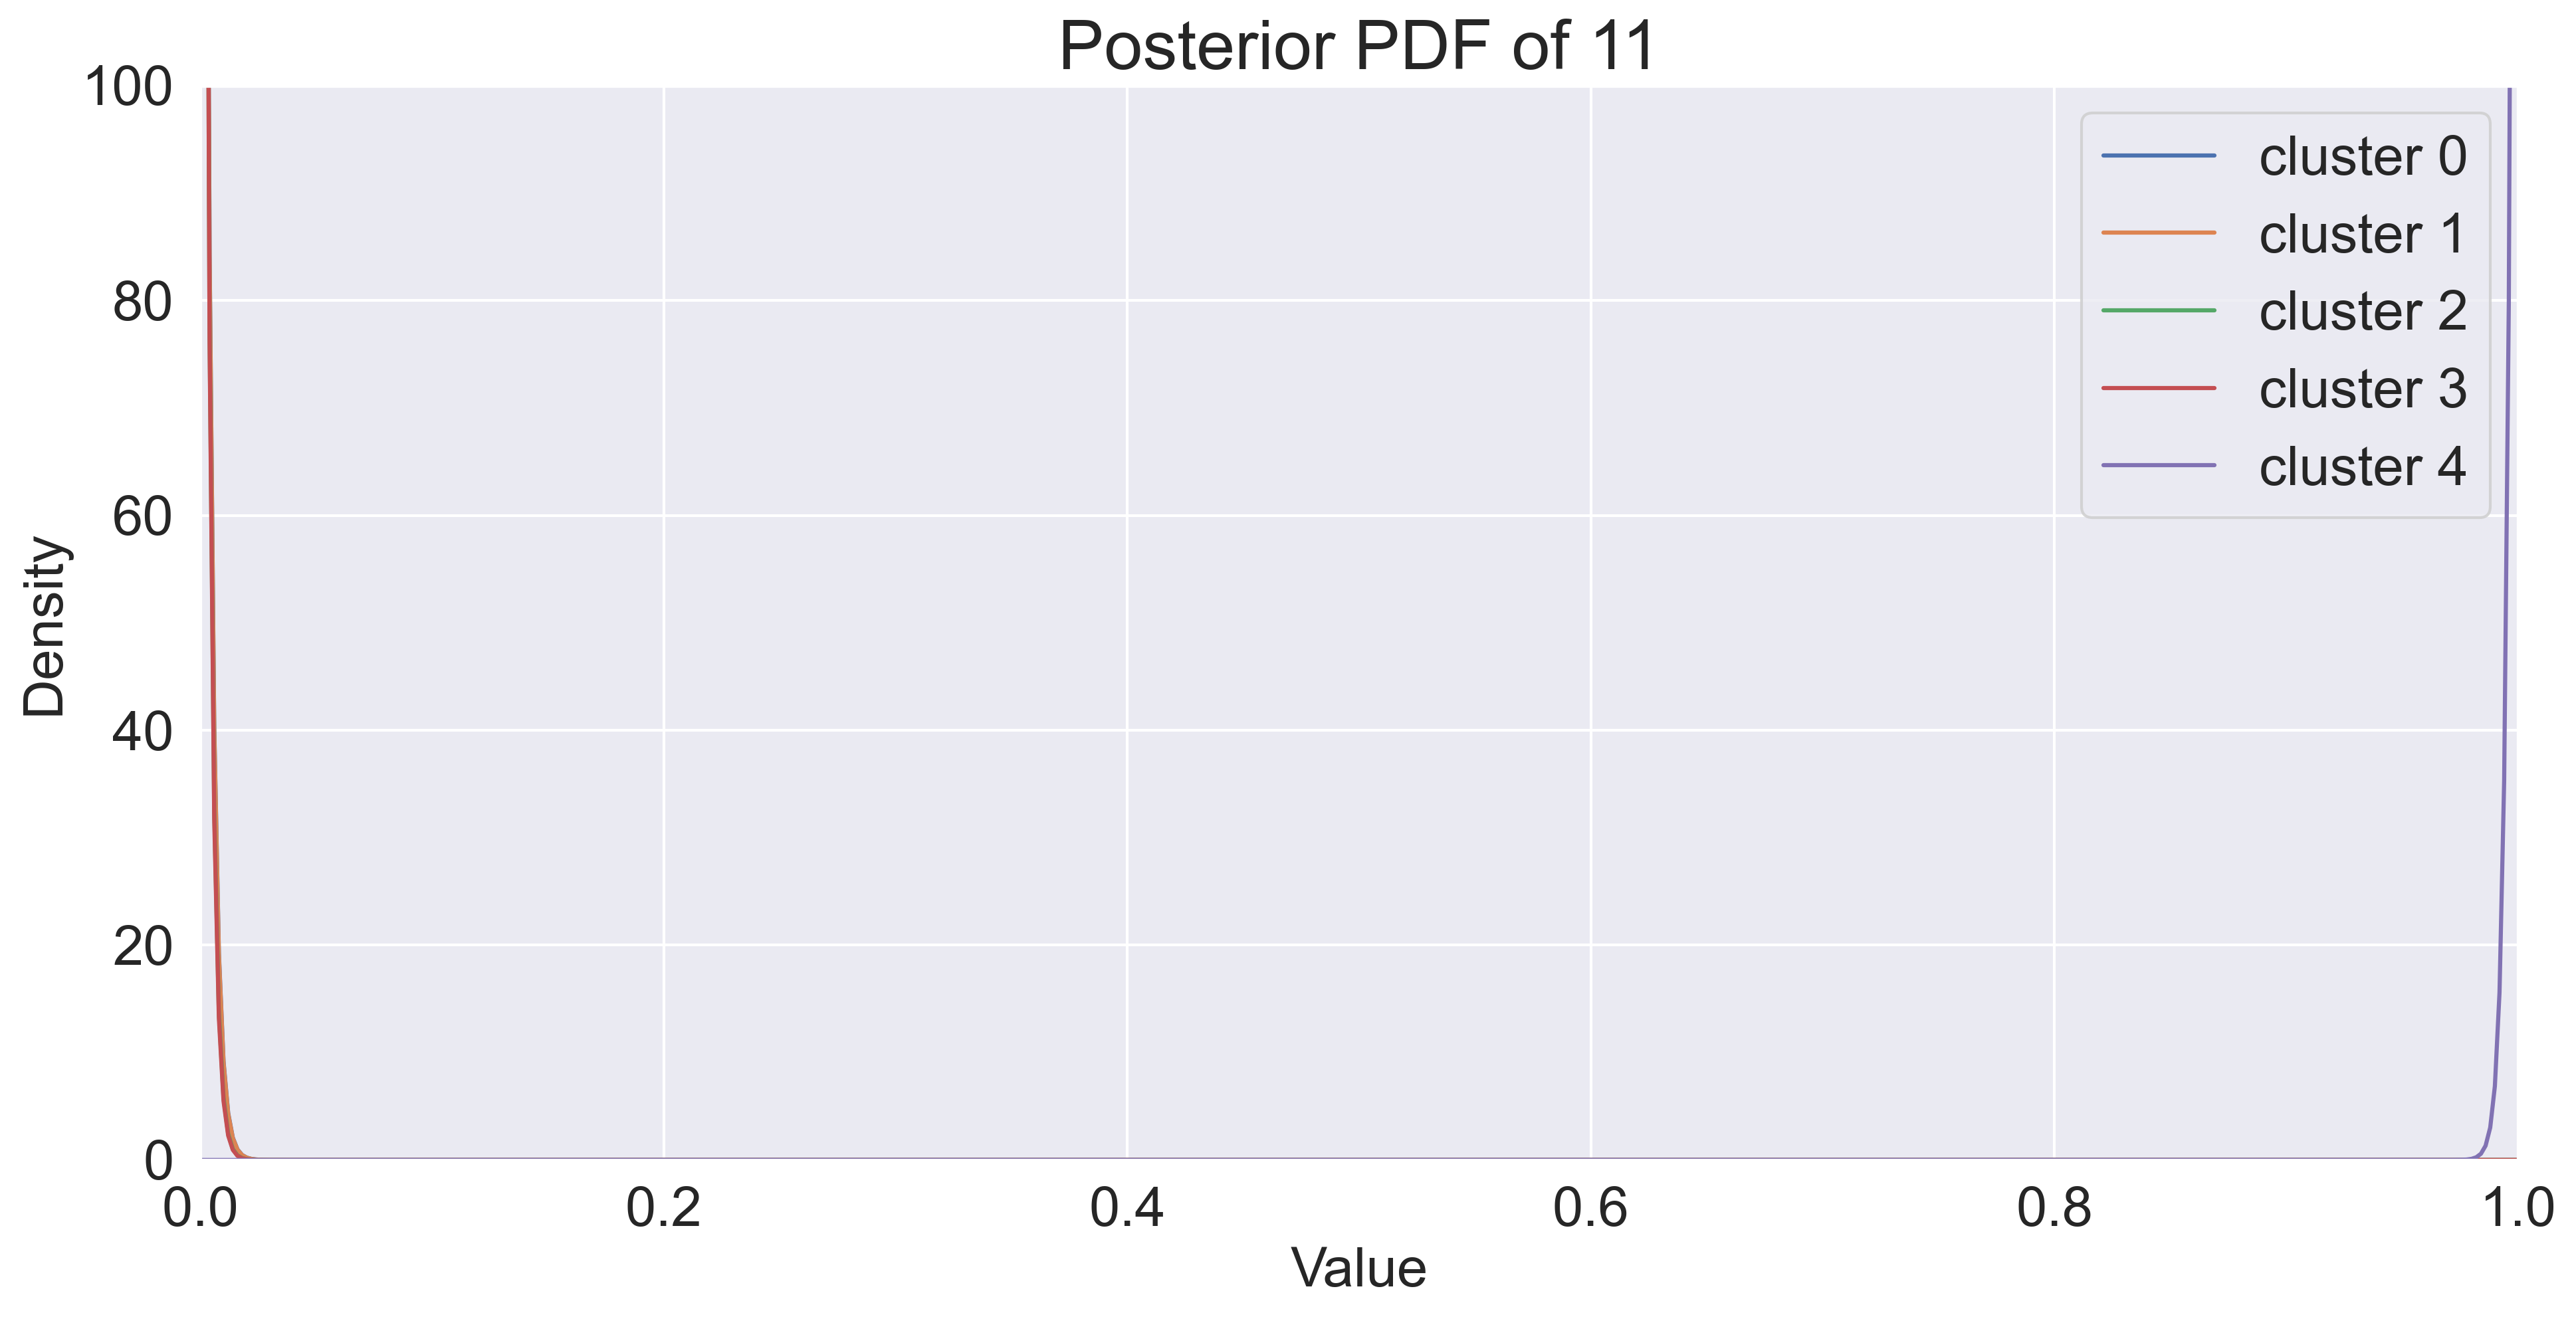

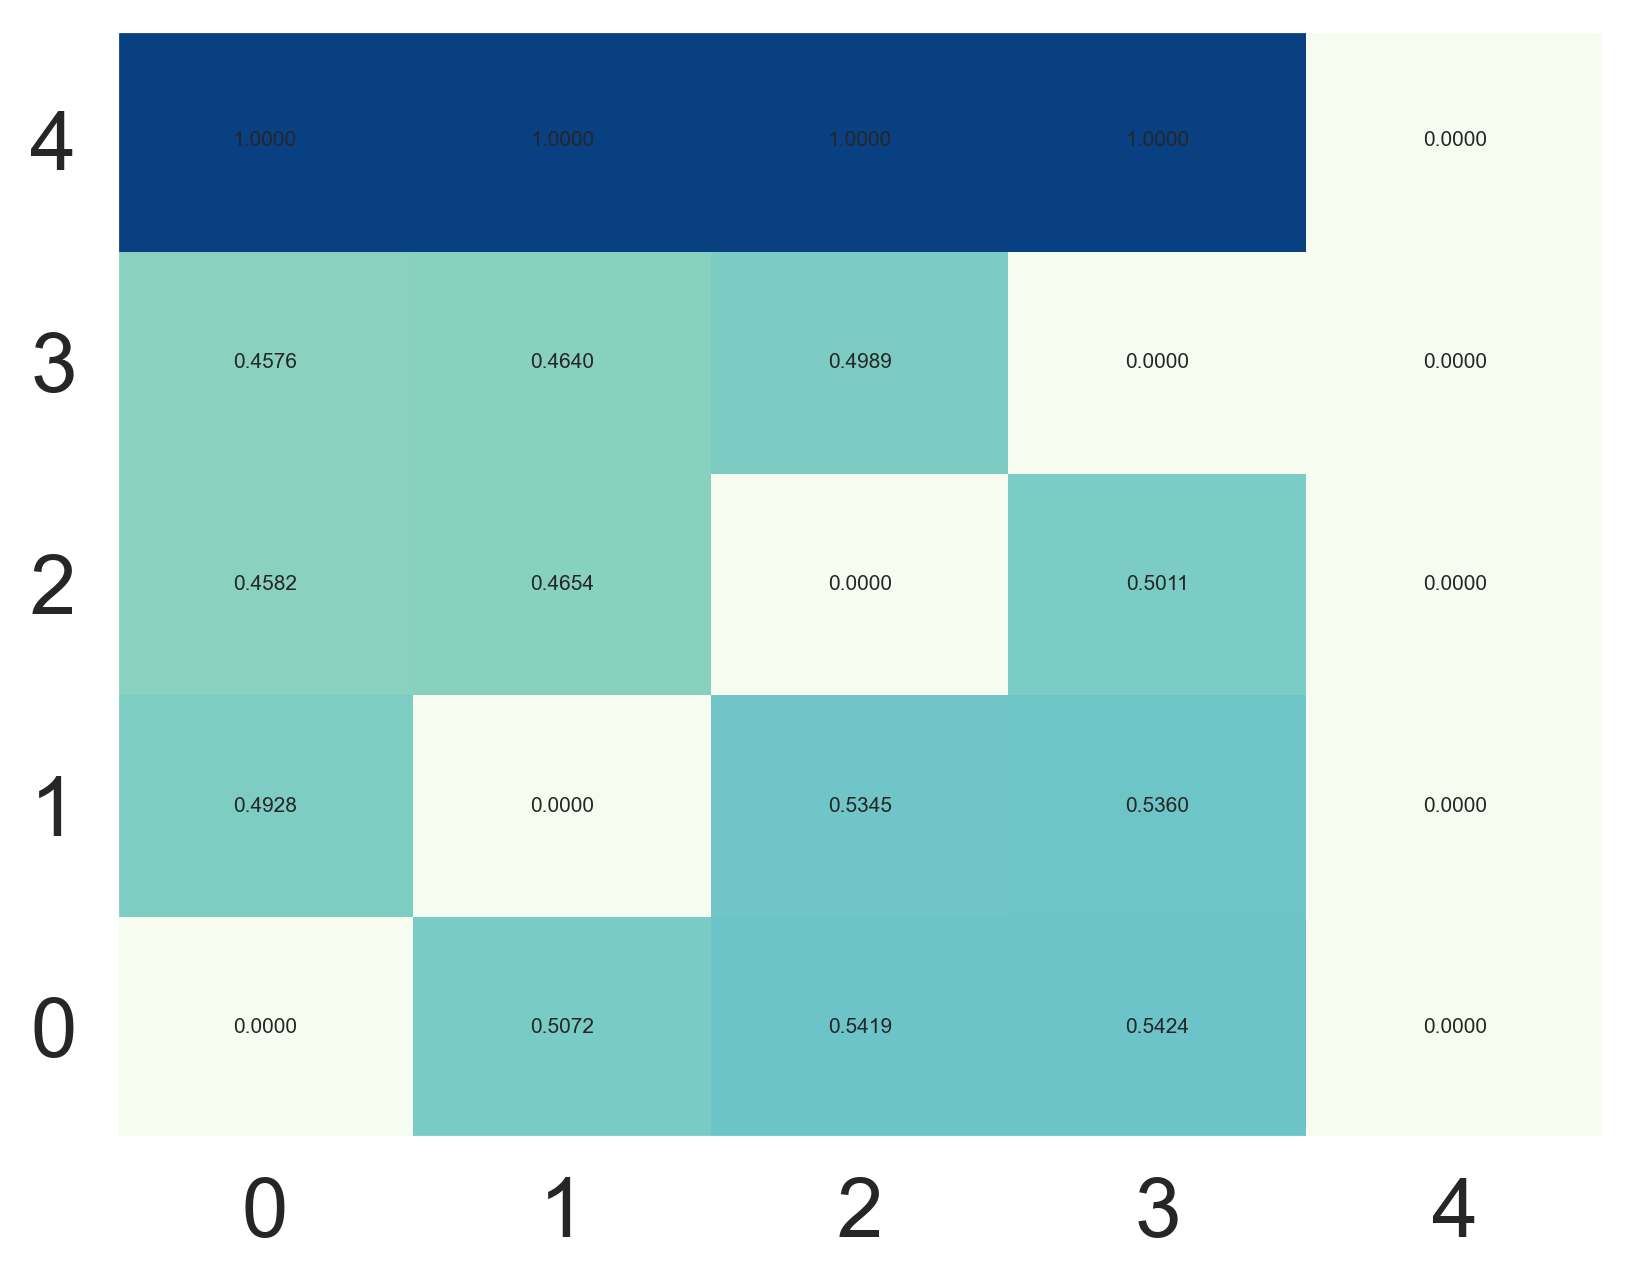

/Users/balbie/Downloads/Thesis/explain_clustering/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:670: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


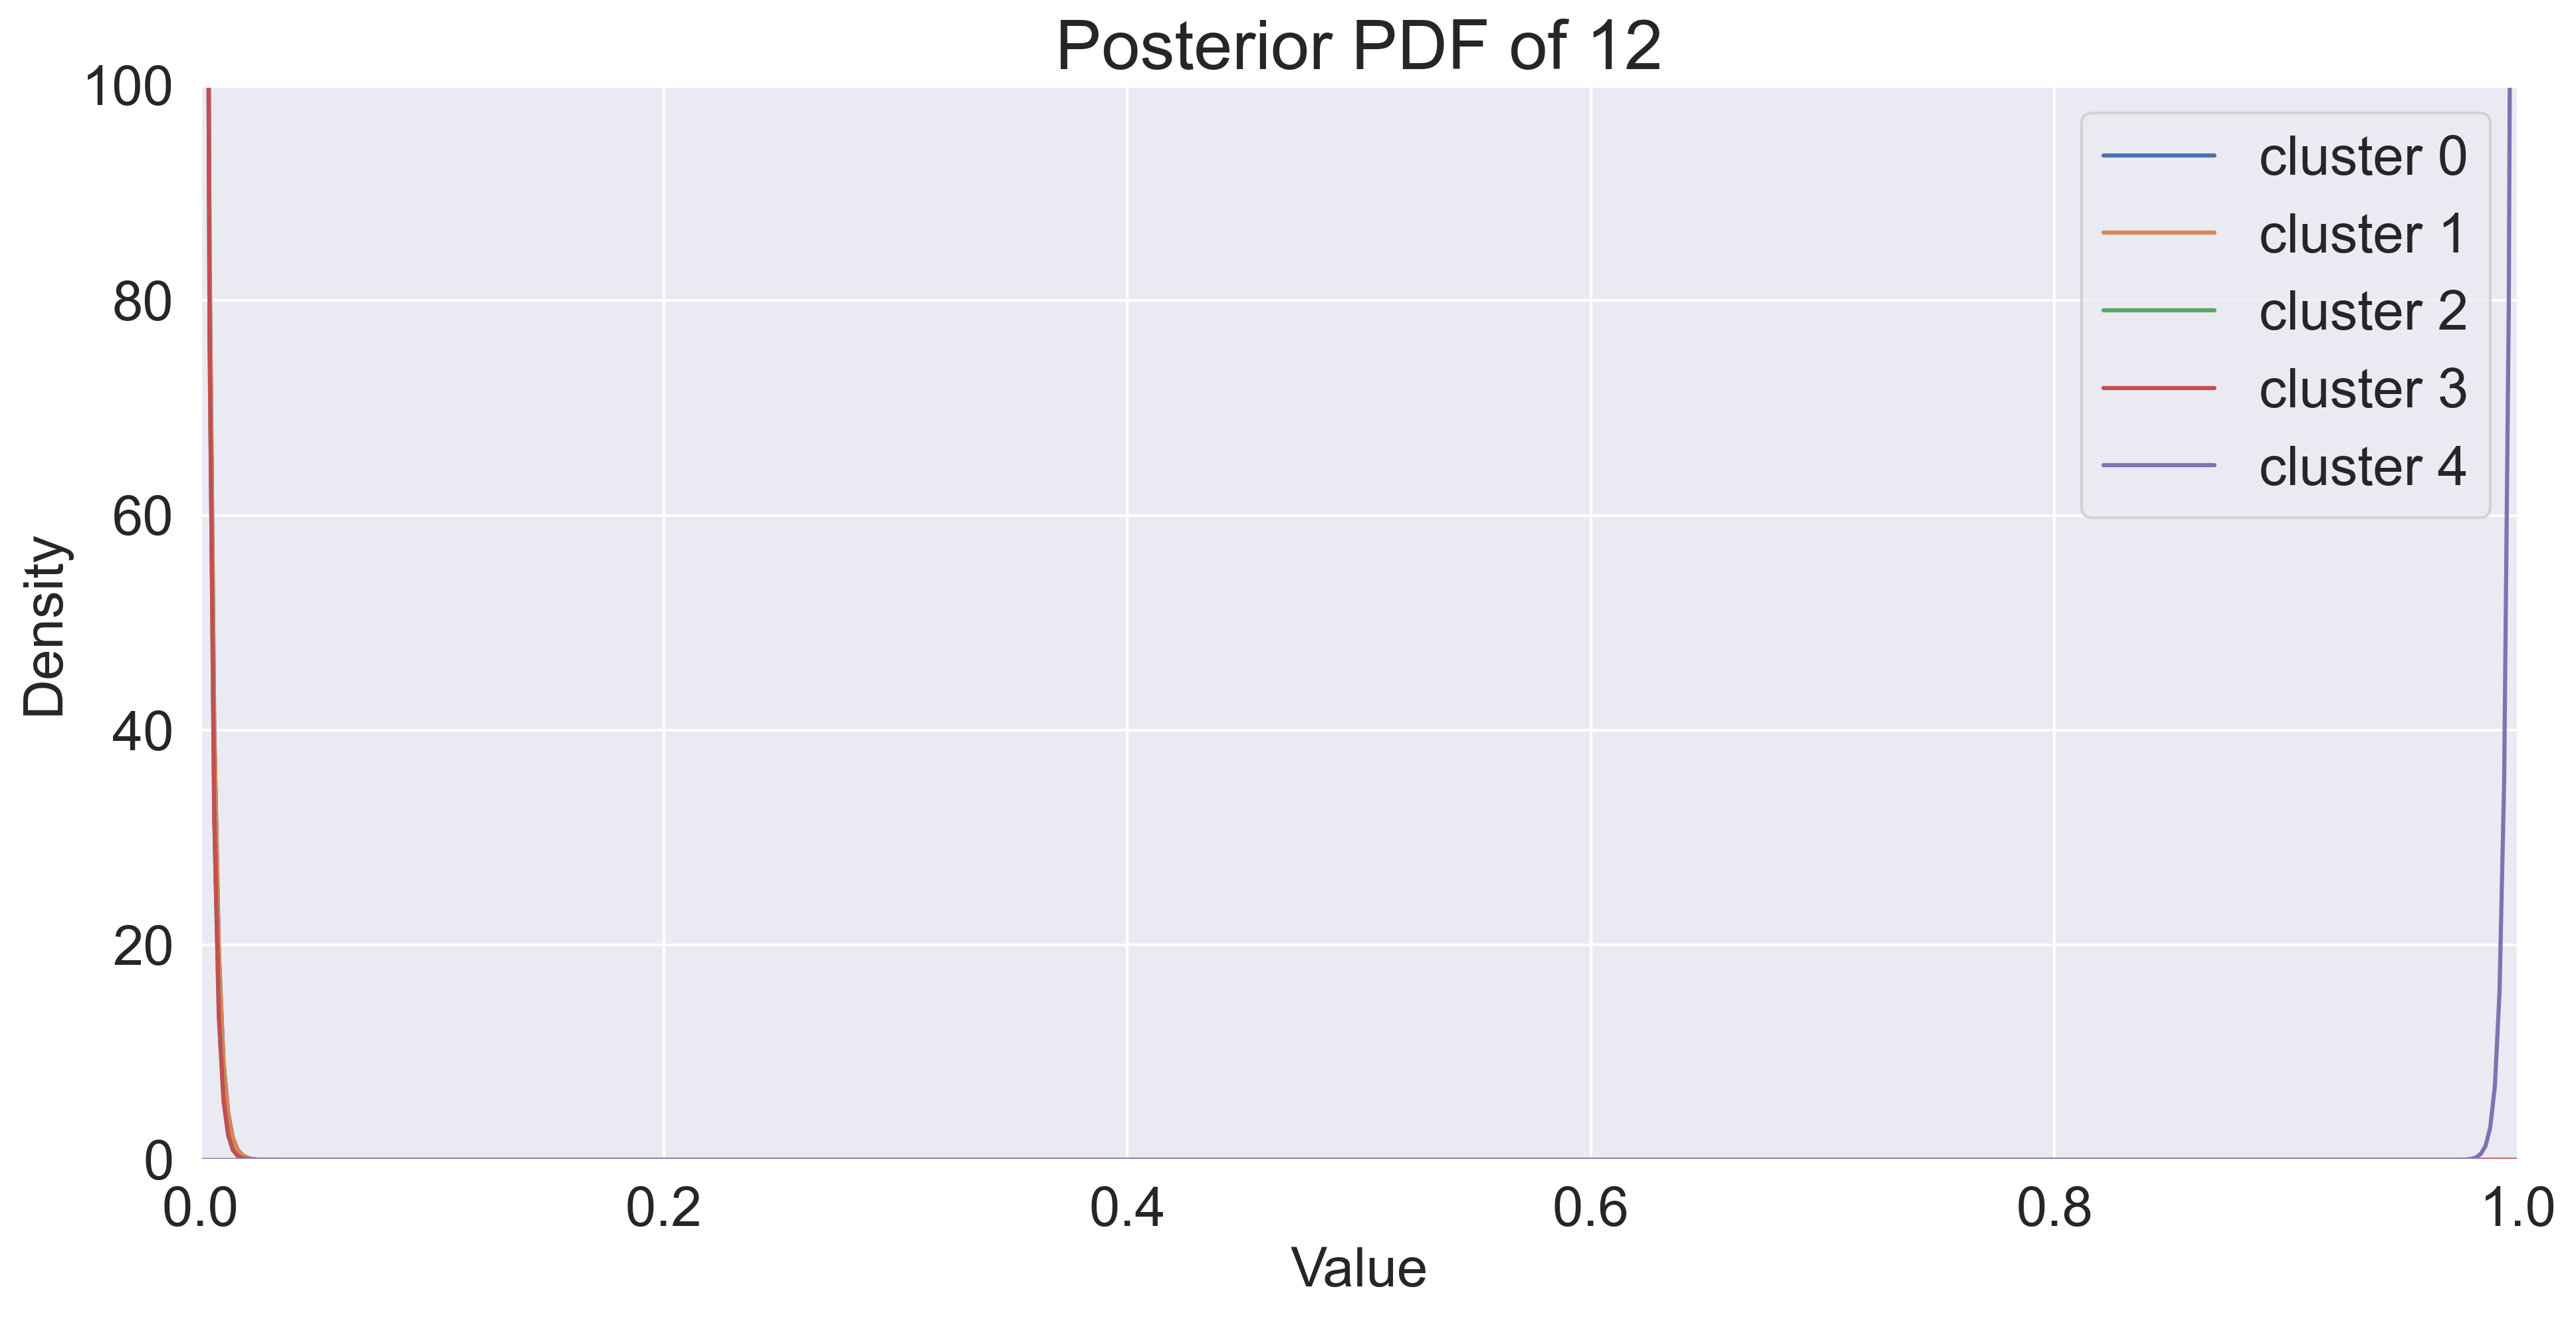

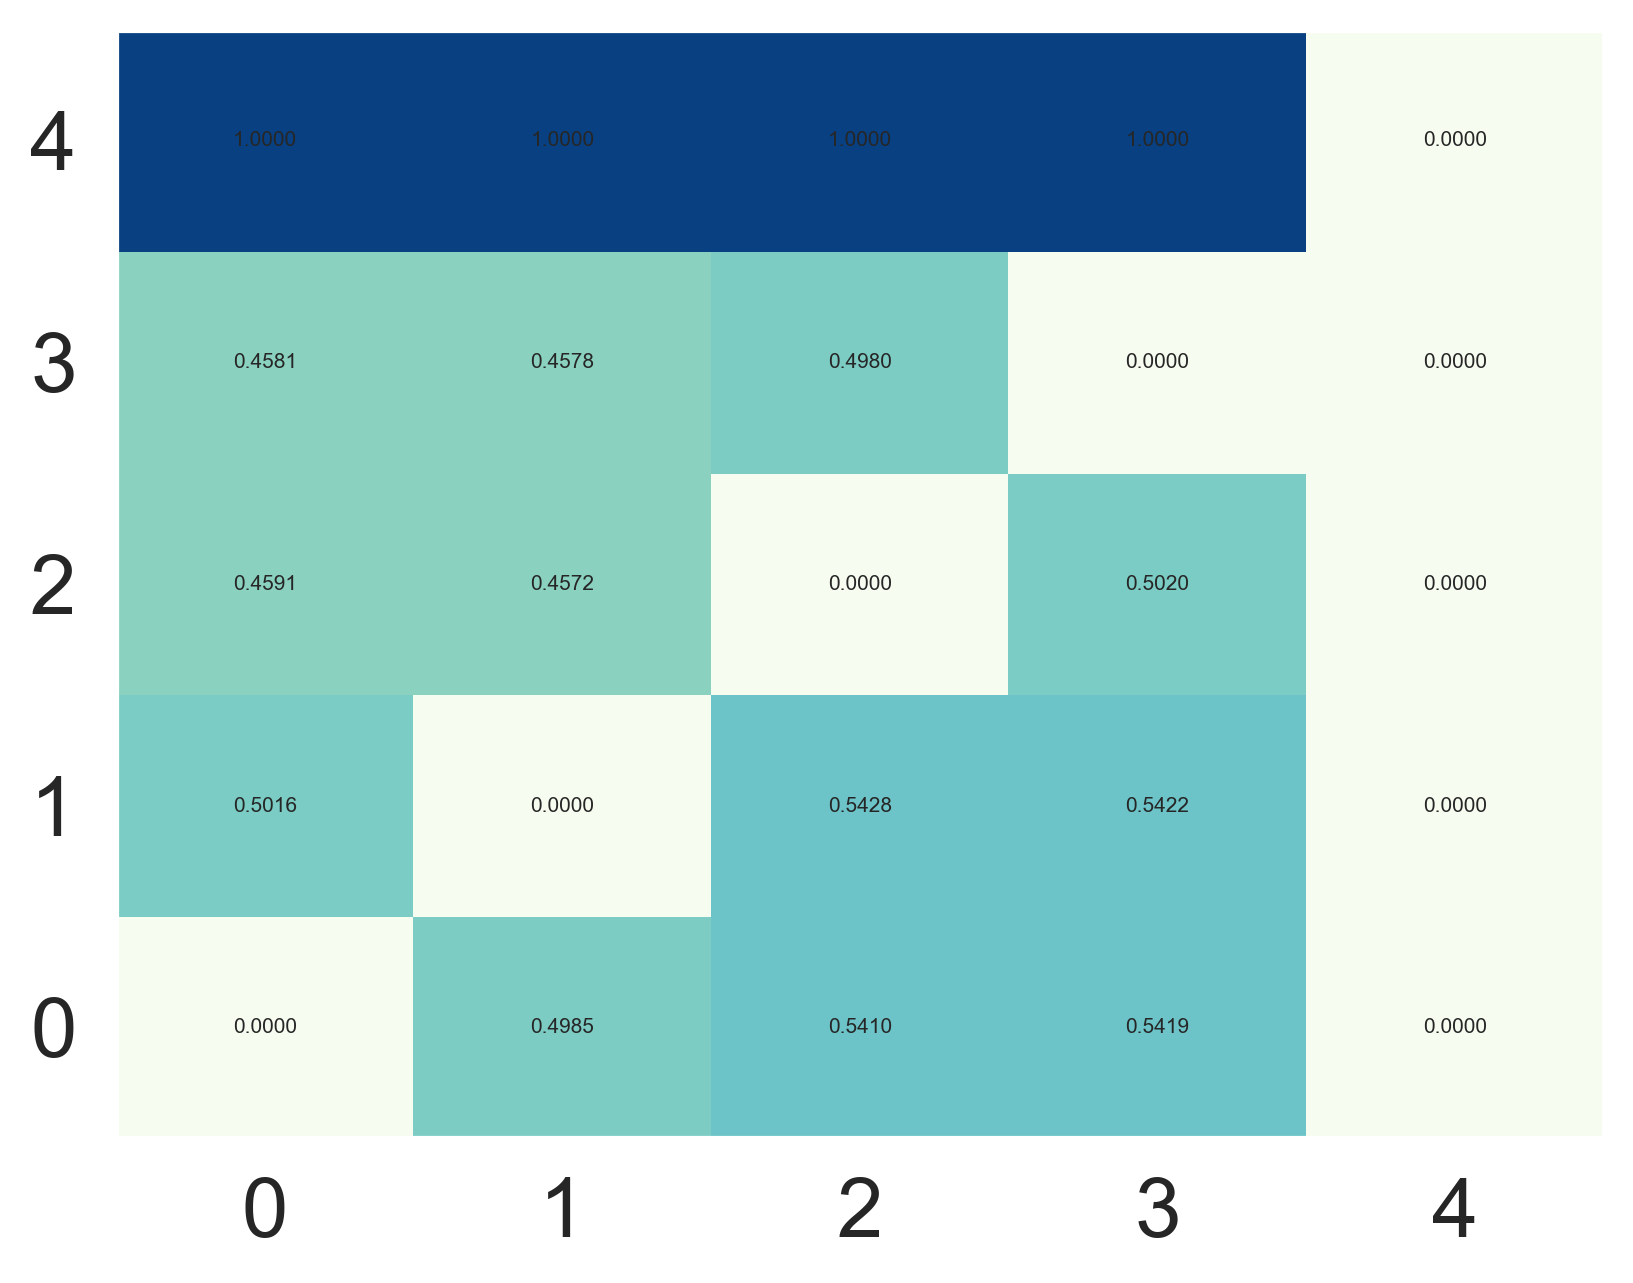

In [19]:
bi_explainer = BayesExplainer(df, 'k_means_5_mapped', cat_features, [] )
significance_matrix = bi_explainer.explain()

In [20]:
significance_matrix

0  1  2  3  4  5  6  7  8  9  10 11 12
k_means_5_mapped                                       
0                 4  4  4  0  0  0  0  0  0  0  0  0  0
1                 0  0  0  4  4  4  0  0  0  0  0  0  0
2                 0  0  0  0  0  0  4  4  4  0  0  0  0
3                 0  0  0  0  0  0  0  0  0  4  4  0  0
4                 0  0  0  0  0  0  0  0  0  0  0  4  4

In [22]:
print('More than 4 others')
results = {}
num_clusters = 5
bi_k = 4
for i in range(num_clusters):
    cluster_id = i
    transpose = significance_matrix.T
    res = transpose[transpose[cluster_id] >= bi_k].index
    results[i] = list(transpose[transpose[cluster_id] >= bi_k].index)
    print(f'Cluster {i}:', transpose[transpose[cluster_id] >= bi_k].index)

More than 4 others
Cluster 0: Index([0, 1, 2], dtype='int64')
Cluster 1: Index([3, 4, 5], dtype='int64')
Cluster 2: Index([6, 7, 8], dtype='int64')
Cluster 3: Index([9, 10], dtype='int64')
Cluster 4: Index([11, 12], dtype='int64')


In [ ]:
true_explanation = {
    0: [0, 1, 2],
    1: [3, 4, 5],
    2: [6, 7, 8],
    3: [6, 7, 9],
    4: [10, 11, 12],
}